# Оценка риска ДТП каршеринговой компании

Нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения

**Цели работы:**

-изучит данные каршеринговой компании

-проанализировать данные

-обучить алгоритмы оценивать риск ДТП

**Описание данных:**

collisions — общая информация о ДТП

Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
parties — информация об участниках ДТП

Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
vehicles — информация о пострадавших машинах

Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

**Краткий план работы:**

-провести предобработку данных: устранить пропуски, дубликаты

-исследовать данные: найти закономерности, зависимости, визуализировать результаты

-обучить модели ML: попробывать алгоритмы бэггинга, бустинга, протестировать разные архитектуры нейронных сетей, попробовать разные методы инициализации, оптимизации и тд. Улучшить качество модели

-проверить лучшую модель в работе, выяснить какие факторы больше всего влияют на вероятность ДТП

-дать рекомендации по улучшению алгоритмов каршеринговой компании

## Загрузка данных

In [ ]:
!pip install phik -q
!pip install sqlalchemy -q
!pip install psycopg2-binary -q
!pip install torchmetrics -q
!pip install optuna -q
!pip install optuna-integration -q
!pip install catboost -q
!pip install shap -q
!pip install lightgbm -q
# !pip install -U scikit-learn -q

In [ ]:
import pandas as pd
import numpy as np
import phik
import torch
import random
import os
import shap

import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from torchmetrics import F1Score, AUROC
import optuna
from optuna import trial
from optuna import distributions
from optuna.integration import OptunaSearchCV

import catboost as cb
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.metrics import (accuracy_score, confusion_matrix, recall_score,
                             precision_score, roc_auc_score, f1_score, roc_curve,
                            precision_recall_curve)
from sklearn.ensemble import RandomForestClassifier
from sqlalchemy import create_engine
from sklearn.impute import  KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler


import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

Подключение к БД

In [ ]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [ ]:
engine = create_engine(connection_string)

Данные представленны в 4 таблицах

In [ ]:
query_parties = '''
SELECT *
FROM parties
LIMIT 5
'''

query_vehicles = '''
SELECT *
FROM vehicles
LIMIT 5
'''

query_collisions = '''
SELECT *
FROM collisions
LIMIT 5
'''

query_case_id = '''
SELECT *
FROM case_ids
LIMIT 5
'''

parties_head = pd.read_sql_query(query_parties, con=engine)
vehicles_head = pd.read_sql_query(query_vehicles, con=engine)
collisions_head = pd.read_sql_query(query_collisions, con=engine)
case_id_head = pd.read_sql_query(query_case_id, con=engine)

print(parties_head)

   id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0  
2  had not been drinking                None                 0  
3  had not been drinking                None                 0  
4         not applicable      not applicable                 0  


In [ ]:
print(vehicles_head)

        id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5  


In [ ]:
print(collisions_head)

   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         s

In [ ]:
print(case_id_head)

   case_id db_year
0  0081715    2021
1  0726202    2021
2  3858022    2021
3  3899441    2021
4  3899442    2021


In [ ]:
query_info = '''
WITH table_info AS(
SELECT n.nspname AS schema_name,
       c.relname AS table_name,
       c.reltuples AS rows_qty
FROM pg_class c
JOIN pg_namespace n ON n.oid = c.relnamespace
WHERE c.relkind = 'r' AND n.nspname = 'public'
),

columns_info AS(
SELECT table_name,
       COUNT(column_name) AS columns_qty
FROM information_schema.columns
WHERE table_schema = 'public'
GROUP BY table_name)

SELECT ti.schema_name,
       ti.table_name,
       ti.rows_qty,
       ci.columns_qty
FROM table_info AS ti
JOIN columns_info AS ci ON ci.table_name=ti.table_name
WHERE ti.table_name IN ('collisions', 'parties', 'vehicles', 'case_ids')
'''

info = pd.read_sql_query(query_info, con=engine)
print(info)

  schema_name  table_name   rows_qty  columns_qty
0      public     parties  2752408.0            9
1      public  collisions  1400000.0           20
2      public    vehicles  1021234.0            6
3      public    case_ids  1400000.0            2


In [ ]:
query_columns = '''
WITH columns_info AS (
  SELECT table_name,
         column_name,
         data_type
  FROM INFORMATION_SCHEMA.COLUMNS
  WHERE table_name IN ('collisions', 'parties', 'vehicles', 'case_ids')
)
SELECT *
FROM columns_info
ORDER BY table_name, column_name
'''

df = pd.read_sql_query(query_columns, con=engine)
print(df)

    table_name                  column_name               data_type
0     case_ids                      case_id                    text
1     case_ids                      db_year                    text
2   collisions                      case_id                    text
3   collisions             collision_damage                    text
4   collisions               collision_date                    date
5   collisions               collision_time  time without time zone
6   collisions               control_device                    text
7   collisions         county_city_location                    text
8   collisions              county_location                    text
9   collisions                    direction                    text
10  collisions                     distance                    real
11  collisions                 intersection                 integer
12  collisions                     lighting                    text
13  collisions                location_type     

Данные состоят из 4 таблиц:

1 таблица(vehicles) - 3 колонки типа text, 3 колонки типа integer, 1021234 строк

2 таблица(parties) - 4 колонки типа text, 5 колонки типа integer, 2752408 строк

3 таблица(collisions) - 16 колонок типа text, 3 колонка типа integer, 1 колонка типа time without time zone, 1400000 строк

4 таблица(case_ids) - 2 колонки типа text, 1400000 строк

## Пропуски, дубликаты, уникальные значения

In [ ]:
for tables in ("collisions", "parties", "vehicles", "case_ids"):

    df = pd.read_sql_query("SELECT * FROM " + str(tables), con=engine)
    na_rates = df.isna().mean()
    print(tables)
    print(na_rates)
    print()

collisions
case_id                        0.000000
county_city_location           0.000000
county_location                0.000000
distance                       0.000000
direction                      0.243316
intersection                   0.008728
weather_1                      0.005185
location_type                  0.629444
collision_damage               0.000000
party_count                    0.000000
primary_collision_factor       0.005833
pcf_violation_category         0.019967
type_of_collision              0.008446
motor_vehicle_involved_with    0.004871
road_surface                   0.009352
road_condition_1               0.008563
lighting                       0.006138
control_device                 0.006005
collision_date                 0.000000
collision_time                 0.008791
dtype: float64

parties
id                     0.000000
case_id                0.000000
party_number           0.000000
party_type             0.001316
at_fault               0.000000
insur

Наблюдаем некоторое кол-во пропусков, наибольшее кол-во: колонка party_drug_physical таблицы parties ~84% пропусков, колонка location_type таблицы collisions ~62% пропусков

In [ ]:
for table in ("collisions", "parties", "vehicles", "case_ids"):
    columns = pd.read_sql_query("SELECT column_name FROM information_schema.columns WHERE table_name = '" + table + "'", con=engine)
    columns = columns['column_name'].tolist()
    columns_str = ', '.join(columns)
    dupl = pd.read_sql_query("SELECT COUNT(*) - COUNT(DISTINCT (" + columns_str + ")) FROM " + table, con=engine)
    print(dupl.iloc[0, 0])

0
0
0
0


Явных дубликатов не наблюдаем

In [ ]:
unique = "SELECT DISTINCT db_year FROM case_ids"
unique_case_ids = pd.read_sql_query(unique, con=engine)
print(unique_case_ids)

  db_year
0    2021


Информационной нагрузки таблица case_ids не несет, в дальнейшем к ней не будем возвращаться

Посмотрим на значения категориальных данных, разброс значений кол-ых переменных

### Таблица vehicles



In [ ]:
unique = "SELECT DISTINCT vehicle_transmission FROM vehicles"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  vehicle_transmission
0                 None
1                 auto
2               manual


In [ ]:
unique = "SELECT DISTINCT vehicle_age FROM vehicles"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    vehicle_age
0           8.0
1          11.0
2          19.0
3           NaN
4         161.0
5           4.0
6           0.0
7          14.0
8           3.0
9          17.0
10         20.0
11         13.0
12          7.0
13         10.0
14          9.0
15          1.0
16          5.0
17         18.0
18          2.0
19         16.0
20         15.0
21          6.0
22         12.0


In [ ]:
unique = "SELECT DISTINCT vehicle_type FROM vehicles"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  vehicle_type
0    hatchback
1      minivan
2        sedan
3        other
4        coupe


In [ ]:
unique = "SELECT DISTINCT party_number FROM vehicles"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    party_number
0              5
1             18
2              2
3             16
4             15
5              6
6             26
7             12
8             27
9             23
10            24
11            11
12             8
13            19
14            25
15             4
16            21
17            14
18             3
19            17
20            20
21            22
22            10
23             9
24            13
25             7
26             1


Проверим идентификаторы

In [ ]:
duplicates = "SELECT COUNT(*) - COUNT(DISTINCT id) FROM vehicles"
duplicates_id = pd.read_sql_query(duplicates, con=engine)
print(duplicates_id.iloc[0, 0])

0


In [ ]:
duplicates = "SELECT COUNT(*) - COUNT(DISTINCT case_id) FROM vehicles"
duplicates_case_id = pd.read_sql_query(duplicates, con=engine)
print(duplicates_case_id.iloc[0, 0])

228592


In [ ]:
count = "SELECT COUNT(*) FROM vehicles"
count_ = pd.read_sql_query(count, con=engine)
print(count_.iloc[0, 0])

1021234


Наблюдаем несколько записей id транспортного средства под case_id номера зарегистрированного ДТП

### Таблица parties

In [ ]:
unique = "SELECT DISTINCT party_number FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    party_number
0              5
1             18
2              2
3             16
4             15
5              6
6             26
7             12
8             27
9             23
10            24
11            11
12             8
13            19
14            25
15             4
16            21
17            14
18             3
19            17
20            22
21            20
22            13
23            10
24             9
25             7
26             1


In [ ]:
unique = "SELECT DISTINCT party_type FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    party_type
0   road signs
1          car
2         None
3        other
4  road bumper
5     building


In [ ]:
unique = "SELECT DISTINCT at_fault FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

   at_fault
0         0
1         1


In [ ]:
stats = """
    SELECT
        COUNT(insurance_premium) AS count,
        AVG(insurance_premium) AS mean,
        STDDEV(insurance_premium) AS std,
        MIN(insurance_premium) AS min,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY insurance_premium) AS percentile_25,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY insurance_premium) AS percentile_50,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY insurance_premium) AS percentile_75,
        MAX(insurance_premium) AS max
    FROM parties
"""
stats_ = pd.read_sql_query(stats, con=engine)
print(stats_)

     count      mean        std  min  percentile_25  percentile_50  \
0  2347006  38.74724  16.378511    0           25.0           36.0   

   percentile_75  max  
0           50.0  105  


In [ ]:
unique = "SELECT DISTINCT party_sobriety FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

                           party_sobriety
0                                    None
1                   had not been drinking
2  had been drinking, not under influence
3                      impairment unknown
4      had been drinking, under influence
5                          not applicable
6   had been drinking, impairment unknown


In [ ]:
unique = "SELECT DISTINCT party_drug_physical FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

     party_drug_physical
0                   None
1        sleepy/fatigued
2         not applicable
3  impairment - physical
4   under drug influence
5                      G


In [ ]:
unique = "SELECT DISTINCT cellphone_in_use FROM parties"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

   cellphone_in_use
0               NaN
1               0.0
2               1.0


In [ ]:
duplicates = """
    SELECT COUNT(*) - COUNT(DISTINCT id) AS duplicates
    FROM parties
"""
duplicates_id = pd.read_sql_query(duplicates, con=engine)
print(duplicates_id.iloc[0, 0])

0


In [ ]:
duplicates = """
    SELECT COUNT(*) - COUNT(DISTINCT case_id) AS duplicates
    FROM parties
"""
duplicates_case_id = pd.read_sql_query(duplicates, con=engine)
print(duplicates_case_id.iloc[0, 0])

1352408


### Таблица collisions

In [ ]:
duplicates = """
    SELECT COUNT(*) - COUNT(DISTINCT case_id) AS duplicates
    FROM collisions
"""
duplicates_case_id = pd.read_sql_query(duplicates, con=engine)
print(duplicates_case_id.iloc[0, 0])

0


In [ ]:
unique = "SELECT DISTINCT county_city_location FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_.count())
print(unique_.head())

county_city_location    538
dtype: int64
  county_city_location
0                 1944
1                 3015
2                 0800
3                 0708
4                 4905


In [ ]:
unique = "SELECT DISTINCT county_location FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_.count())
print(unique_.head())

county_location    58
dtype: int64
  county_location
0          sonoma
1          fresno
2            kern
3            yolo
4        monterey


In [ ]:
unique = "SELECT DISTINCT direction FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  direction
0      west
1      None
2     north
3      east
4     south


In [ ]:
unique = "SELECT DISTINCT intersection FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

   intersection
0           NaN
1           0.0
2           1.0


In [ ]:
unique = "SELECT DISTINCT weather_1 FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  weather_1
0     other
1      wind
2     clear
3   raining
4    cloudy
5      None
6       fog
7   snowing


In [ ]:
unique = "SELECT DISTINCT location_type FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  location_type
0          None
1  intersection
2       highway
3          ramp


In [ ]:
unique = "SELECT DISTINCT collision_damage FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  collision_damage
0          scratch
1    severe damage
2     small damage
3    middle damage
4            fatal


In [ ]:
unique = "SELECT DISTINCT party_count FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    party_count
0             4
1            21
2            14
3             3
4            20
5            13
6            10
7             9
8             7
9             1
10            5
11            2
12           15
13            6
14           12
15           27
16           11
17            8


In [ ]:
unique = "SELECT DISTINCT primary_collision_factor FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  primary_collision_factor
0              fell asleep
1   other improper driving
2                     None
3                  unknown
4        other than driver
5   vehicle code violation


In [ ]:
unique = "SELECT DISTINCT pcf_violation_category FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

               pcf_violation_category
0              other improper driving
1           other hazardous violation
2                    improper passing
3                     other equipment
4             automobile right of way
5                    improper turning
6                pedestrian violation
7                  wrong side of road
8                  unsafe lane change
9           traffic signals and signs
10                               None
11         unsafe starting or backing
12                                dui
13                           speeding
14                  hazardous parking
15              following too closely
16            pedestrian right of way
17                            unknown
18  other than driver (or pedestrian)
19                        fell asleep
20                   impeding traffic
21                             lights
22                     pedestrian dui
23                             brakes


In [ ]:
unique = "SELECT DISTINCT type_of_collision FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  type_of_collision
0         sideswipe
1              None
2           head-on
3         broadside
4        overturned
5        hit object
6             other
7          rear end


In [ ]:
unique = "SELECT DISTINCT motor_vehicle_involved_with FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

      motor_vehicle_involved_with
0            parked motor vehicle
1                   non-collision
2                          animal
3                    fixed object
4                            None
5                           train
6  motor vehicle on other roadway
7             other motor vehicle
8                         bicycle
9                    other object


In [ ]:
unique = "SELECT DISTINCT road_surface FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  road_surface
0          dry
1          wet
2     slippery
3         None
4        snowy


In [ ]:
unique = "SELECT DISTINCT road_condition_1 FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

  road_condition_1
0   loose material
1      obstruction
2             None
3          flooded
4     construction
5            holes
6           normal
7    reduced width
8            other


In [ ]:
unique = "SELECT DISTINCT lighting FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

                                  lighting
0                                     None
1                  dark with street lights
2               dark with no street lights
3                                 daylight
4  dark with street lights not functioning
5                             dusk or dawn


In [ ]:
unique = "SELECT DISTINCT control_device FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_)

    control_device
0      functioning
1         obscured
2  not functioning
3             None
4             none


In [ ]:
unique = "SELECT DISTINCT collision_date FROM collisions"
unique_ = pd.read_sql_query(unique, con=engine)
print(unique_.count())
print(unique_.head())

collision_date    1550
dtype: int64
  collision_date
0     2013-02-11
1     2009-01-22
2     2012-06-08
3     2009-11-21
4     2012-05-09


## Исследовательский анализ данных

Распределим колонки по типу в перемененные для удобства обращения

In [ ]:
vehicles_cat_col = ['vehicle_type', 'vehicle_transmission']

In [ ]:
vehicles_cat_col_much = ['party_number', 'vehicle_age']

In [ ]:
parties_cat_col = ['party_type', 'at_fault', 'party_sobriety', 'party_drug_physical', 'cellphone_in_use']

In [ ]:
parties_cat_col_much = ['party_number']

In [ ]:
parties_num_col = ['insurance_premium']

In [ ]:
collisions_cat_col = ['direction', 'intersection', 'weather_1', 'location_type',
                      'collision_damage', 'primary_collision_factor', 'type_of_collision',
                      'road_surface', 'road_condition_1', 'lighting', 'control_device']

In [ ]:
collisions_cat_col_much = ['county_city_location', 'county_location', 'party_count',
                           'pcf_violation_category', 'motor_vehicle_involved_with']

In [ ]:
collisions_num_col = ['distance']

### Таблица vehicles

In [ ]:
head = """
    SELECT *
    FROM vehicles
    LIMIT 5
"""
head_ = pd.read_sql_query(head, con=engine)
print(head_)

        id  case_id  party_number vehicle_type vehicle_transmission  \
0  1175713  5305032             2        sedan               manual   
1        1  3858022             1        sedan                 auto   
2  1175712  5305030             1        sedan                 auto   
3  1175717  5305033             3        sedan                 auto   
4  1175722  5305034             2        sedan                 auto   

   vehicle_age  
0            3  
1            3  
2            3  
3            5  
4            5  


#### Категориальные признаки

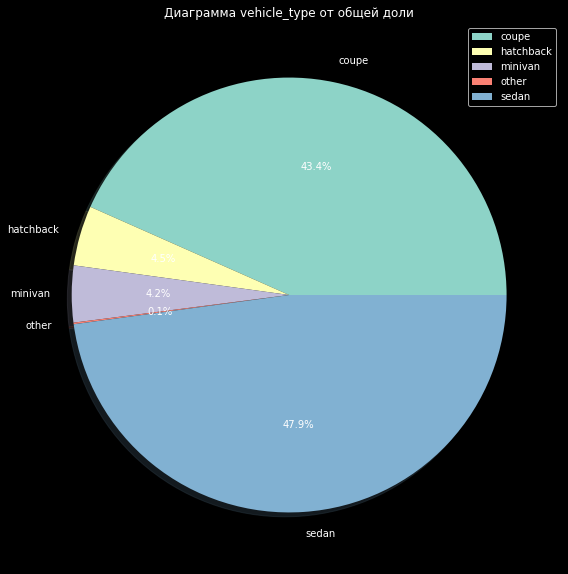

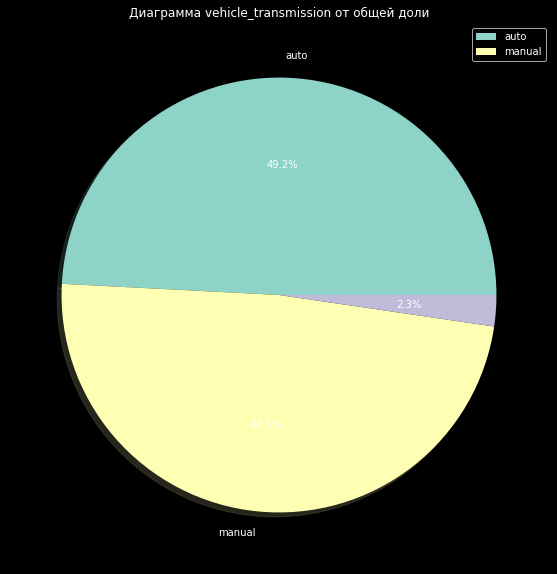

In [ ]:
for colum in vehicles_cat_col:
    fig, ax = plt.subplots(figsize=(12, 10))
    query = """
        SELECT
            {colum},
            COUNT(*) AS count,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM vehicles) AS percentage
        FROM vehicles
        GROUP BY {colum}
    """
    x = pd.read_sql_query(query.format(colum=colum), con=engine)
    labels = x[colum]
    x = x['percentage']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()
    print()

-Значения 'vehicle_type'(тип кузова автомобиля) в основном преобладают типы кузова sedan ~47.9% и coupe ~43.4%, осальные типы кузовов встречаются ~раз в 10 реже

-Значения 'vehicle_transmission'(тип КПП автомобиля) тип коробки +- равномерно распределен по данным

0     486135
1     465311
2      56622
3      10277
4       2135
5        484
6        140
7         53
8         26
9         12
10         9
11         6
12         5
13         1
14         1
15         1
16         2
17         2
18         2
19         2
20         2
21         1
22         1
23         1
24         1
25         1
26         1
Name: count, dtype: int64


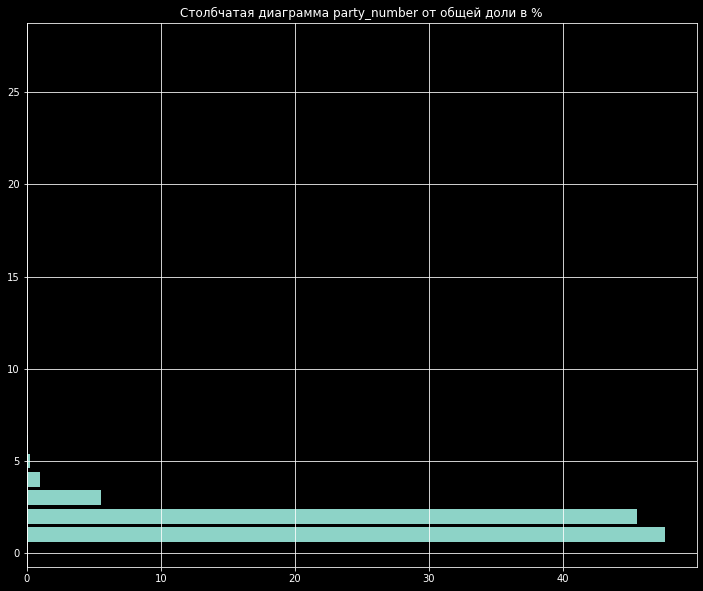


0      40262
1      41307
2     106530
3     178550
4     125472
5     105035
6      84362
7      84282
8      77070
9      58255
10     38457
11     27075
12     14947
13     10126
14      4096
15       673
16        96
17        31
18         1
19         6
20         2
21        17
22     24582
Name: count, dtype: int64


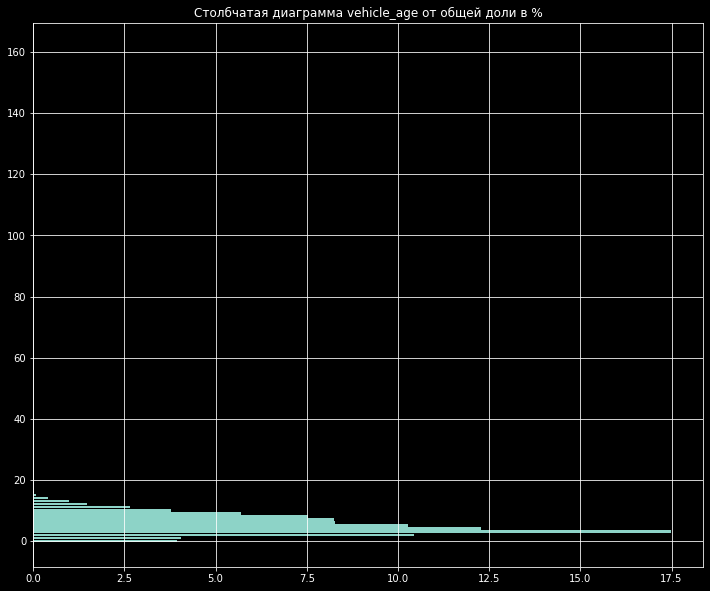

In [ ]:
for colum in vehicles_cat_col_much:
    query = """
        SELECT
            {colum},
            COUNT(*) AS count,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM vehicles) AS percentage
        FROM vehicles
        GROUP BY {colum}
    """
    x = pd.read_sql_query(query.format(colum=colum), con=engine)
    labels = x[colum]
    cnt = x['count']
    x = x['percentage']
    print(cnt)
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.barh(labels, x)
    plt.title('Cтолбчатая диаграмма '+ colum +' от общей доли в %')
    plt.grid(True)
    plt.show()
    print()

-Значения 'party_number'(номер участника ДТП) наблюдаем что в большинстве случаев ДТП учавствуют 2-е, ~90% случаев

-Значения 'vehicle_age'(возраст автомобиля в годах) значения имеют вид нормального распределения, смещенного к 0-ым значениям. Значения возраста в 161 год выглядят аномально и нереалистично

### Таблица parties

In [ ]:
head = """
    SELECT *
    FROM parties
    LIMIT 5
"""
head_ = pd.read_sql_query(head, con=engine)
print(head_)

   id  case_id  party_number   party_type  at_fault  insurance_premium  \
0  22  3899454             1   road signs         1               29.0   
1  23  3899454             2   road signs         0                7.0   
2  29  3899462             2          car         0               21.0   
3  31  3899465             2   road signs         0               24.0   
4  41  3899478             2  road bumper         0                NaN   

          party_sobriety party_drug_physical  cellphone_in_use  
0  had not been drinking                None                 0  
1  had not been drinking                None                 0  
2  had not been drinking                None                 0  
3  had not been drinking                None                 0  
4         not applicable      not applicable                 0  


#### Категориальные признаки

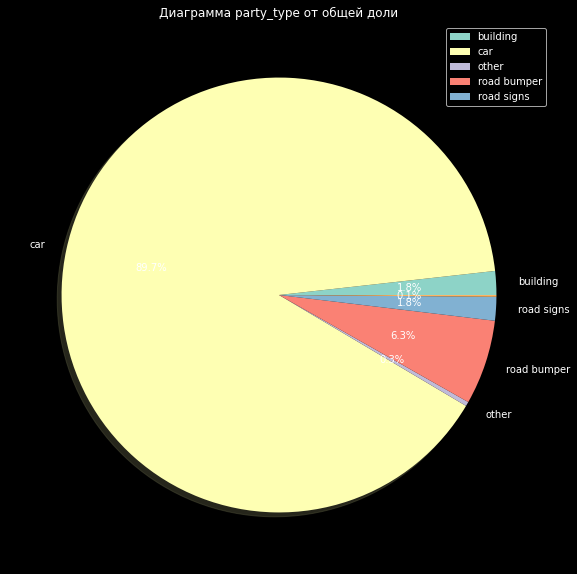

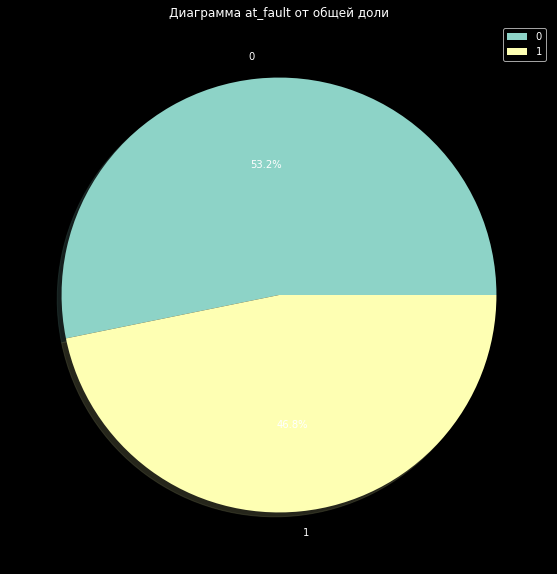

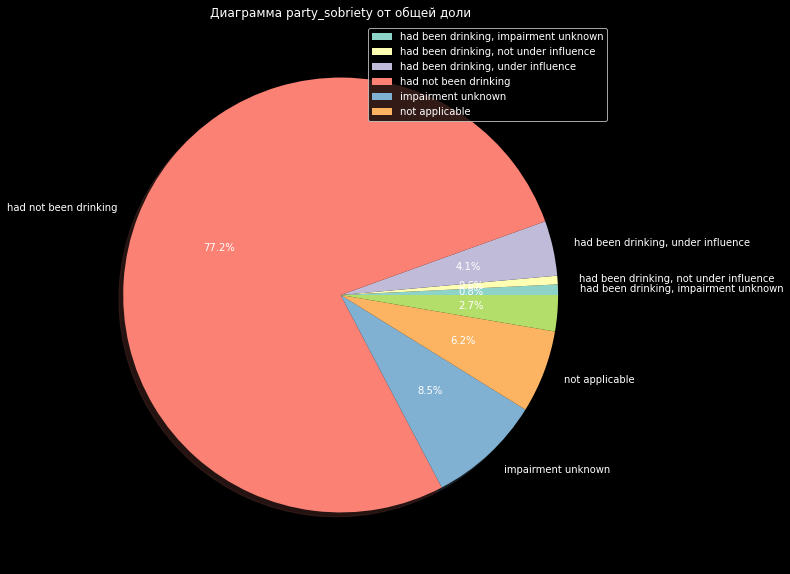

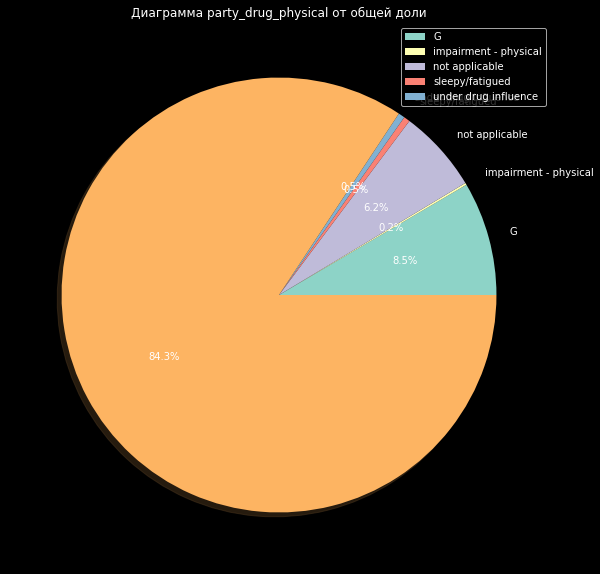

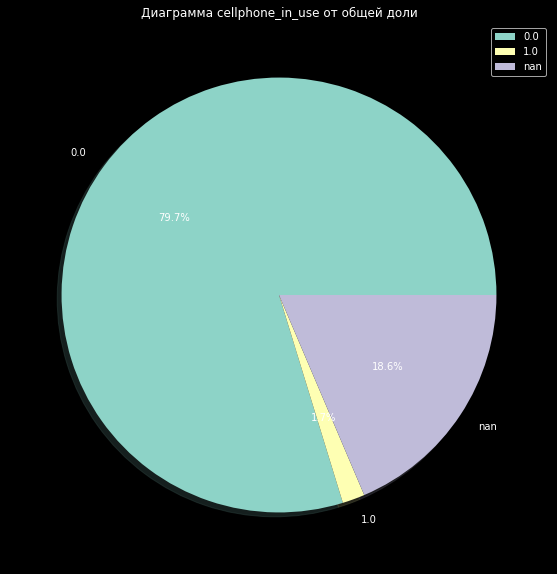

In [ ]:
for colum in parties_cat_col:
    fig, ax = plt.subplots(figsize=(12, 10))
    query = """
        SELECT
            {colum},
            COUNT(*) AS count,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM parties) AS percentage
        FROM parties
        GROUP BY {colum}
    """
    x = pd.read_sql_query(query.format(colum=colum), con=engine)
    labels = x[colum]
    x = x['percentage']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()
    print()

-Значения 'party_type'(тип участника ДТП) в основном ~90% случаев это другая машина, реже в ~6.3% road bumper (отбойник), остальные типы участников распределенны +- равномерно

-Значения 'at_fault'(виновность участника ДТП) целевой признак, чуть чаще признают участника невиновным в ~53% случаев

-Значения 'party_sobriety'(трезвость участника ДТП) в основном участник ДТП had not been drinking (не пил) в ~80% случаев, 8.7% случаев impairment unknown (состояние неизвестно), 6.3% not applicable (не применимо), 4.2% had been drinking, under influence (пил, находится в состоянии алкогольного опьянения), остальные состояния в менее 1% случаев встречаются

-Значения 'party_drug_physical'(состояние участника ДТП) в 53.9% случаев состояние G (состояние неизвестно), 39.2% случаев not applicable (не применимо),
остальные состояния встречаются +- равномерно в 2-3% случаев

-Значения 'cellphone_in_use'(использовался ли телефон во время вождения) в основном телефон не использовался, 98% случаев

0     1399990
1     1125221
2      177996
3       37688
4        8295
5        2079
6         631
7         245
8         105
9          58
10         29
11         21
12         14
13          7
14          5
15          3
16          3
17          3
18          3
19          3
20          3
21          1
22          1
23          1
24          1
25          1
26          1
Name: count, dtype: int64


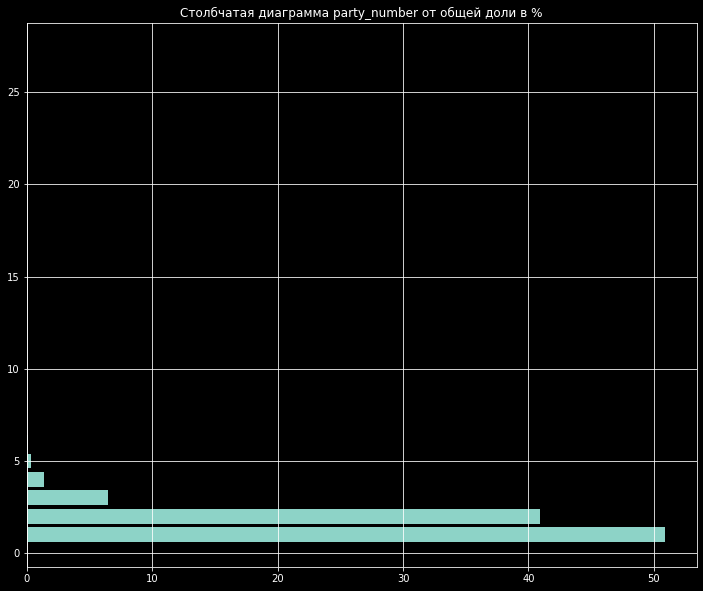

In [ ]:
for colum in parties_cat_col_much:
    query = """
        SELECT
            {colum},
            COUNT(*) AS count,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM parties) AS percentage
        FROM parties
        GROUP BY {colum}
    """
    x = pd.read_sql_query(query.format(colum=colum), con=engine)
    labels = x[colum]
    cnt = x['count']
    x = x['percentage']
    print(cnt)
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.barh(labels, x)
    plt.title('Cтолбчатая диаграмма '+ colum +' от общей доли в %')
    plt.grid(True)
    plt.show()
    print()

-Значения 'party_number'(номер участника ДТП) идентично как в таблице vehicles, наблюдаем что в большинстве случаев ДТП учавствуют 2-е, ~80% случаев. Примерно в 10% случаев один участник ДТП

#### Кол-ые признаки

   min  max      mean        std    count  null_count
0    0  105  38.74724  16.378511  2347006     2752408


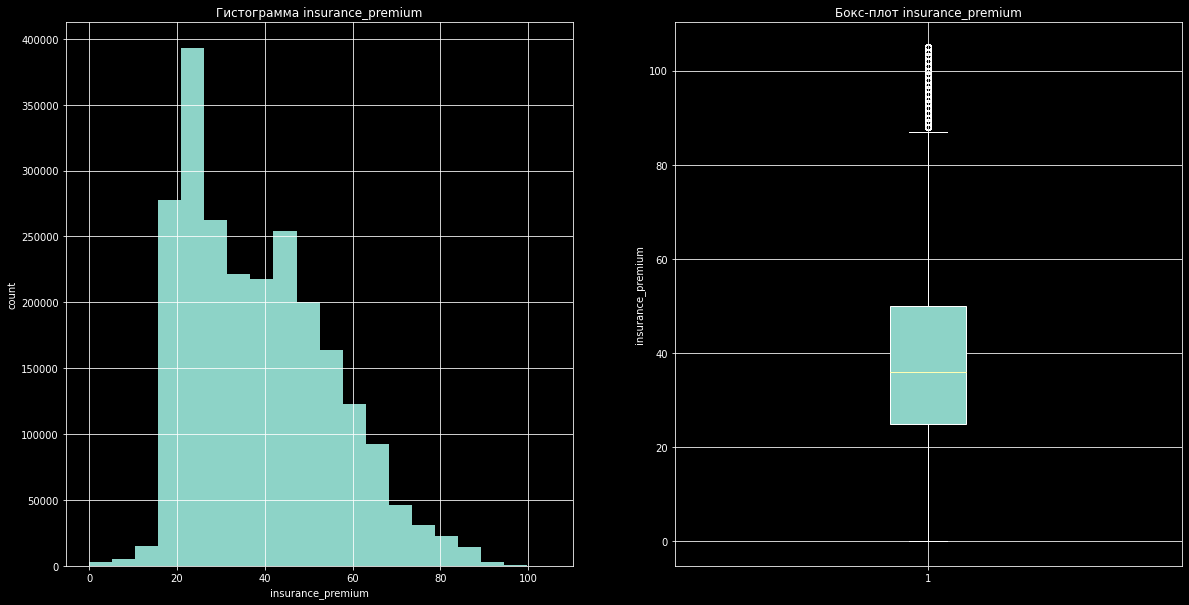

In [ ]:
for colum in parties_num_col:
    query = """
        SELECT
            MIN({colum}) AS min,
            MAX({colum}) AS max,
            AVG({colum}) AS mean,
            STDDEV({colum}) AS std,
            COUNT({colum}) AS count,
            COUNT(CASE WHEN {colum} IS NULL THEN 1 ELSE 0 END) AS null_count
        FROM parties
    """
    stats = pd.read_sql_query(query.format(colum=colum), con=engine)
    print(stats)

    if stats['null_count'].iloc[0] != 0:
        query = """
            SELECT
                {colum}
            FROM parties
            WHERE {colum} IS NOT NULL
        """
        values = pd.read_sql_query(query.format(colum=colum), con=engine)
        values = values.fillna(values.mean())
    else:
        query = """
            SELECT
                {colum}
            FROM parties
        """
        values = pd.read_sql_query(query.format(colum=colum), con=engine)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].hist(values, bins=20)
    ax[0].set_title('Гистограмма ' + colum)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].grid(True)

    ax[1].boxplot(values, patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

-**'insurance_premium'**(страховая премия в тысячах долларов США) напоминает нормальное распределение смещенное к левому краю, разброс варьируется от 0 до 105, в среднем 38.7

Присутсвуют слегка выбивающиеся значения по правому краю распределения

### Таблица collisions

In [ ]:
head = """
    SELECT *
    FROM collisions
    LIMIT 5
"""
head_ = pd.read_sql_query(head, con=engine)
print(head_)

   case_id county_city_location county_location  distance direction  \
0  4083072                 1942     los angeles     528.0     north   
1  4083075                 4313     santa clara       0.0      None   
2  4083073                 0109         alameda       0.0      None   
3  4083077                 0109         alameda       0.0      None   
4  4083087                 4313     santa clara       0.0      None   

   intersection weather_1 location_type collision_damage  party_count  \
0             0    cloudy       highway     small damage            2   
1             1     clear          None     small damage            1   
2             1     clear          None          scratch            2   
3             1     clear          None          scratch            2   
4             1     clear          None          scratch            2   

  primary_collision_factor   pcf_violation_category type_of_collision  \
0   vehicle code violation       unsafe lane change         s

#### Категориальные признаки

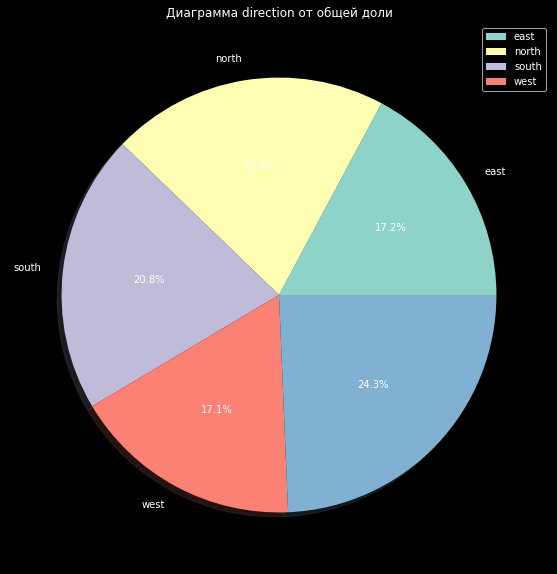

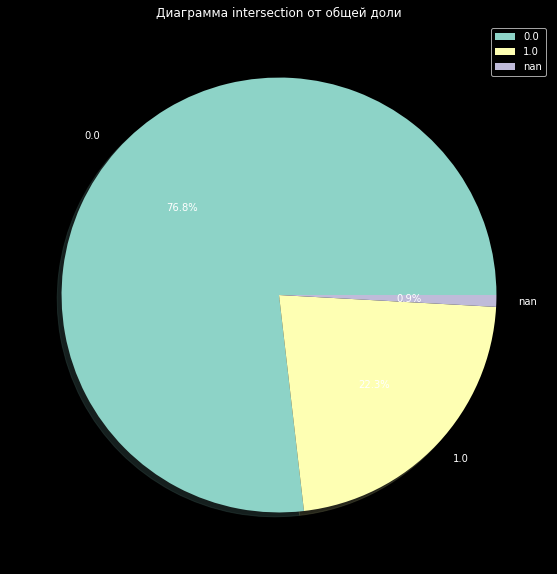

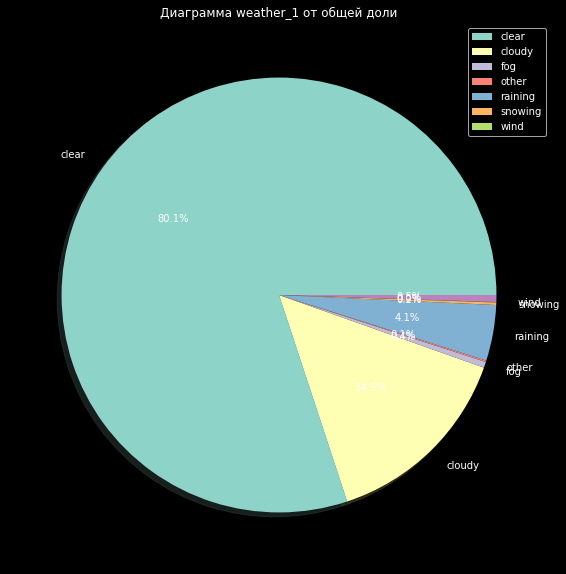

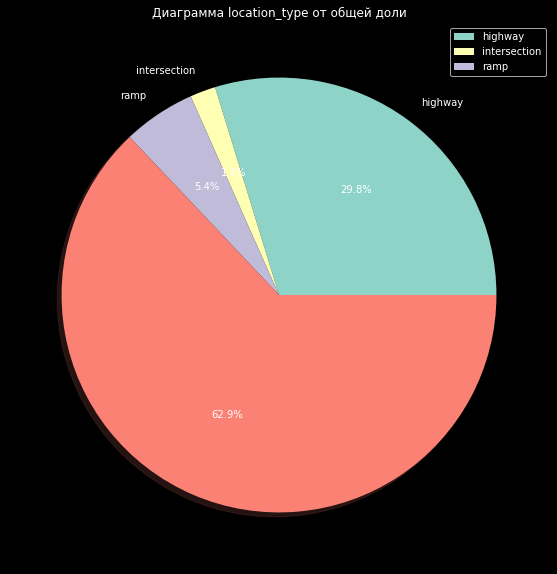

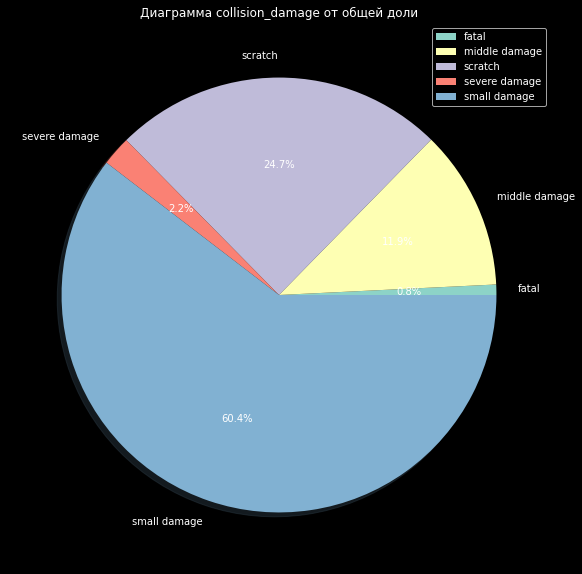

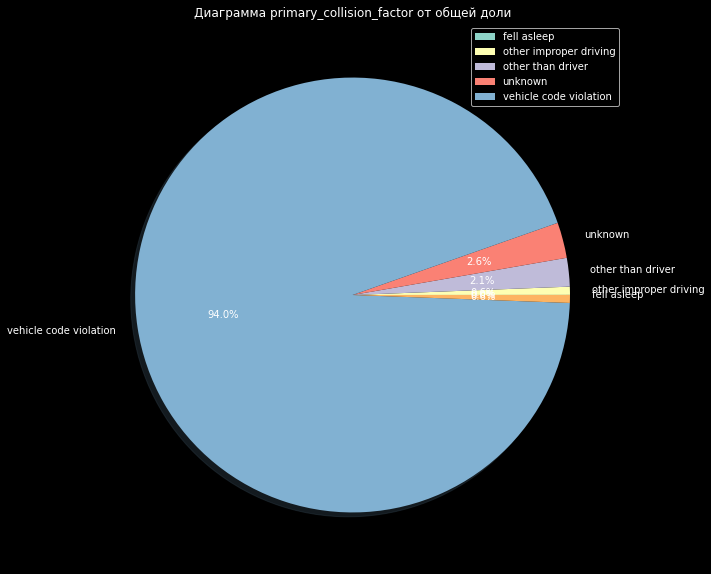

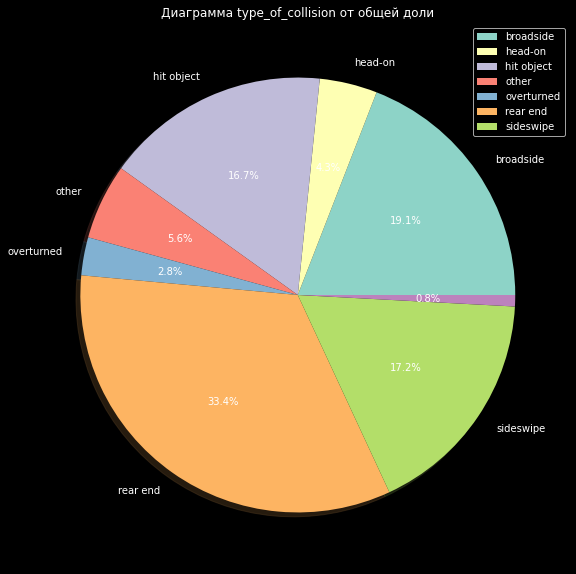

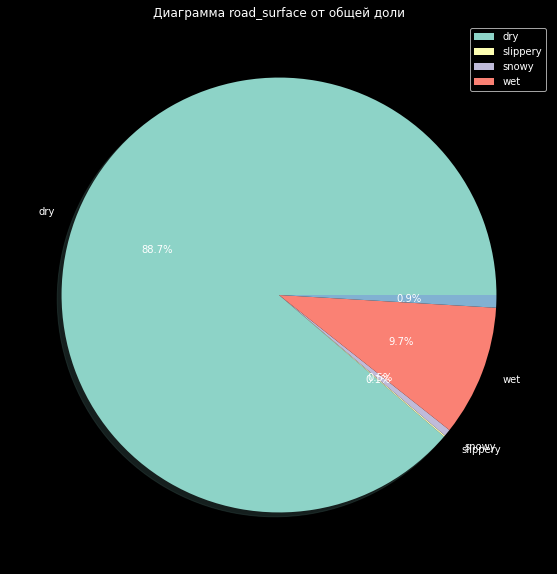

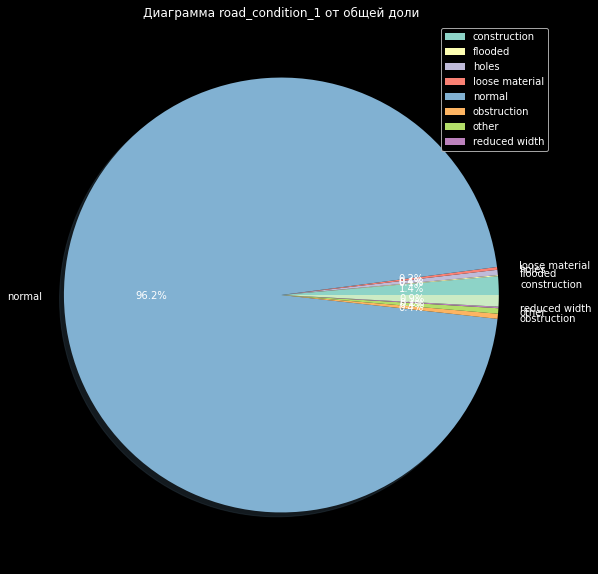

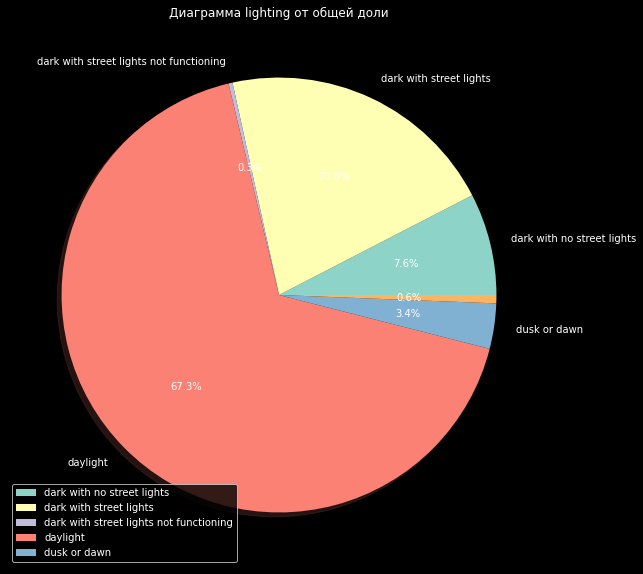

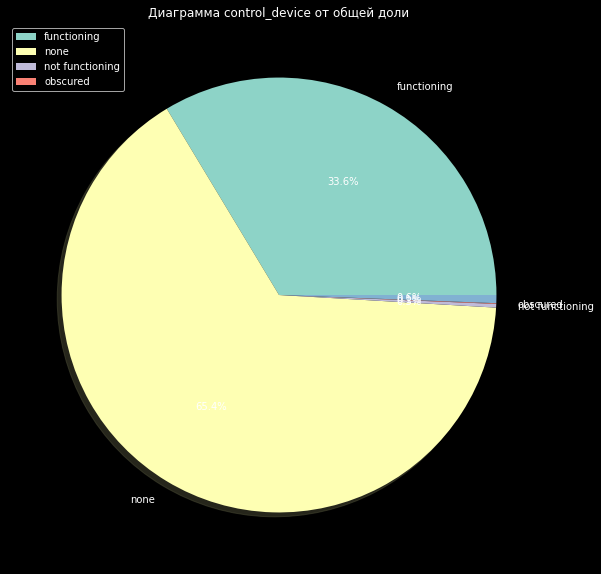

In [ ]:
for colum in collisions_cat_col:
    fig, ax = plt.subplots(figsize=(12, 10))
    query = """
        SELECT
            {colum},
            COUNT(*) AS count,
            COUNT(*) * 100.0 / (SELECT COUNT(*) FROM collisions) AS percentage
        FROM collisions
        GROUP BY {colum}
    """
    x = pd.read_sql_query(query.format(colum=colum), con=engine)
    labels = x[colum]
    x = x['percentage']
    plt.pie(x, labels=labels, autopct='%1.1f%%', shadow=True)
    plt.legend(loc="best")
    plt.title('Диаграмма '+ colum +' от общей доли')
    plt.show()
    print()

-Значения 'direction'(направление движения на перекрестке) чуть чаще в данных встречается направления north (север) и south (юг) ~27.4%, реже направления east (восток) и west (запад) в ~22.6% случаев

-Значения 'intersection'(является ли место ДТП перекрестком) в большинстве случаев место ДТП не являлось перекрестком ~77.5%

-Значения 'weather_1'(погода) чаще вего погода была (ясная) clear ~80.5% случаев, cloudy(облачно) встречается ~15% случаев, (дождь) raininng в 4.2% случаев. Остальные погодные условия встречаются в ~0.3% случаев

-Значения 'location_type'(тип дороги) в большинстве случаев дорога highway (шоссе) 80.3%, реже встречается ramp(подъем) 14.6% случаев, intersection(перекресток) в остальных ~5%

-Значения 'collision_damage'(серьезность ДТП) чаще ДТП сопровождают (отдельный элемент под замену) small damage 60.4% случаев, (царапина) scratch встречаются в 24.7%, в ~13% случаев ДТП приводит к middle damage (средний ремонт), в 2.2% severge damage (серьезный ремонт) и в 0.8% fatal (не подлежит восстановлению)

-Значения 'primary_collision_factor'(основная причина ДТП) в 94.6% случаев причиной является vehicle code violation (нарушение ПДД), остальные причины встречаются редко +- распределенны равномерно

-Значения 'type_of_collision'(тип столкновения) 33.6% случаев rear end  (столкновение с задней частью автомобиля), 16-19% ДТП это broadside (боковой удар), hit object (столкновение с объектом), sideswipe (задевание стороной). Остальные столкновения встречаются в 3-6% случаев

-Значения 'road_surface'(состояние дороги) ~90% это дорога dry(сухая), в ~10% wet(влажная). Другие состояния дорог имеют незначительную долю в данных

-Значения 'road_condition_1'(состояние дорожного полотна) в 97% normal(нормальное), 1.4% construction (в состоянии строительства). Остальные состояния полотна встречаются в ~0.3% случаев

-Значения 'lighting'(освещенность) в 67.7% случаев daylight (дневной свет), ~20% dark with street lights (темно и есть уличное освещение), 7.6% dark with no street lights (темно и нет уличного совещения), 3.4% dusk or dawn (закат или рассвет), 0.3% dark with street lights not functioning (темно и есть неработающее уличное освещение)

-Значения 'control_device'(состояние устройств управления) в 99% устр-ва управления functioning (функционируют)



0      64553
1        290
2       1741
3       6394
4       1870
5       1086
6      31492
7       1207
8       5562
9      26476
10      1064
11      6830
12      3955
13      1029
14     29027
15      4672
16      2122
17      1448
18    433809
19      5468
20      9601
21       810
22      3852
23     10858
24       407
25       945
26     17861
27      5295
28      4121
29    118276
30     13481
31       854
32     69328
33     56988
34      1842
35     79382
36     78391
37     20656
38     27263
39     11505
40     24591
41     19207
42     50786
43     11570
44      7742
45       222
46      1778
47     14412
48     17686
49     20103
50      3281
51      2565
52       677
53     19307
54      2546
55     32335
56      7054
57      2327
Name: count, dtype: int64


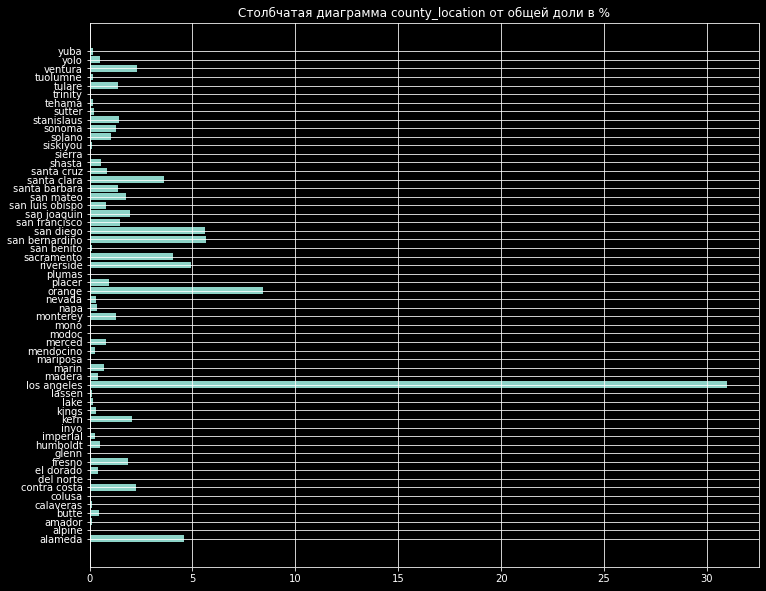


0     158291
1        303
2     110476
3        117
4      30033
5       1746
6        752
7      12136
8     238987
9        209
10      1747
11     13851
12      8470
13     29780
14         2
15     15739
16     15392
17    438439
18     72751
19     39558
20     93962
21     55674
22     33631
23     27954
Name: count, dtype: int64


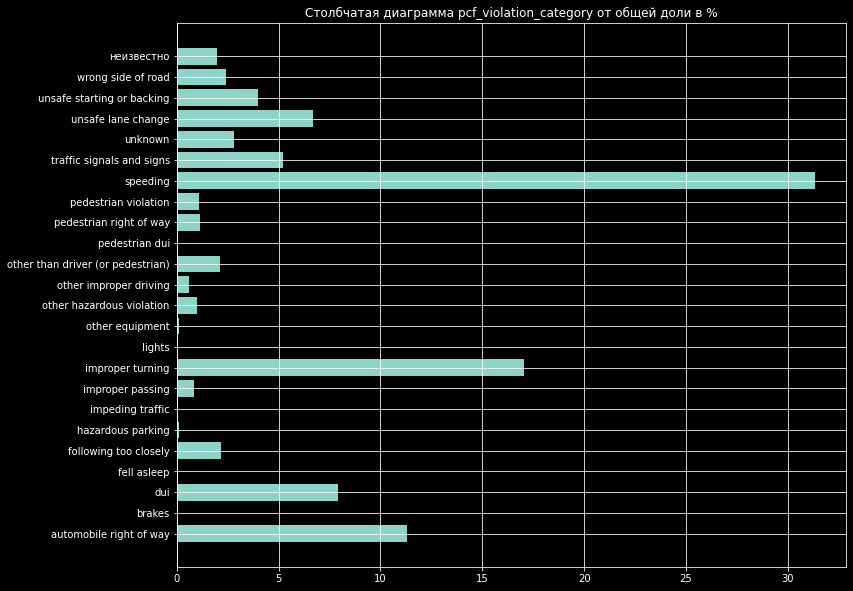


0      6191
1     41711
2    226942
3      9831
4     39905
5    891079
6     72677
7    104423
8       422
9      6819
Name: count, dtype: int64


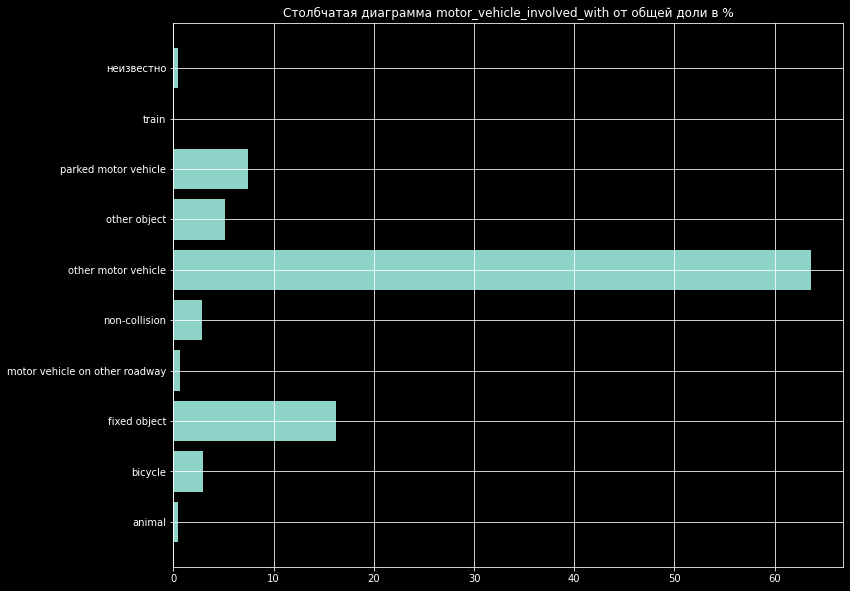

In [ ]:
for colum in collisions_cat_col_much:
    if colum not in ['county_city_location', 'party_count']:
        query = """
            SELECT
                COALESCE({colum}, 'неизвестно') AS {colum},
                COUNT(*) AS count,
                COUNT(*) * 100.0 / (SELECT COUNT(*) FROM collisions) AS percentage
            FROM collisions
            GROUP BY COALESCE({colum}, 'неизвестно')
        """
        x = pd.read_sql_query(query.format(colum=colum), con=engine)
        labels = x[colum]
        cnt = x['count']
        x = x['percentage']
        print(cnt)
        fig, ax = plt.subplots(figsize=(12, 10))
        plt.barh(labels, x)
        plt.title('Cтолбчатая диаграмма '+ colum +' от общей доли в %')
        plt.grid(True)
        plt.show()
        print()

-Значения 'county_location'(название географического района, где произошло ДТП) ~31% ДТП произошло в районе los angeles, ~9% в районе orange. Остальные районы встречаются в 5% и менее наблюдений

-Значения 'pcf_violation_category'(категория нарушения, приведшего к ДТП) ~32% это speeding (превышение скорости), ~17% improper passing (неправильное движение), ~11% automobile right of way (автомобильное право проезда). Остальные категории встречаются в 7% и менее наблюдений

-Значения 'motor_vehicle_involved_with'(дополнительные участники ДТП) часто ~62% в ДТП доп. участником выступает other motor vehicle (другой автомобиль), в ~18% fixed object (неподвижный объект). Другие участники встречаются реже


#### Кол-ые признаки

   min        max        mean           std    count  null_count
0  0.0  8363520.0  660.711516  11785.785065  1400000     1400000


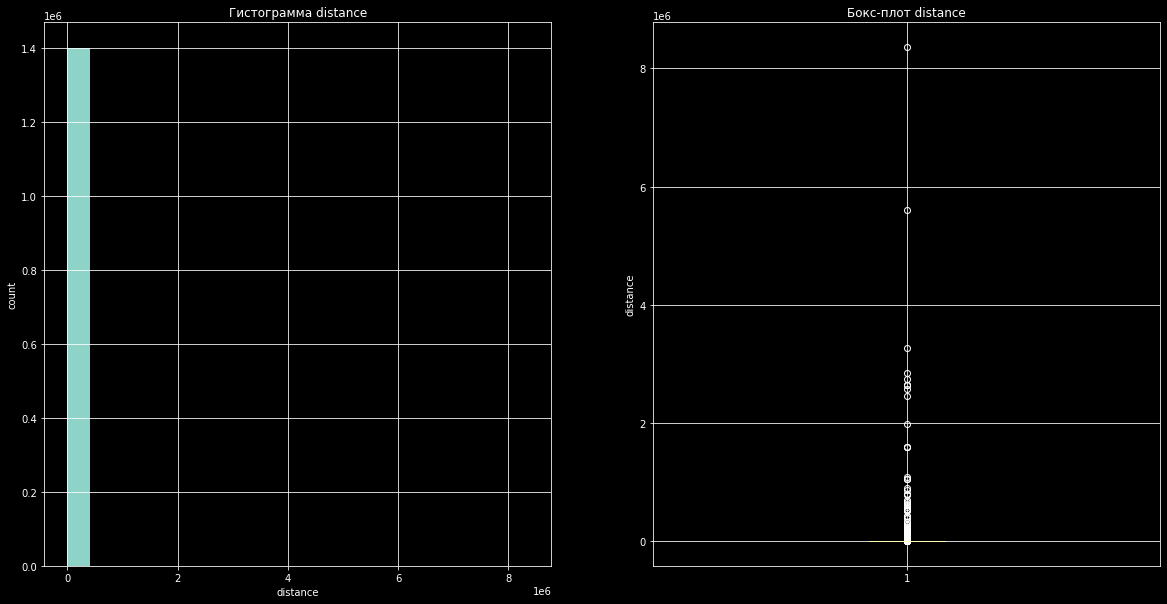

In [ ]:
for colum in collisions_num_col:
    query = """
        SELECT
            MIN({colum}) AS min,
            MAX({colum}) AS max,
            AVG({colum}) AS mean,
            STDDEV({colum}) AS std,
            COUNT({colum}) AS count,
            COUNT(CASE WHEN {colum} IS NULL THEN 1 ELSE 0 END) AS null_count
        FROM collisions
    """
    stats = pd.read_sql_query(query.format(colum=colum), con=engine)
    print(stats)

    if stats['null_count'].iloc[0] != 0:
        query = """
            SELECT
                {colum}
            FROM collisions
            WHERE {colum} IS NOT NULL
        """
        values = pd.read_sql_query(query.format(colum=colum), con=engine)
        values = values.fillna(values.mean())
    else:
        query = """
            SELECT
                {colum}
            FROM collisions
        """
        values = pd.read_sql_query(query.format(colum=colum), con=engine)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ax[0].hist(values, bins=20)
    ax[0].set_title('Гистограмма ' + colum)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].grid(True)

    ax[1].boxplot(values, patch_artist=True)
    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

-**'distance'**(расстояние от главной дороги в метрах) разброс варьируется от 0 до 8363520, в среднем 660.7

Присутсвуют сильно аномальные значения по правому краю распределения

## Корреляционный анализ

Соберем данные в единую таблицу, case_id ключ присоединения

In [ ]:
query = """
    SELECT
        p.case_id,
        p.party_type,
        p.at_fault,
        p.insurance_premium,
        p.party_sobriety,
        p.party_drug_physical,
        p.cellphone_in_use,
        c.*,
        v.vehicle_type,
        v.vehicle_transmission,
        v.vehicle_age
    FROM parties p
    LEFT JOIN collisions c ON p.case_id = c.case_id
    LEFT JOIN vehicles v ON p.case_id = v.case_id
"""

# df_full = pd.read_sql_query(query, con=engine)
# print(df_full.isna().mean())

In [ ]:
# df_full.duplicated().sum()

In [ ]:
# sub = list(df_full.columns)
# sub.remove('case_id')
# df_full[sub].duplicated().sum()

76997 явных дубликата после получения сводной таблицы

In [ ]:
# df_full = df_full.drop_duplicates(sub).reset_index(drop=True)

Матрица корреляций Фик была получена на аппаратном ускорителе с большим объемом оперативной памяти

In [ ]:
# corr_phik = df_full[parties_cat_col+parties_cat_col_much+vehicles_cat_col+
#  [vehicles_cat_col_much[1]]+collisions_cat_col+collisions_cat_col_much
#                     ].phik_matrix(interval_cols = parties_num_col+collisions_num_col)
# fig, ax = plt.subplots(figsize=(30, 30))
# sns.heatmap(corr_phik, annot=True, cmap='cividis').legend = False

Наблюдаем сильную корреляцию между: 'party_type' и 'motor_vehicle_involved_with', 'party_type' и 'vehicle_type', 'party_type' и 'party_drug_physical', 'at_fault' и 'party_number', 'at_fault' и 'party_drug_physical', 'party_number' и 'party_count', 'vehicle_type' и 'motor_vehicle_involved_with', 'vehicle_type' и 'collision_damage', 'type_of_collision' и 'motor_vehicle_involved_with', 'type_of_collision' и 'pcf_violation_category' (**>0.7**)

Присутствует мультиколлинеарность между признаками 'primary_collision_factor' и 'pcf_violation_category', 'county_city_location' и 'county_location'

## Cтатистический анализ факторов ДТП

**Задача**

Выясните, в какие месяцы происходит наибольшее количество аварий.

Проанализируйте весь период наблюдений (таблица collisions).

Создайте sql-запрос;

Постройте график;

Сделайте вывод.


Проведем анализ аварий по месяцам

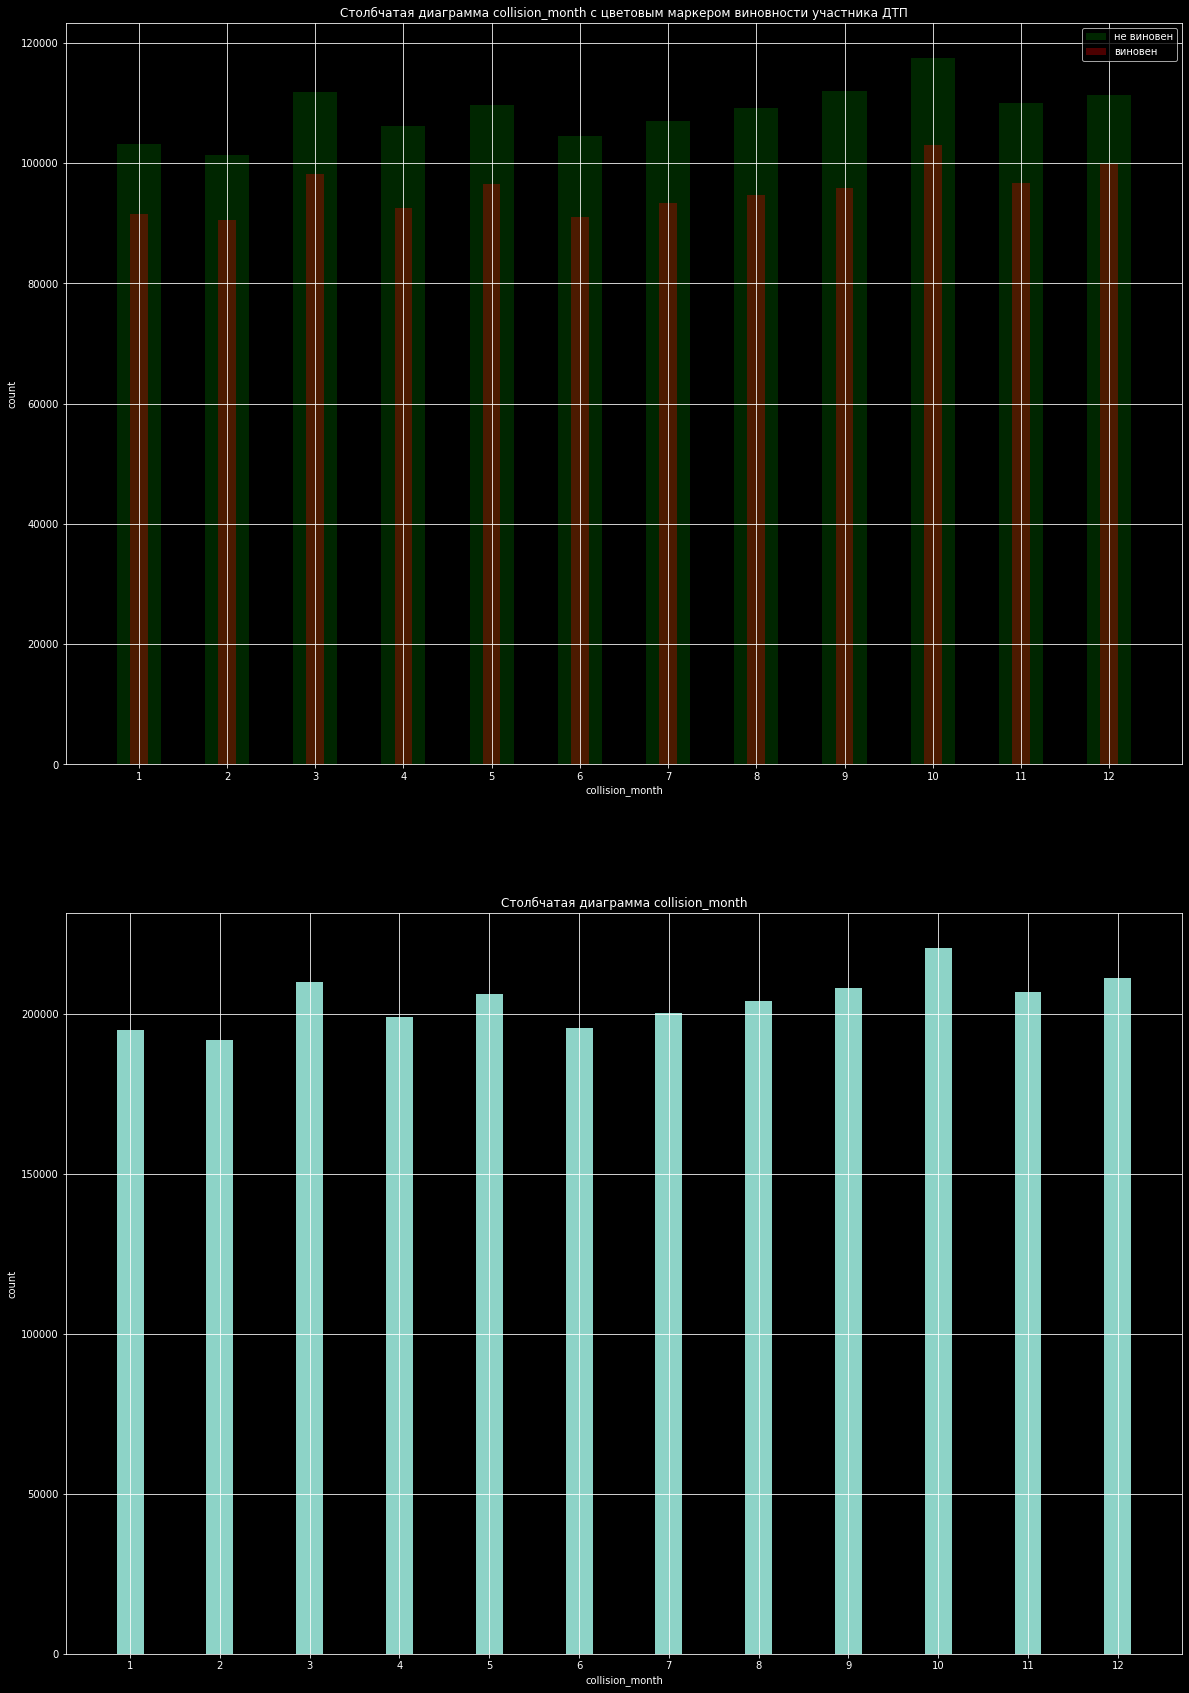

In [ ]:
query = """
SELECT
EXTRACT(MONTH FROM c.collision_date) AS collision_month,
p.at_fault,
COUNT(*) AS count
FROM parties p
LEFT JOIN collisions c ON p.case_id = c.case_id
WHERE EXTRACT(YEAR FROM c.collision_date) < 2012
GROUP BY EXTRACT(MONTH FROM c.collision_date), p.at_fault
"""
x = pd.read_sql_query(query, con=engine)

query = """
SELECT
EXTRACT(MONTH FROM c.collision_date) AS collision_month,
COUNT(*) AS count
FROM parties p
LEFT JOIN collisions c ON p.case_id = c.case_id
WHERE EXTRACT(YEAR FROM c.collision_date) < 2012
GROUP BY EXTRACT(MONTH FROM c.collision_date)
"""
y = pd.read_sql_query(query, con=engine)

xticks = [_ for _ in range(1, 13)]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 30))

for color, row, leg, width in (['green', 0, 'не виновен', 0.5],
                                ['red', 1, 'виновен', 0.2]):
    x_fault = x[x['at_fault'] == row]
    ax[0].bar(x_fault['collision_month'], x_fault['count'], alpha=0.3, color=color, width=width, label=leg)

ax[0].set_title('Столбчатая диаграмма collision_month с цветовым маркером виновности участника ДТП')
ax[0].set_xlabel('collision_month')
ax[0].set_xticks(xticks)
ax[0].set_ylabel('count')
ax[0].legend(loc="best")
ax[0].grid(True)

ax[1].bar(y['collision_month'], y['count'], width=0.3)
ax[1].set_title('Столбчатая диаграмма collision_month')
ax[1].set_xticks(xticks)
ax[1].set_xlabel('collision_month')
ax[1].set_ylabel('count')
ax[1].grid(True)

Аварии ~случаются одинаково часто, как в общем так и с учетом виновности или не виновности участника ДТП

**Задача**

Скоро состоится первое совещание вашей рабочей группы. Чтобы обсуждение было конструктивным, каждый сотрудник должен понимать данные. Для этого вы должны создать подходящие аналитические задачи и поручить их решение коллегам. Примеры задач:

Проведите анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);

Найдите самые частые причины ДТП (таблица parties).

2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы.

2.2. Пропишите порядок решения для двух задач из списка. Реализуйте его.
Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. Пример прописанного порядка:

Создайте sql-запрос;

Постройте график;

Сделайте вывод.

Шесть задач для коллег:

Проанализировать категории collision_damage, в частности интересует fatal

Проанализировать ДТП в категориях по сезонам года

party_drug_physical(состояние участника дтп) по категориям

Анализ от погоды

Анализ наблюдений со страховой премией свыше 0.9 квантиля

Анализ по кагортам виновных и не виновных участников ДТП

### Анализ категорий collision_damage

road_surface


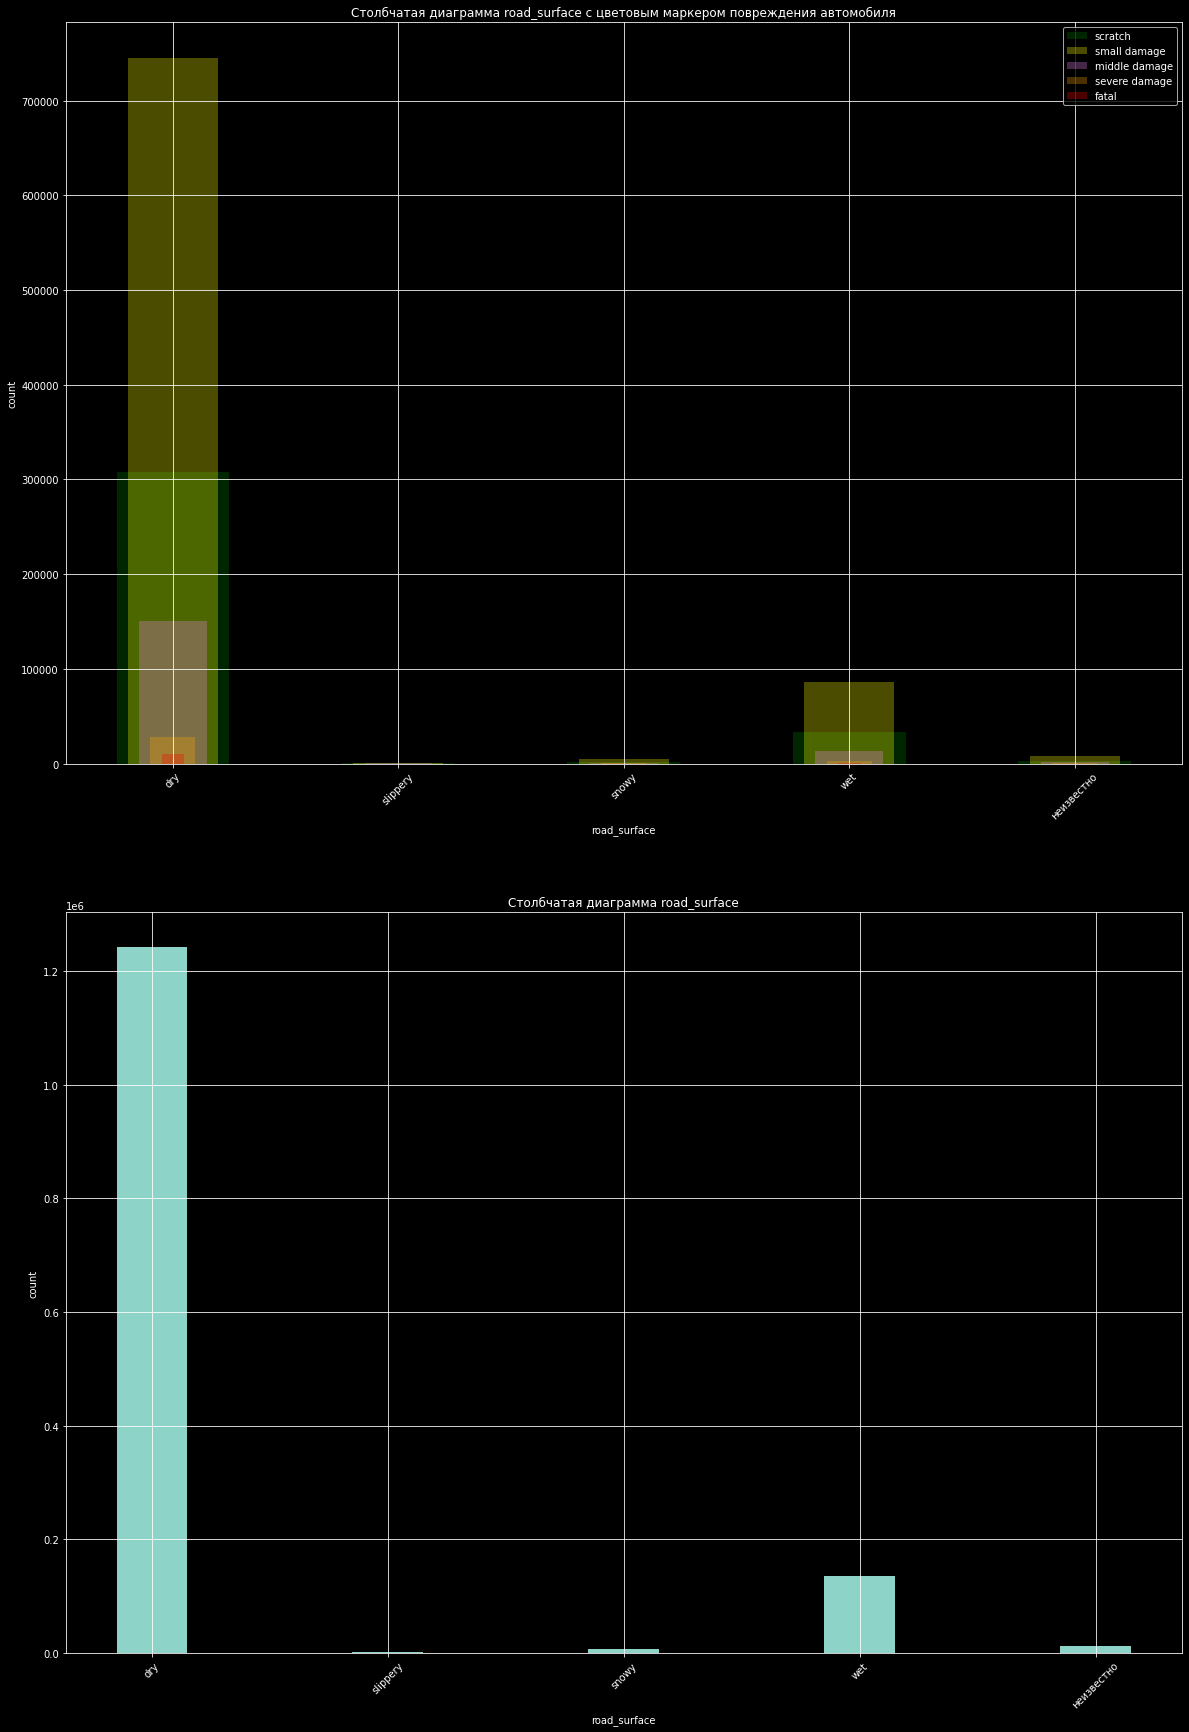

road_condition_1


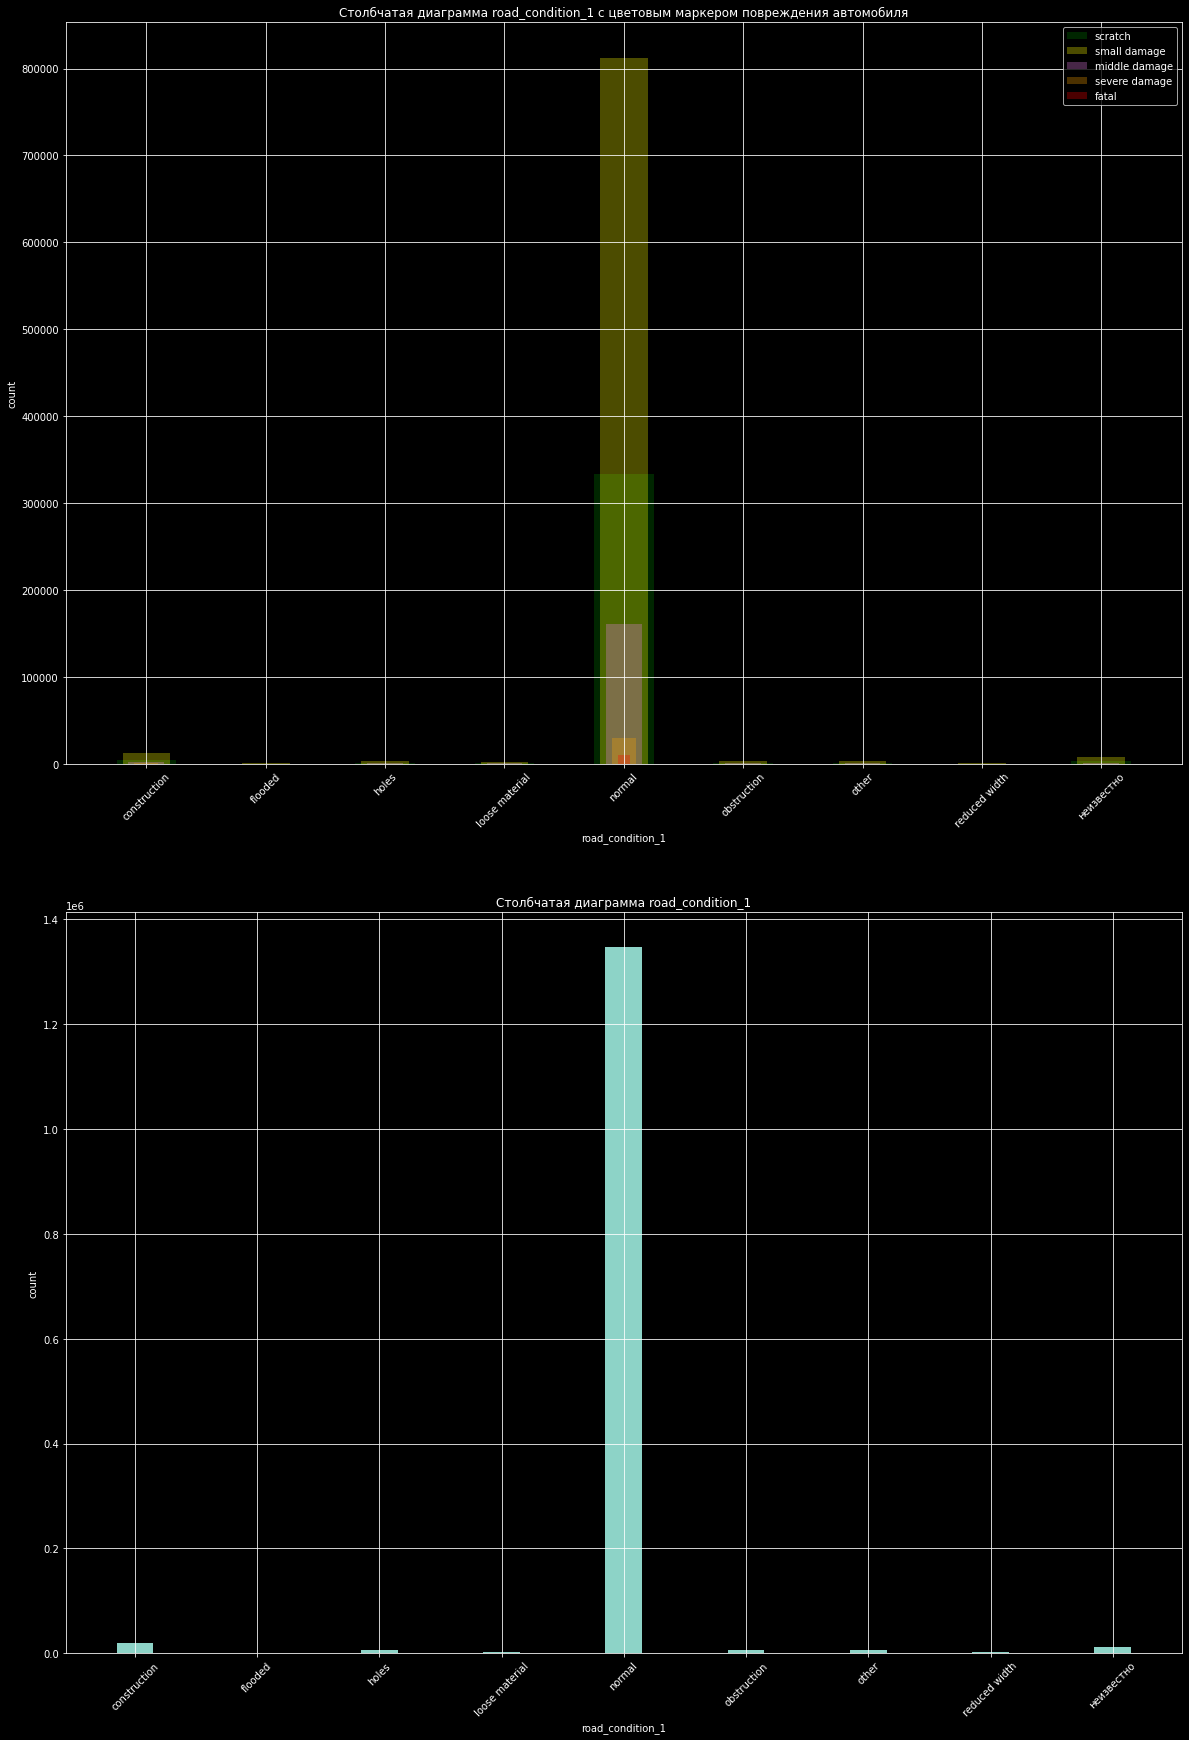

location_type


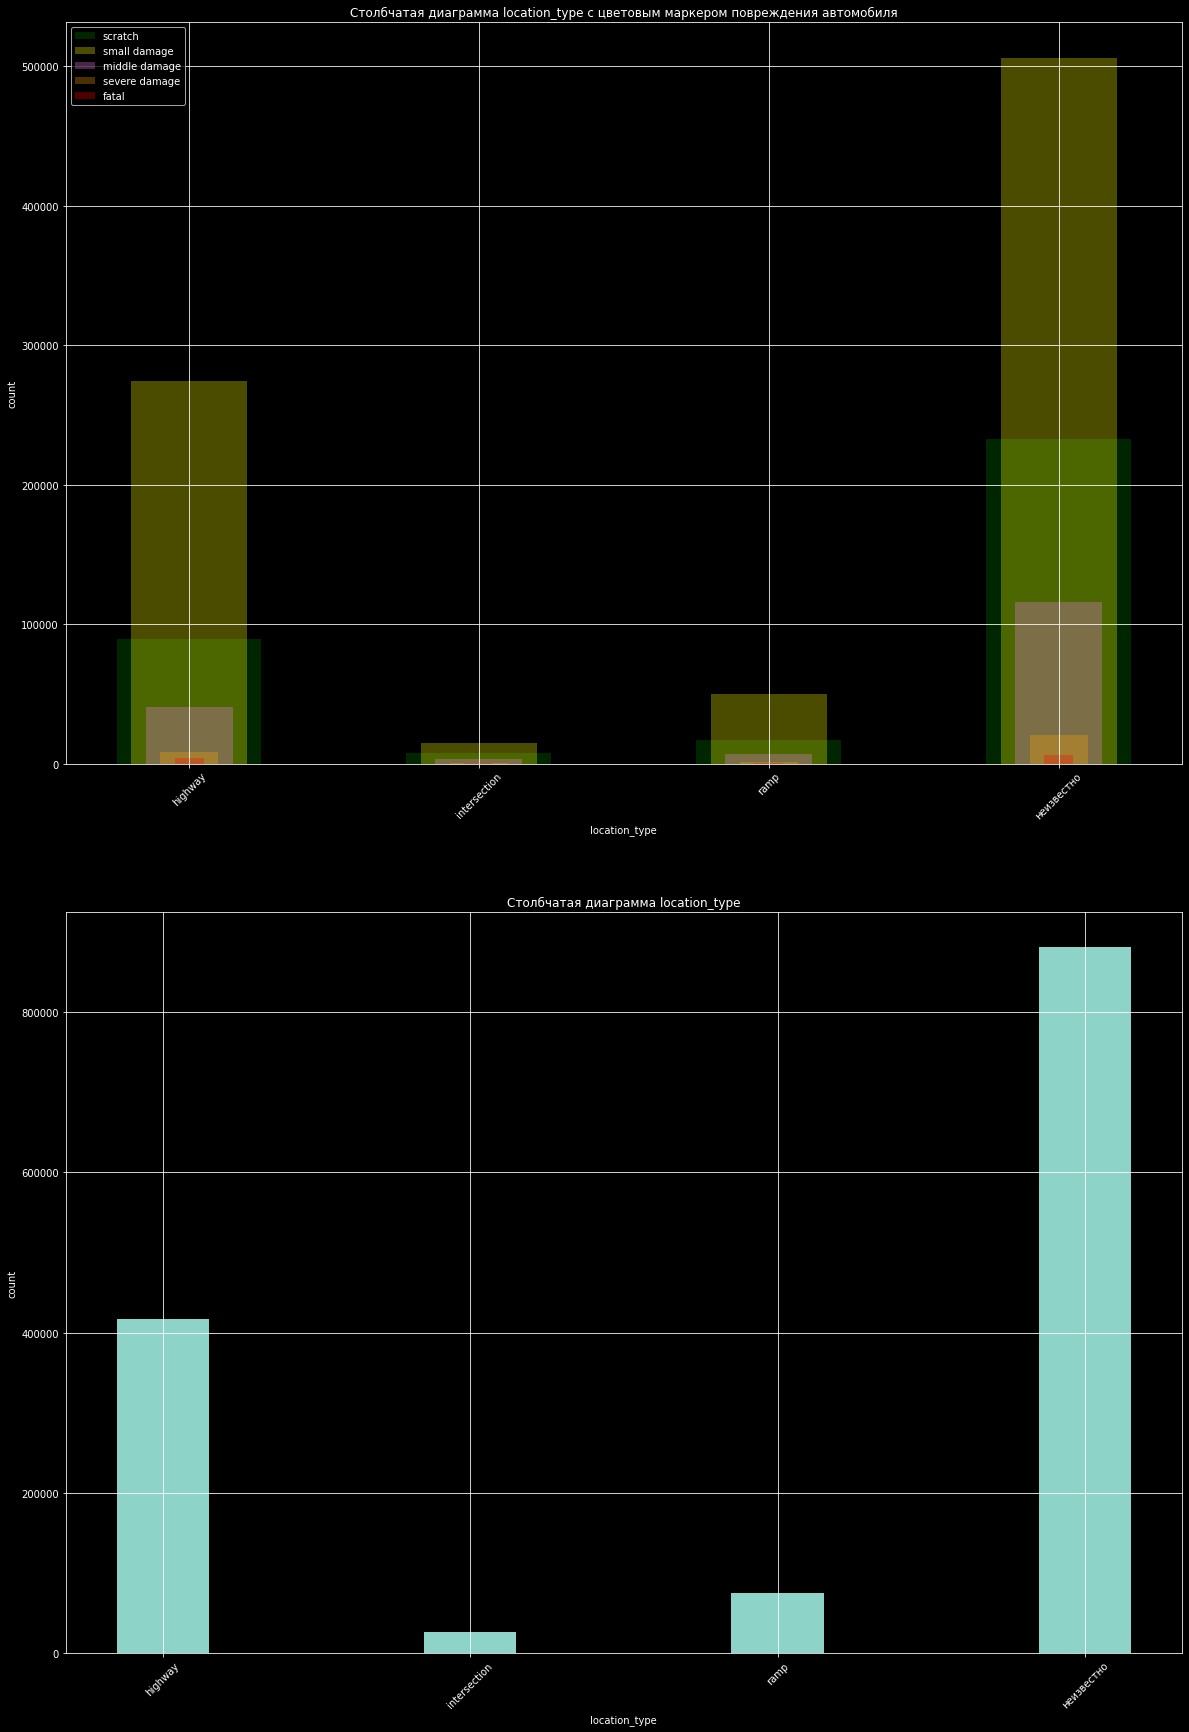

weather_1


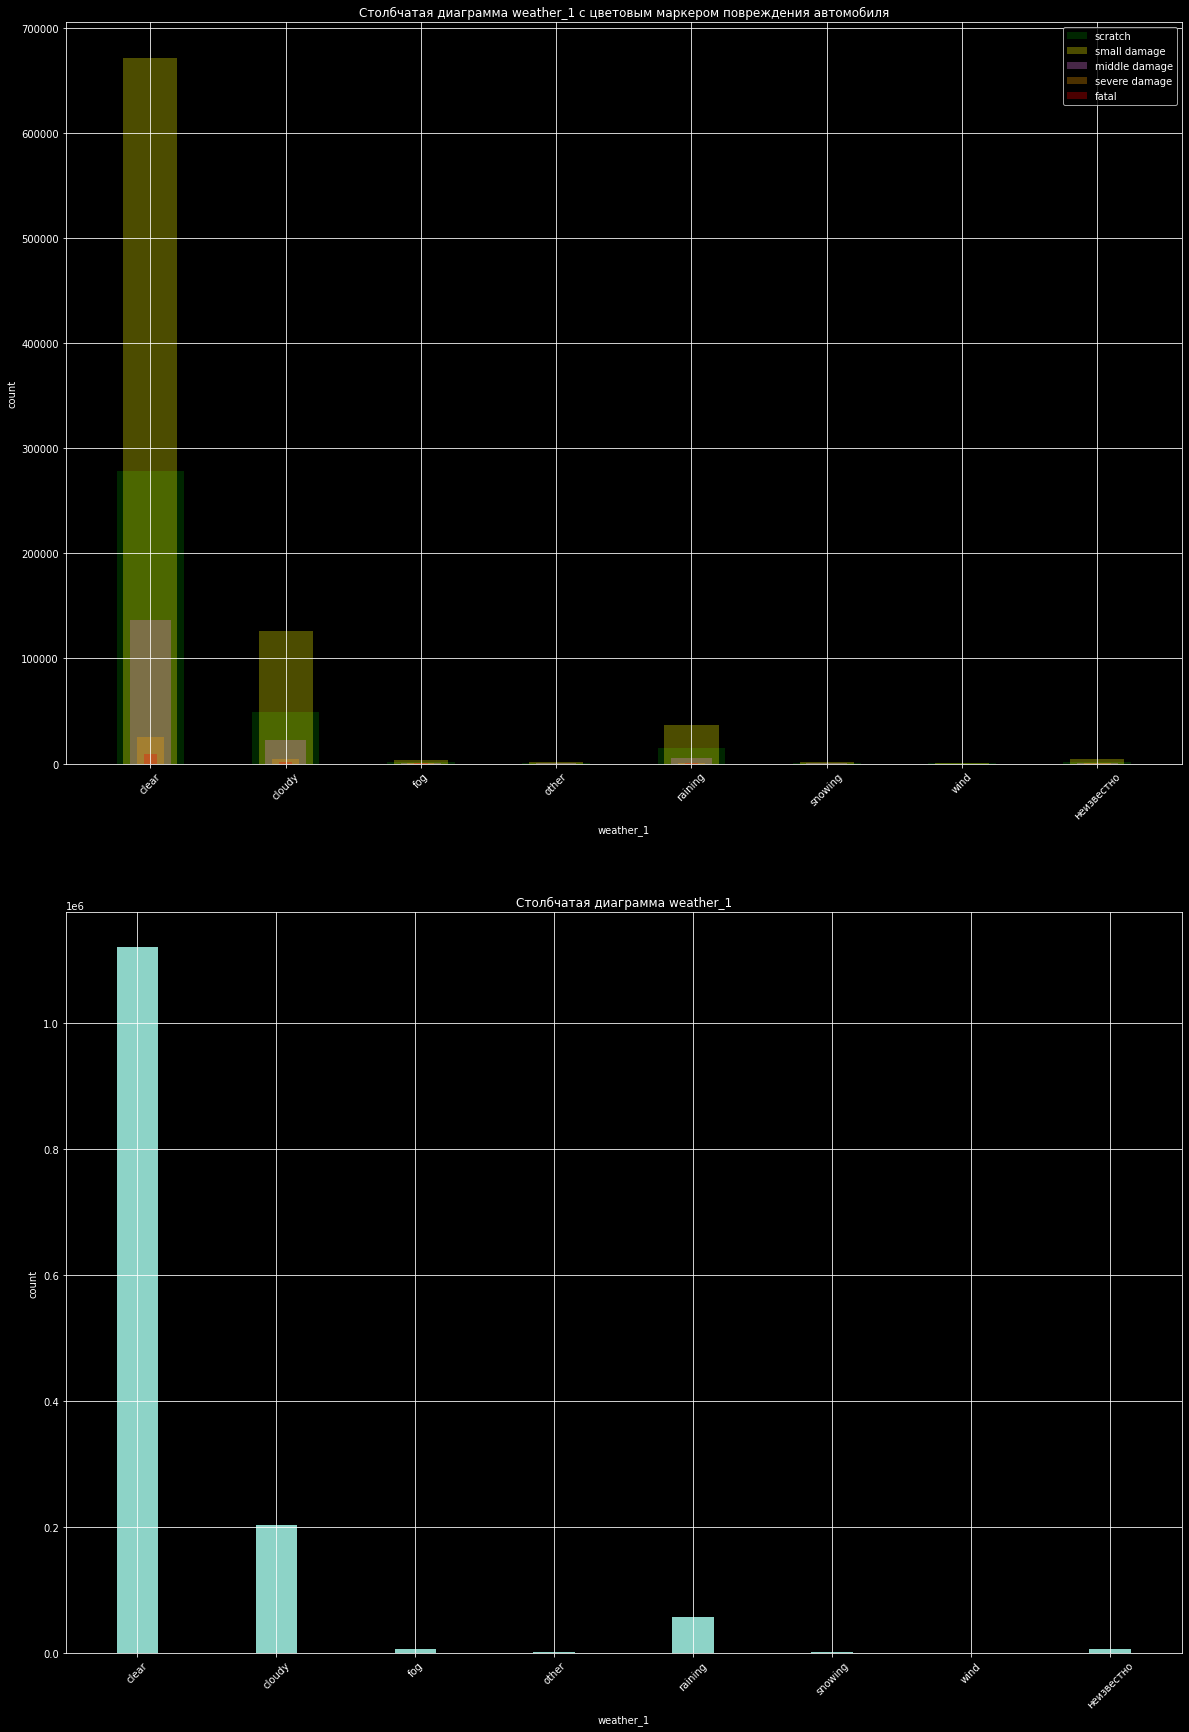

lighting


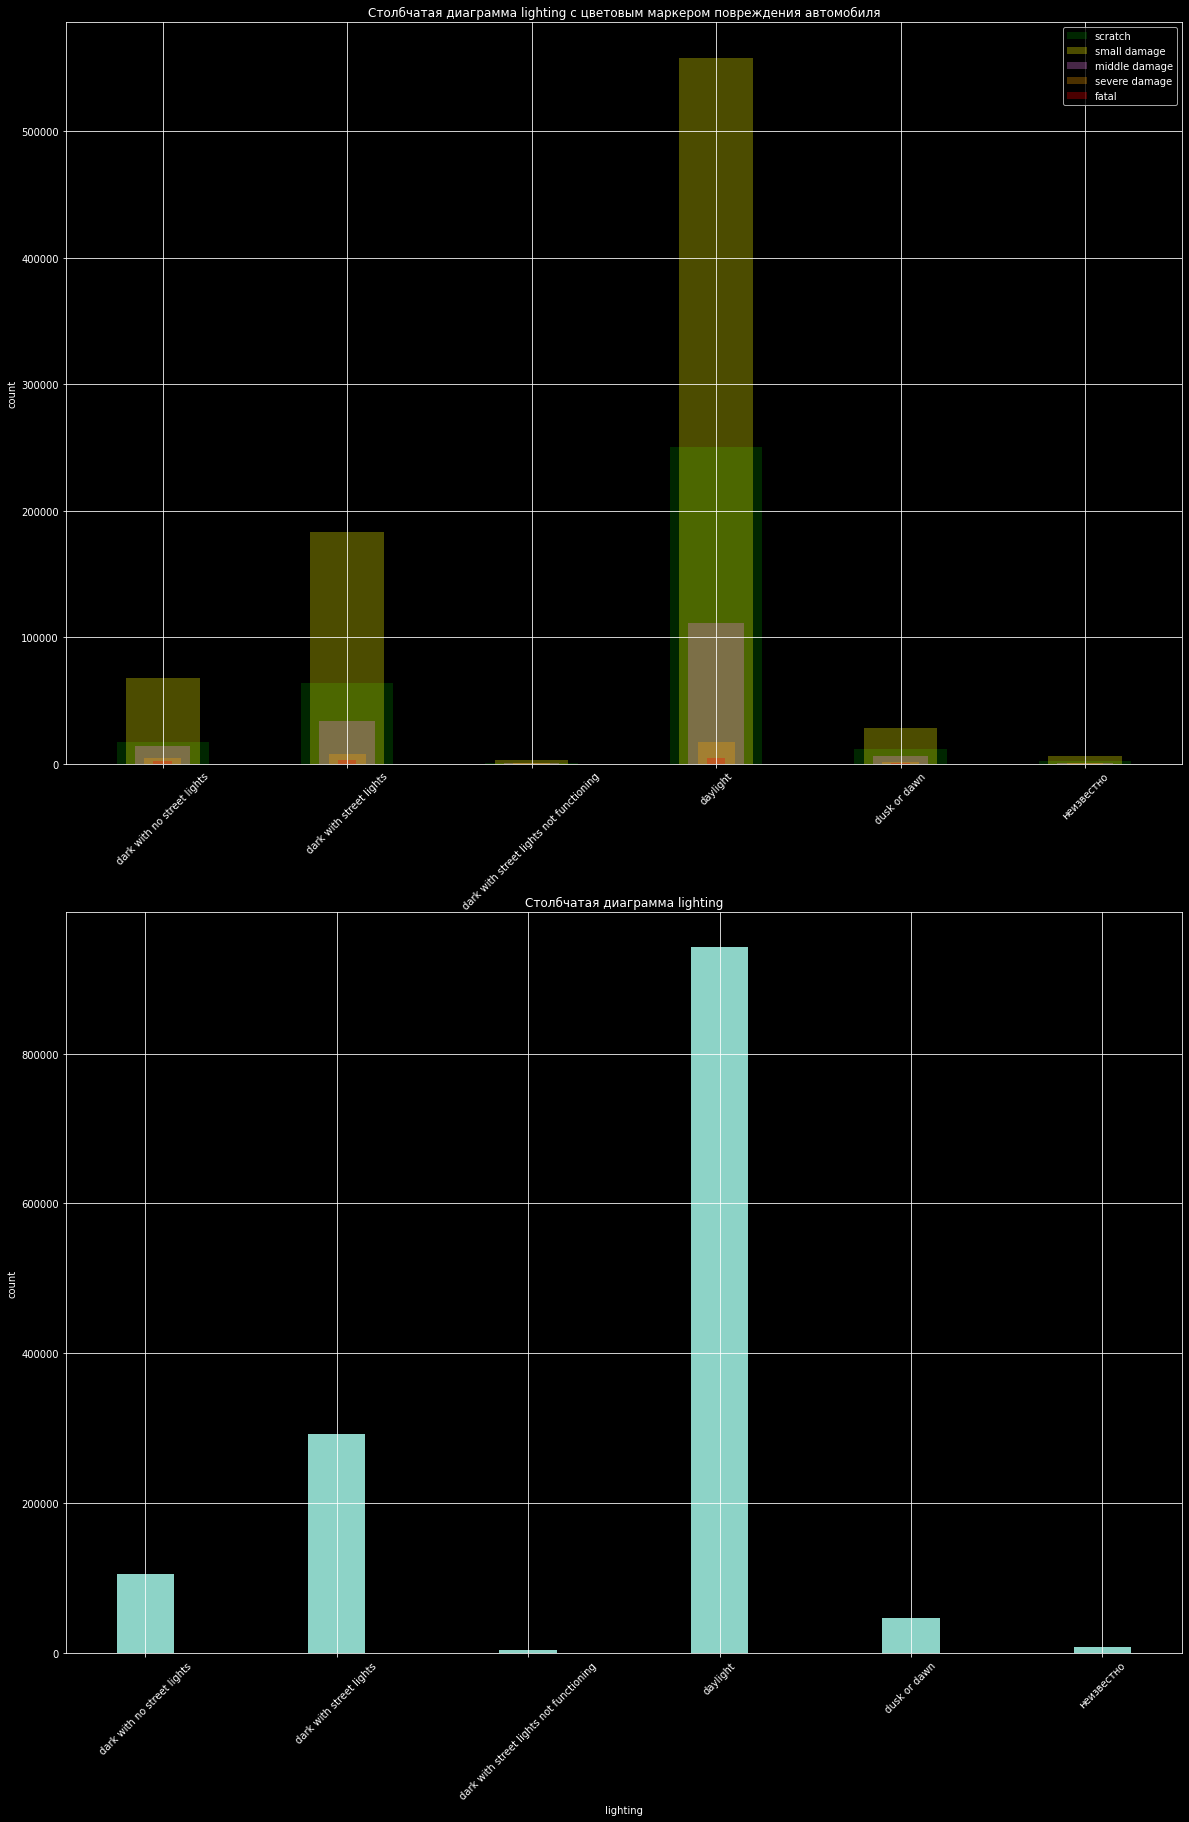

direction


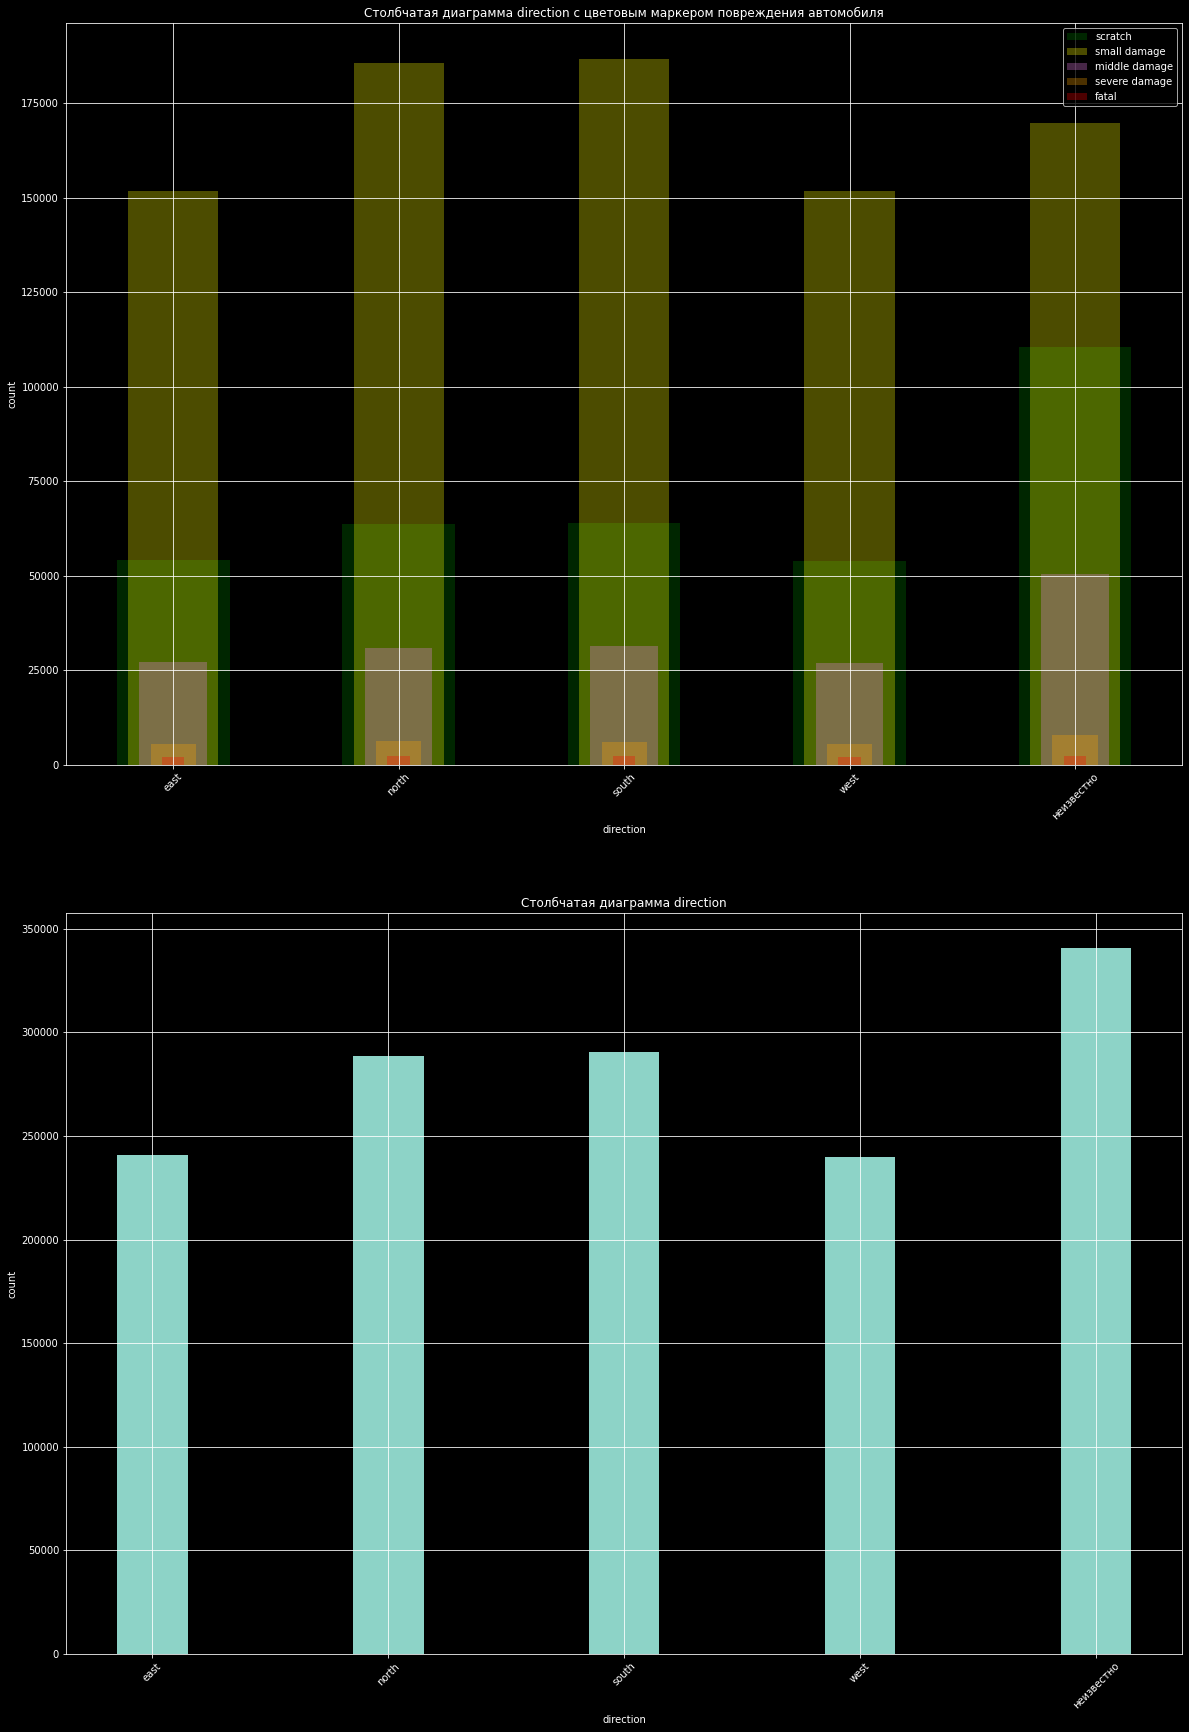

control_device


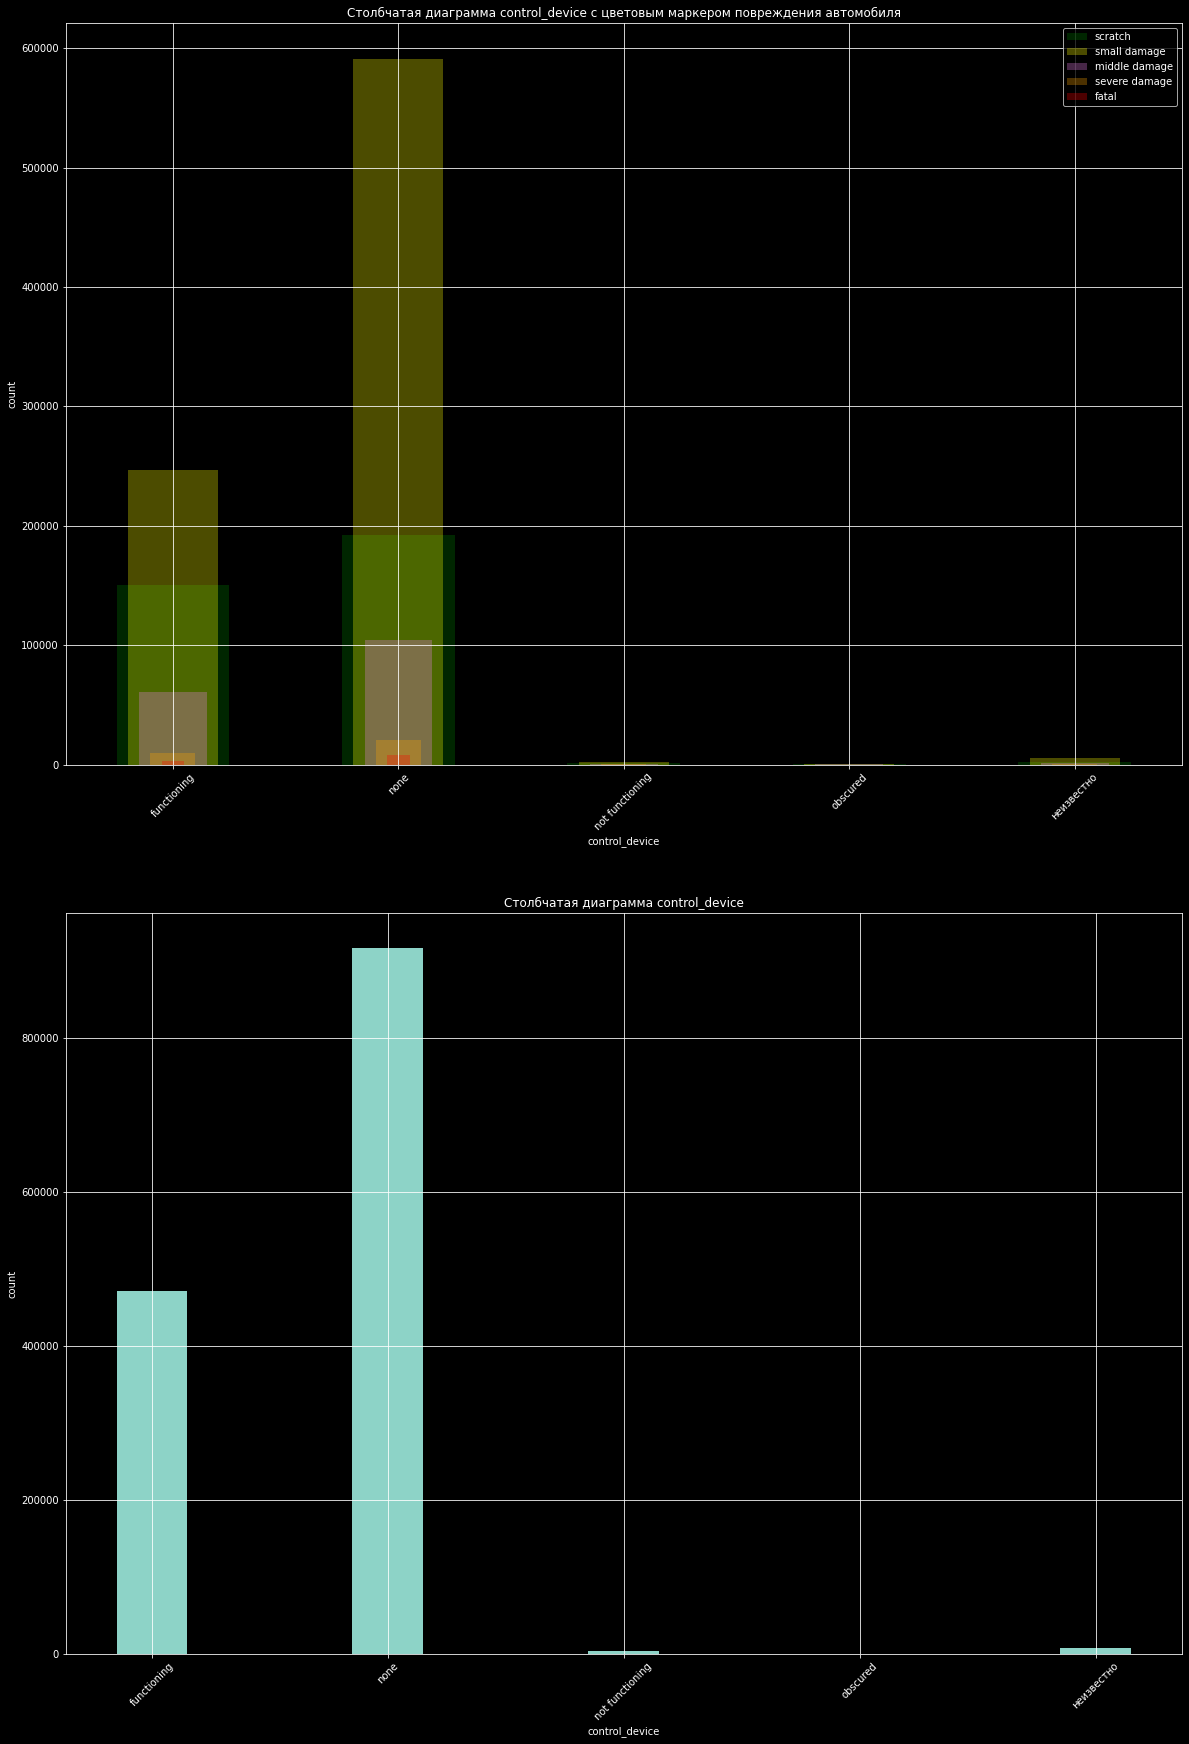

motor_vehicle_involved_with


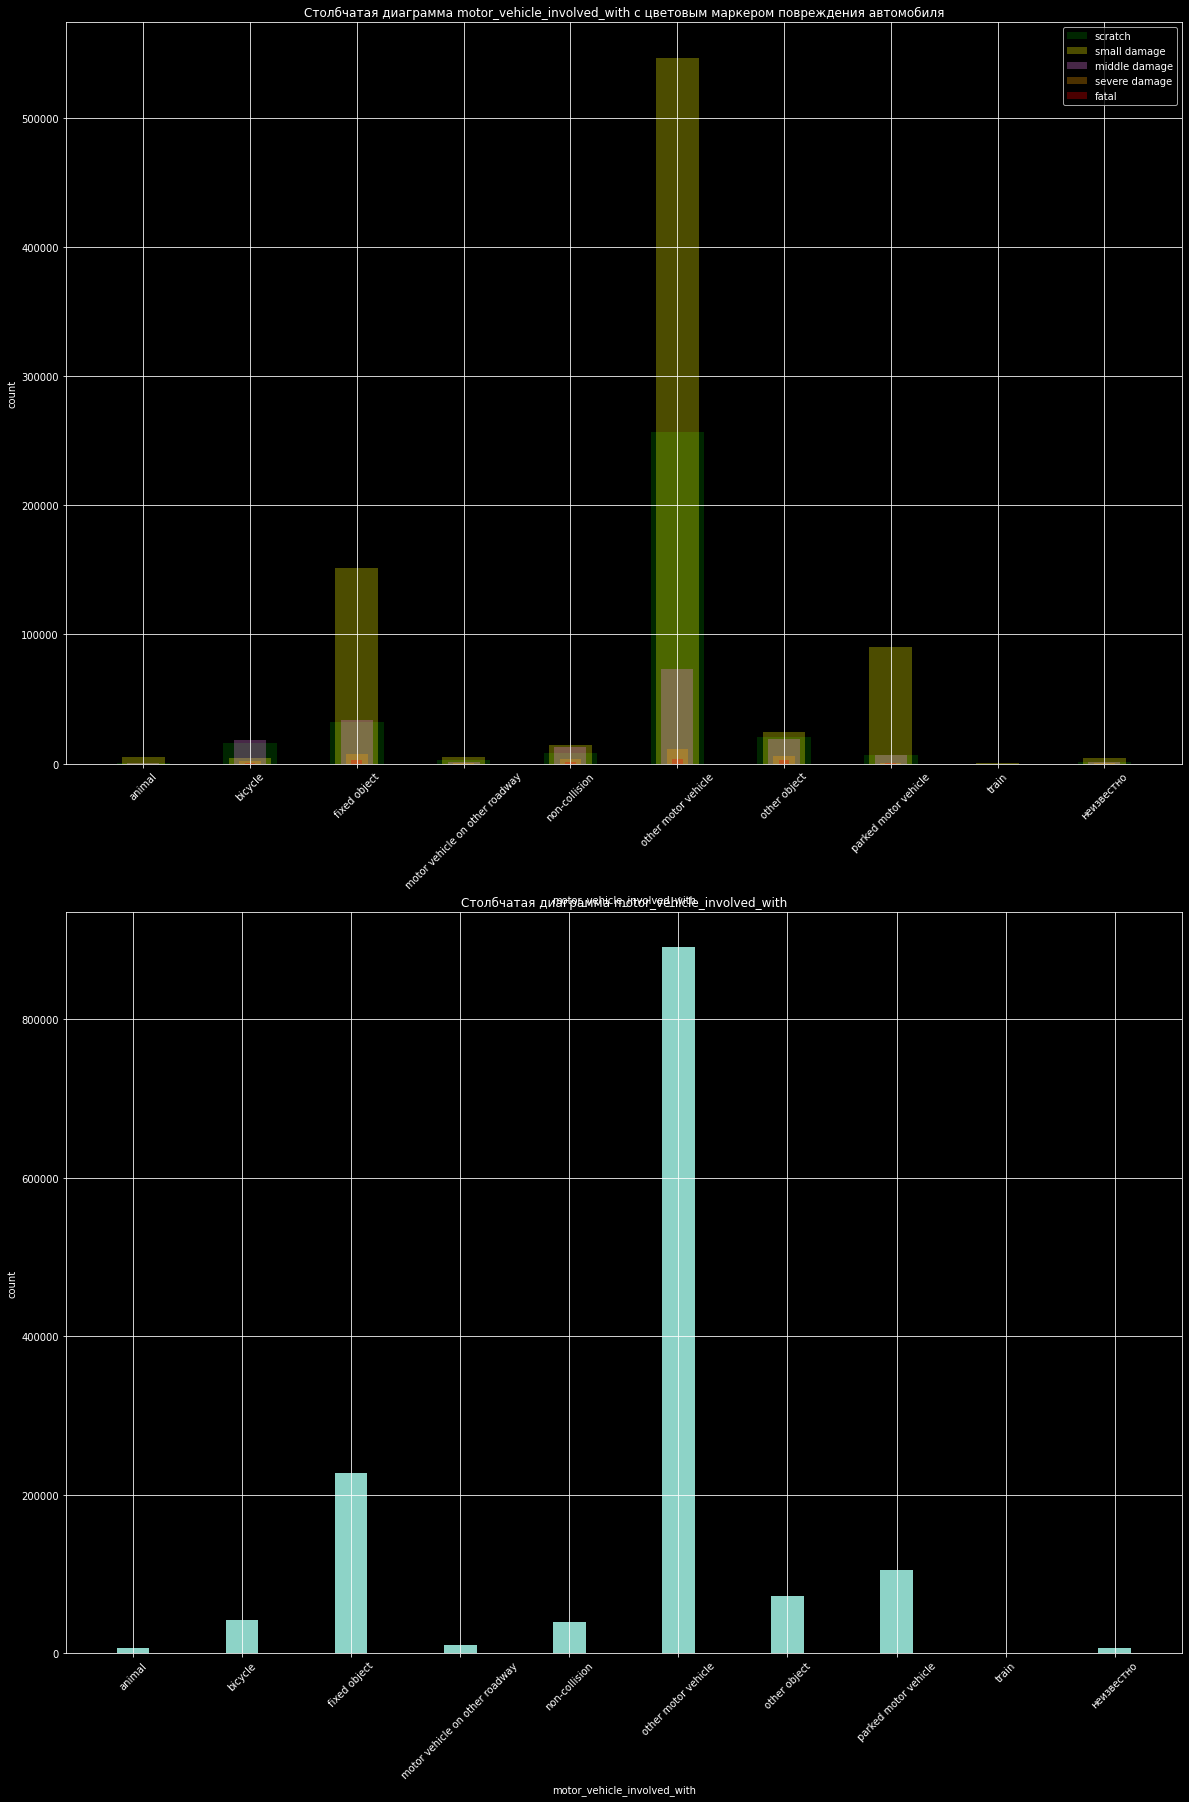

type_of_collision


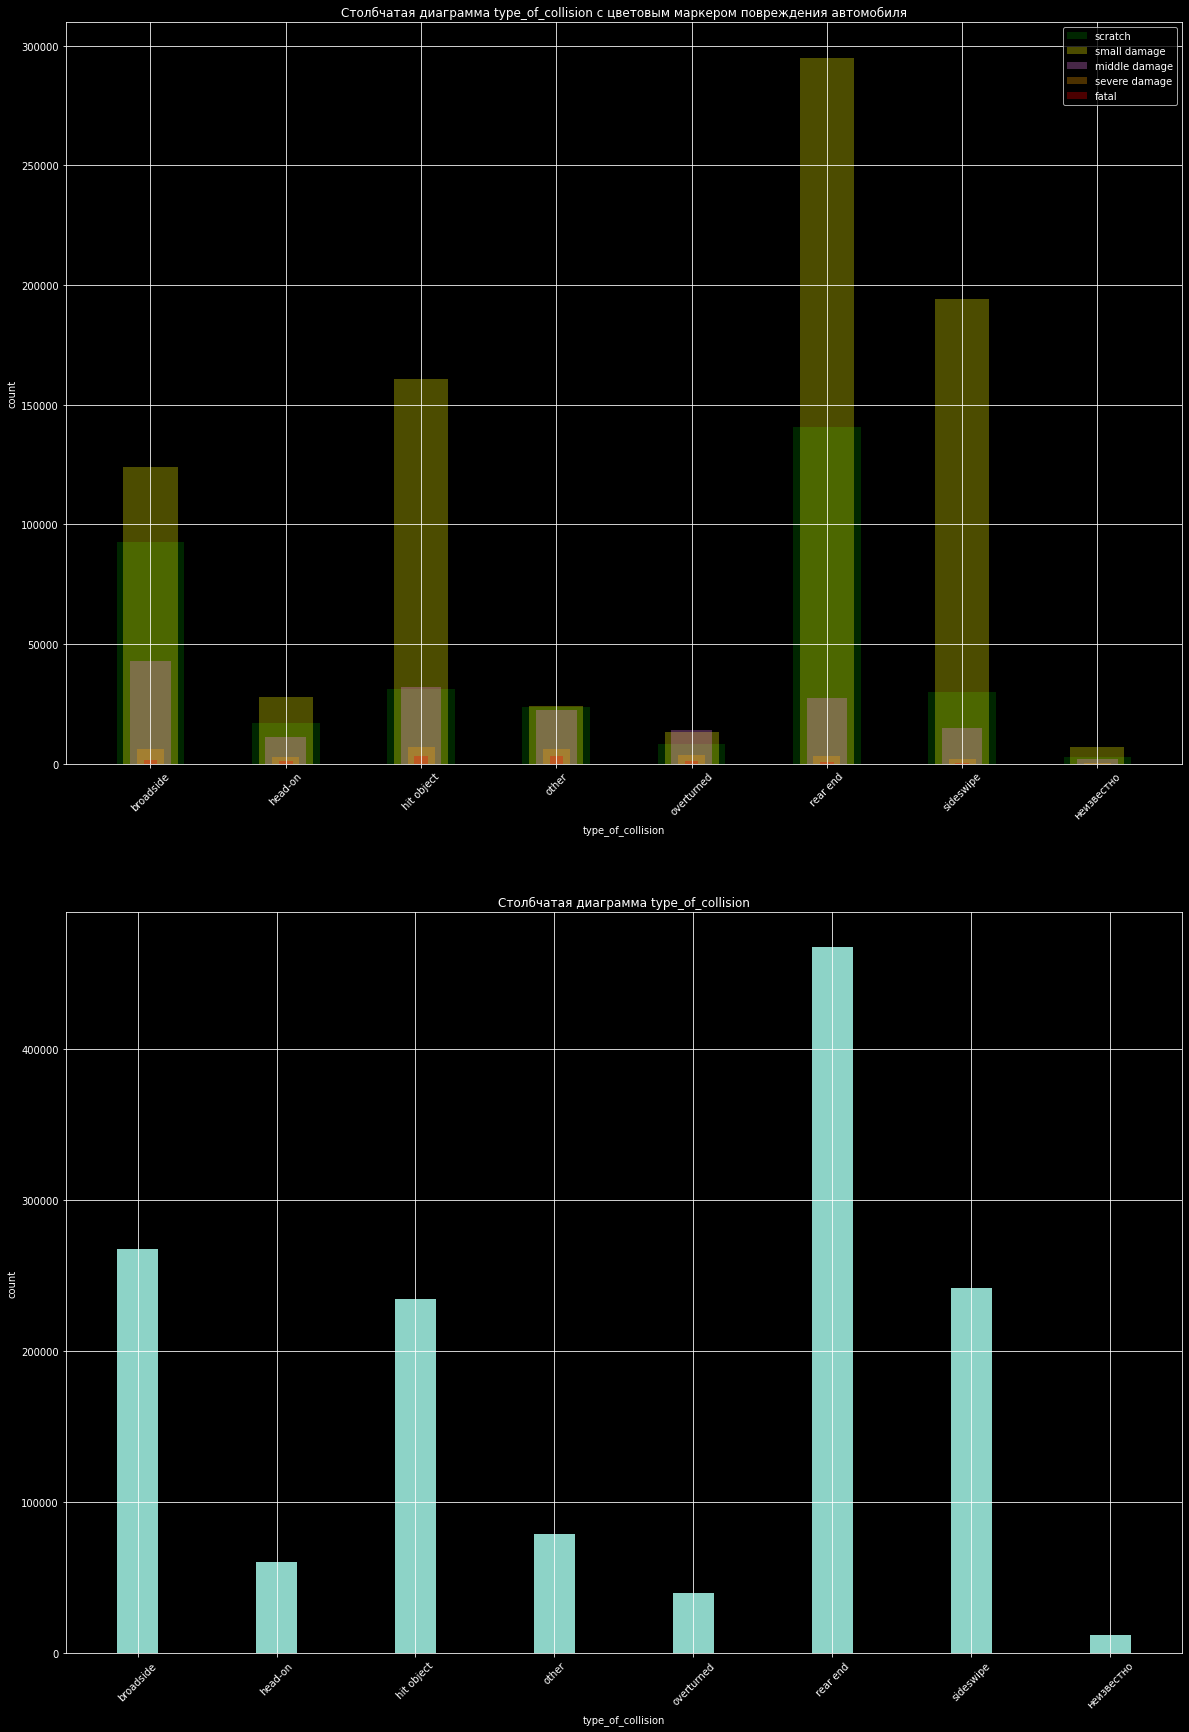

pcf_violation_category


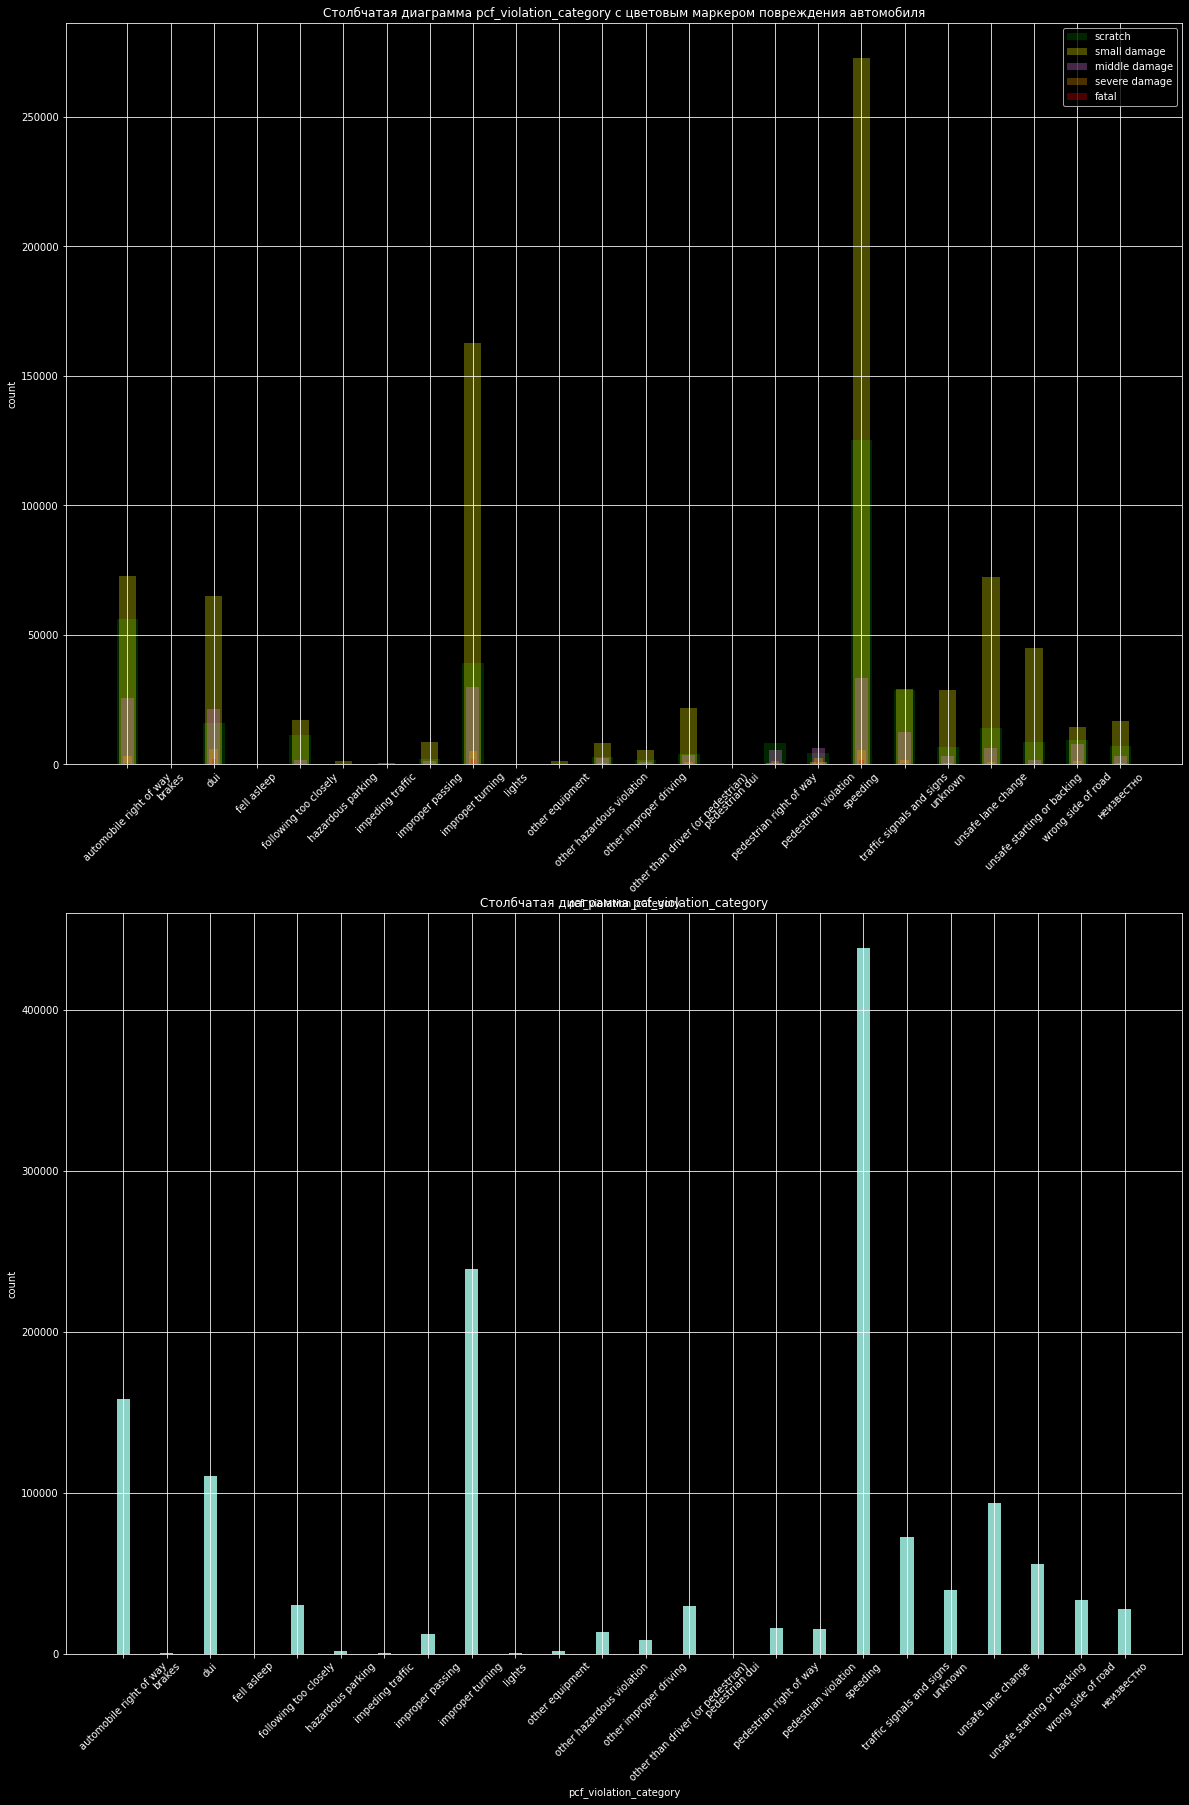

primary_collision_factor


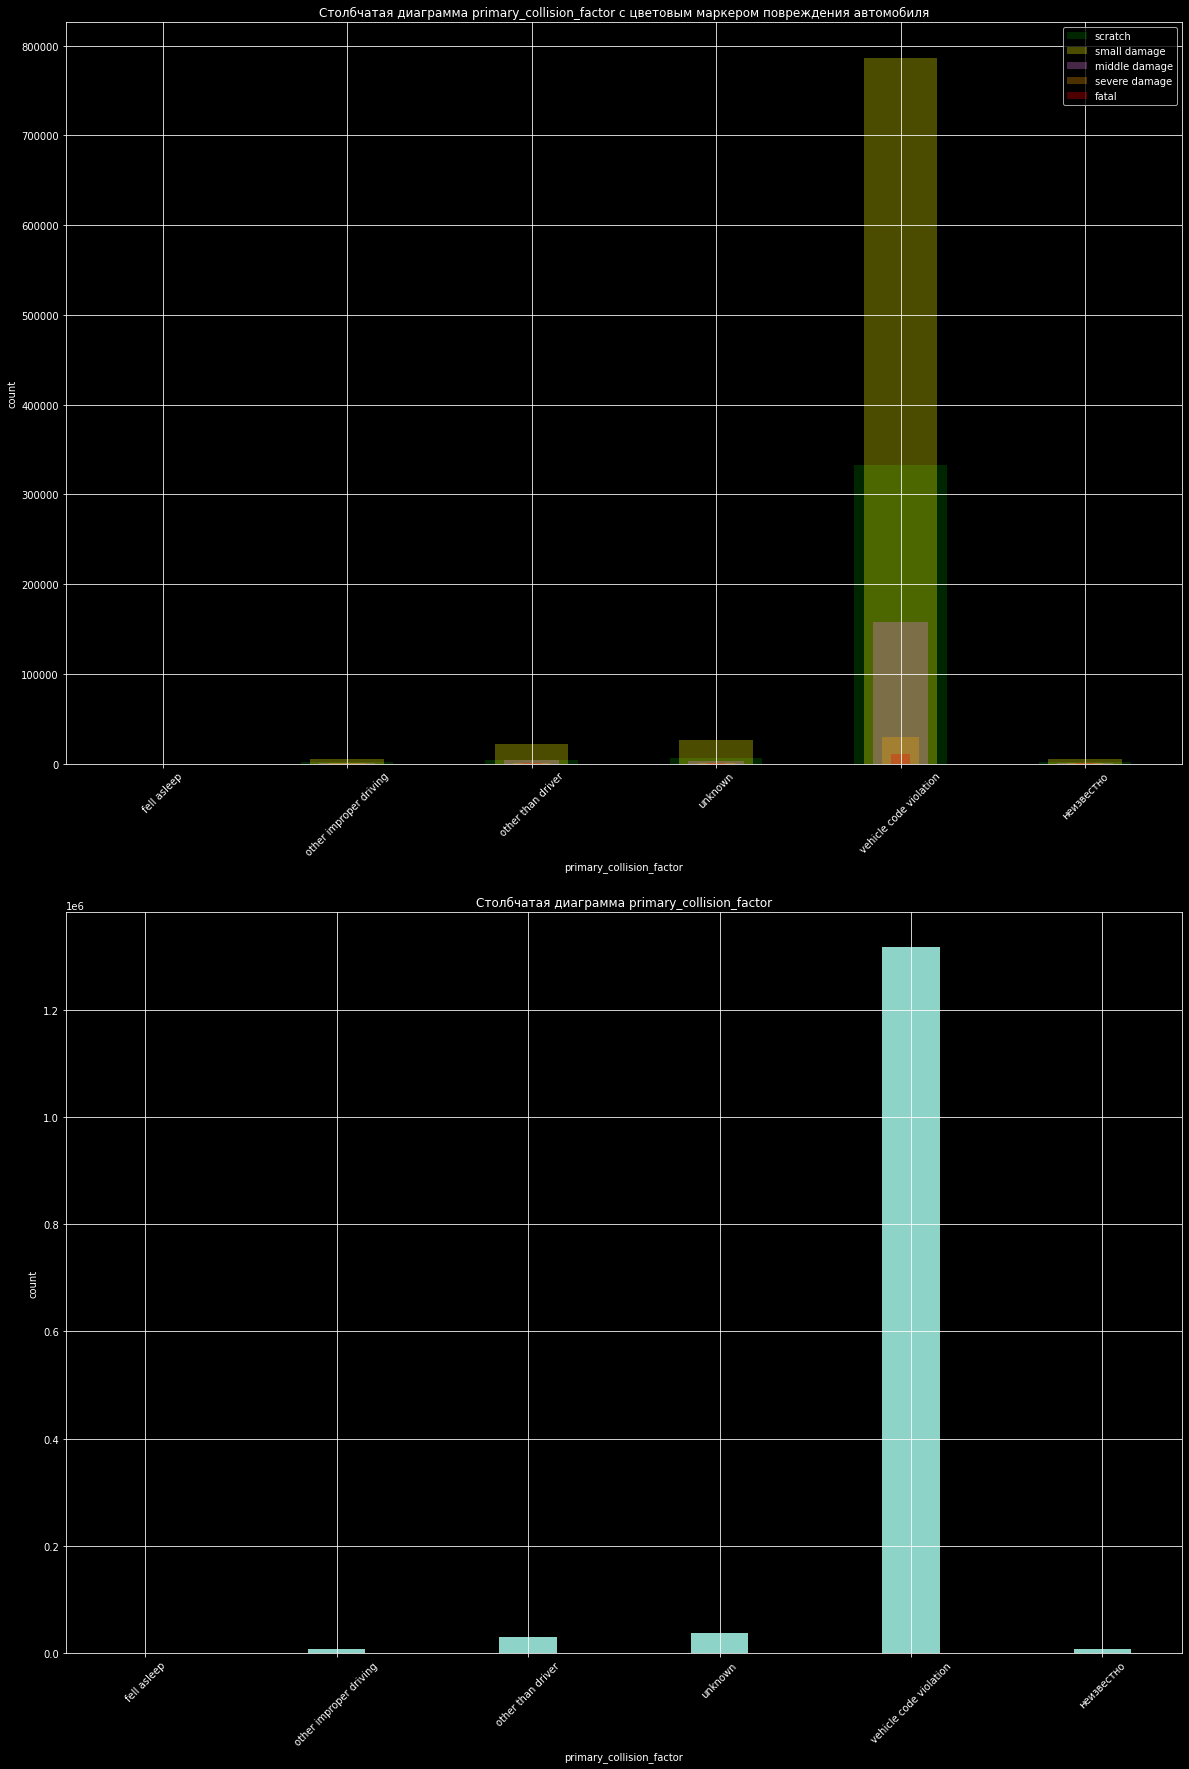

party_drug_physical


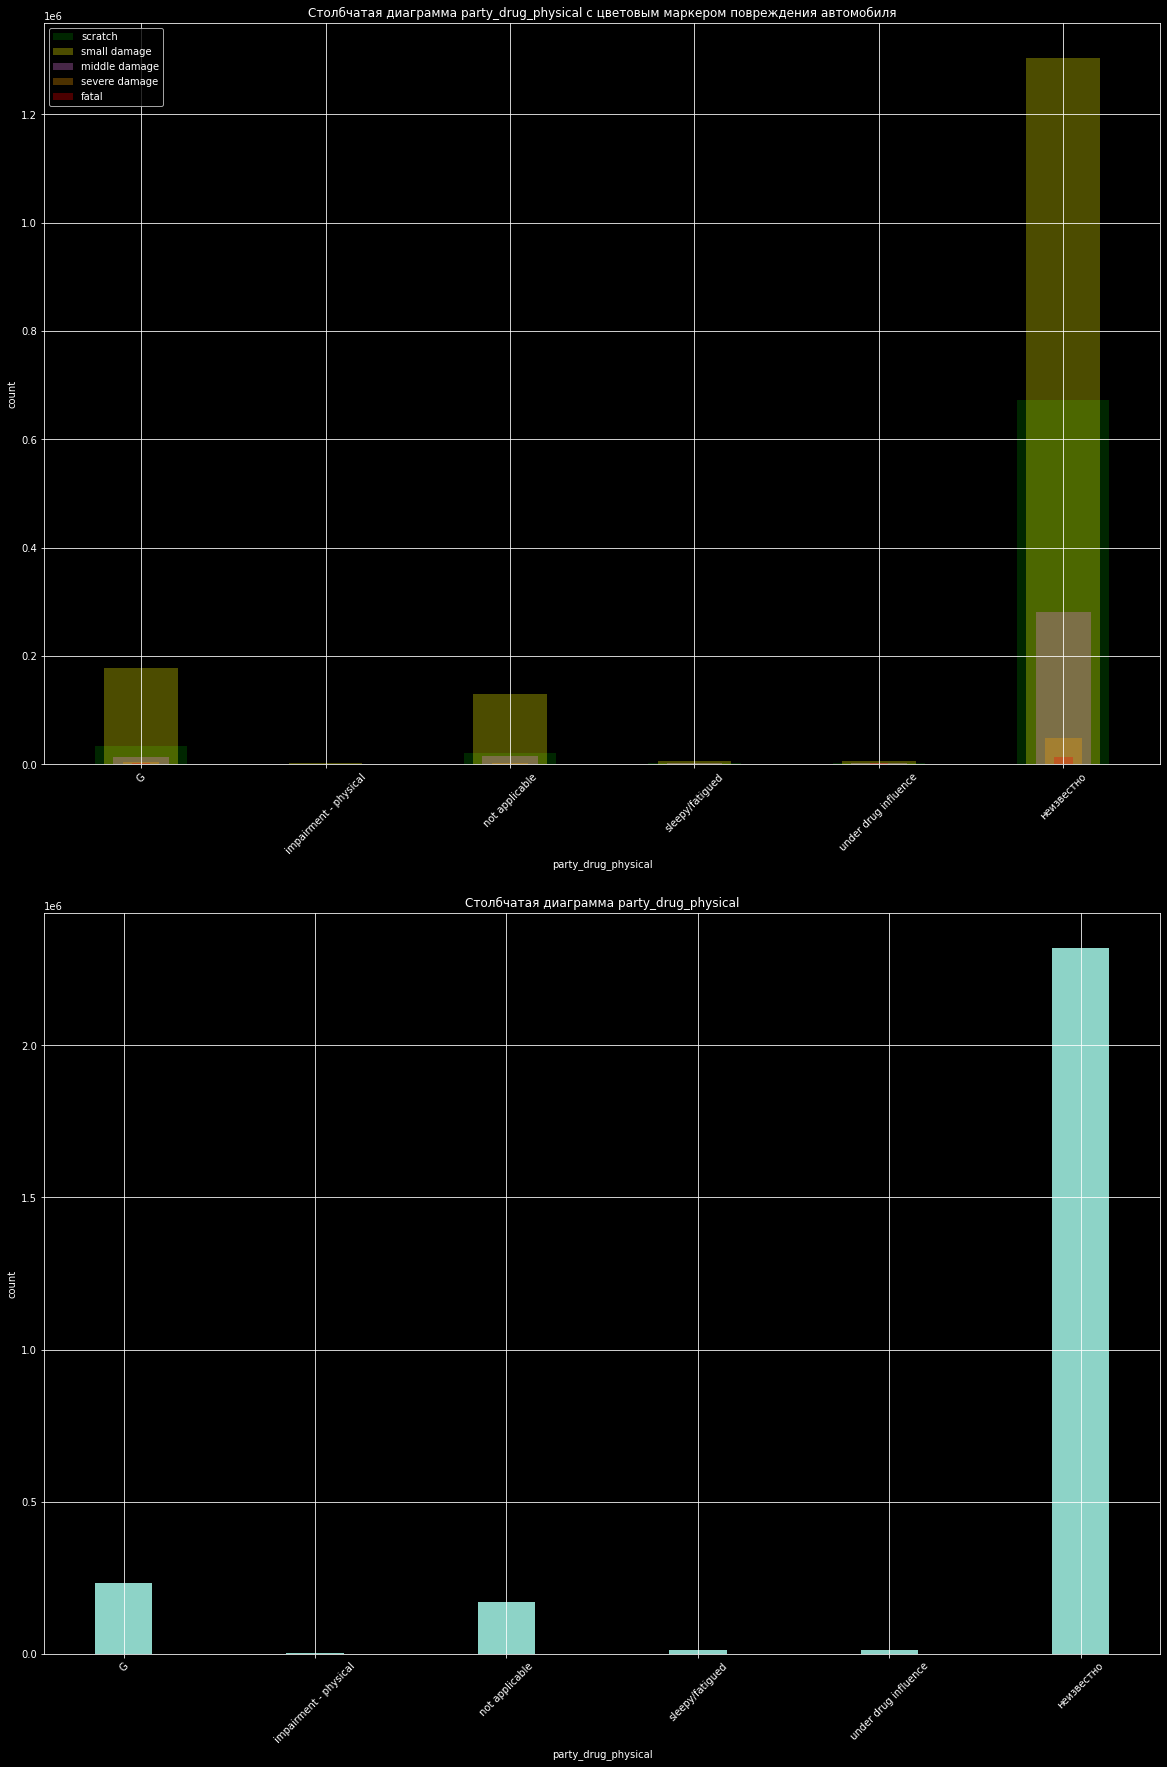

In [ ]:
for colum in ['road_surface', 'road_condition_1', 'location_type',
              'weather_1', 'lighting', 'direction',
              'control_device', 'motor_vehicle_involved_with',
              'type_of_collision', 'pcf_violation_category',
              'primary_collision_factor', 'party_drug_physical']:
    if colum in ['party_drug_physical']:
        query = """
            SELECT
                COALESCE(p.{colum}, 'неизвестно') AS {colum},
                COALESCE(c.collision_damage, 'неизвестно') AS collision_damage,
                COUNT(*) AS count
            FROM parties p
            LEFT JOIN collisions c ON p.case_id = c.case_id
            GROUP BY COALESCE(p.{colum}, 'неизвестно'), COALESCE(c.collision_damage, 'неизвестно')
        """.format(colum=colum)
        x = pd.read_sql_query(query, con=engine)

        query = """
            SELECT
                COALESCE(p.{colum}, 'неизвестно') AS {colum},
                COUNT(*) AS count
            FROM parties p
            GROUP BY COALESCE(p.{colum}, 'неизвестно')
        """.format(colum=colum)
        y = pd.read_sql_query(query, con=engine)
    else:
        query = """
            SELECT
                COALESCE(c.{colum}, 'неизвестно') AS {colum},
                COALESCE(c.collision_damage, 'неизвестно') AS collision_damage,
                COUNT(*) AS count
            FROM collisions c
            GROUP BY COALESCE(c.{colum}, 'неизвестно'), COALESCE(c.collision_damage, 'неизвестно')
        """.format(colum=colum)
        x = pd.read_sql_query(query, con=engine)

        query = """
            SELECT
                COALESCE(c.{colum}, 'неизвестно') AS {colum},
                COUNT(*) AS count
            FROM collisions c
            GROUP BY COALESCE(c.{colum}, 'неизвестно')
        """.format(colum=colum)
        y = pd.read_sql_query(query, con=engine)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 30))
    print(colum)
    x_values = x[colum].unique()
    for color, row, width in (['green', 'scratch', 0.5],
                            ['yellow', 'small damage', 0.4],
                            ['Violet', 'middle damage', 0.3],
                            ['orange', 'severe damage', 0.2],
                            ['red', 'fatal', 0.1]):
        if colum in ['party_drug_physical']:
            query = """
                SELECT
                    COALESCE(p.{colum}, 'неизвестно') AS {colum},
                    COUNT(*) AS count
                FROM parties p
                LEFT JOIN collisions c ON p.case_id = c.case_id
                WHERE COALESCE(c.collision_damage, 'неизвестно') = '{row}'
                GROUP BY COALESCE(p.{colum}, 'неизвестно')
            """.format(colum=colum, row=row)
            x_row = pd.read_sql_query(query, con=engine)
        else:
            query = """
                SELECT
                    COALESCE(c.{colum}, 'неизвестно') AS {colum},
                    COUNT(*) AS count
                FROM collisions c
                WHERE COALESCE(c.collision_damage, 'неизвестно') = '{row}'
                GROUP BY COALESCE(c.{colum}, 'неизвестно')
            """.format(colum=colum, row=row)
            x_row = pd.read_sql_query(query, con=engine)
        x_row = x_row.set_index(colum).reindex(x_values).fillna(0)
        ax[0].bar(x_values, x_row['count'], alpha=0.3, color=color, width=width, label=row)
    ax[0].set_xticks(range(len(x_values)))
    ax[0].set_xticklabels(x_values, rotation=45)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Столбчатая диаграмма ' + colum + ' с цветовым маркером повреждения автомобиля')
    ax[0].grid(True)

    ax[1].bar(y[colum], y['count'], width=0.3)
    ax[1].set_xticks(range(len(y[colum])))
    ax[1].set_xticklabels(y[colum], rotation=45)
    ax[1].set_title('Столбчатая диаграмма ' + colum)
    ax[1].set_xlabel(colum)
    ax[1].set_ylabel('count')
    ax[1].grid(True)
    plt.show()

-'road_surface'(состояние дороги) fatal ДТП больше произошедших на сухой дороги, пропорции fatal относительно кол-ва ДТП на разных по состоянию дорогах соблюдены

-'road_condition_1'(состояние дорожного полотна) fatal больше на нормальной дороге, пропорции fatal относительно кол-ва ДТП на разных по состоянию дорожного полотна соблюдены

-'location_type'(тип дороги) fatal ДТП больше произошедших на шоссе, пропорции fatal относительно кол-ва ДТП на разных типов дороги соблюдены за исключением слегка превышенной fatal ДТП на перекрестках относительно подъемов

-'weather_1'(погода) fatal ДТП больше произошедших при ясной погоде, пропорции fatal относительно кол-ва ДТП произошедших при разной погоде соблюдены

-'lighting'(освещенность) fatal ДТП больше произошедших при дневном свете, пропорции fatal относительно кол-ва ДТП произошедших при разном освещении искажены в сторону увеличения fatal при темном освещении

-'direction'(направление движения на перекрестке) fatal ДТП +- идентично одинаково при любом движении на перекрестке, пропорции соблюдены

-'control_device'(состояние устройств управления) fatal ДТП больше при функционирующих устройств управления, пропорции fatal относительно кол-ва ДТП произошедших при разном состояние устройств управления соблюдены

-'motor_vehicle_involved_with'(дополнительные участники ДТП) fatal ДТП больше при участии другово автомобиля, пропорции fatal относительно кол-ва ДТП произошедших при дополнительных участниках соблюдены за исключение повышенного fatal при значении motor_vehicle_involved_with == other object

-'type_of_collision'(тип столкновения) fatal ДТП больше при типе столкновения other, пропорции fatal относительно кол-ва ДТП произошедших при разных типах столкновения искажены, fatal больше при other, broadside и head-on

-'pcf_violation_category'(категория нарушения, приведшего к ДТП) fatal ДТП больше при категории нарушения-превышение скорости, пропорции fatal относительно кол-ва ДТП произошедших при разных категориях нарушения искажены, повышенный fatal ДТП при превышение скорости, нетрезвом пешеходе, небезопасном старте или движение назад, вождение в нетрезвом виде

-'primary_collision_factor'(основная причина ДТП) fatal ДТП больше при нарушении ПДД, пропорции fatal относительно кол-ва ДТП произошедших при разных причина ДТП соблюдены

-'party_drug_physical'(состояние участника ДТП) fatal ДТП больше под воздействием препаратов, пропорции fatal относительно кол-ва ДТП произошедших при состояние участника ДТП сильно искажены в сторону увеличения fatal под воздействием препаратов

### Анализ категорий сезонов года

road_surface


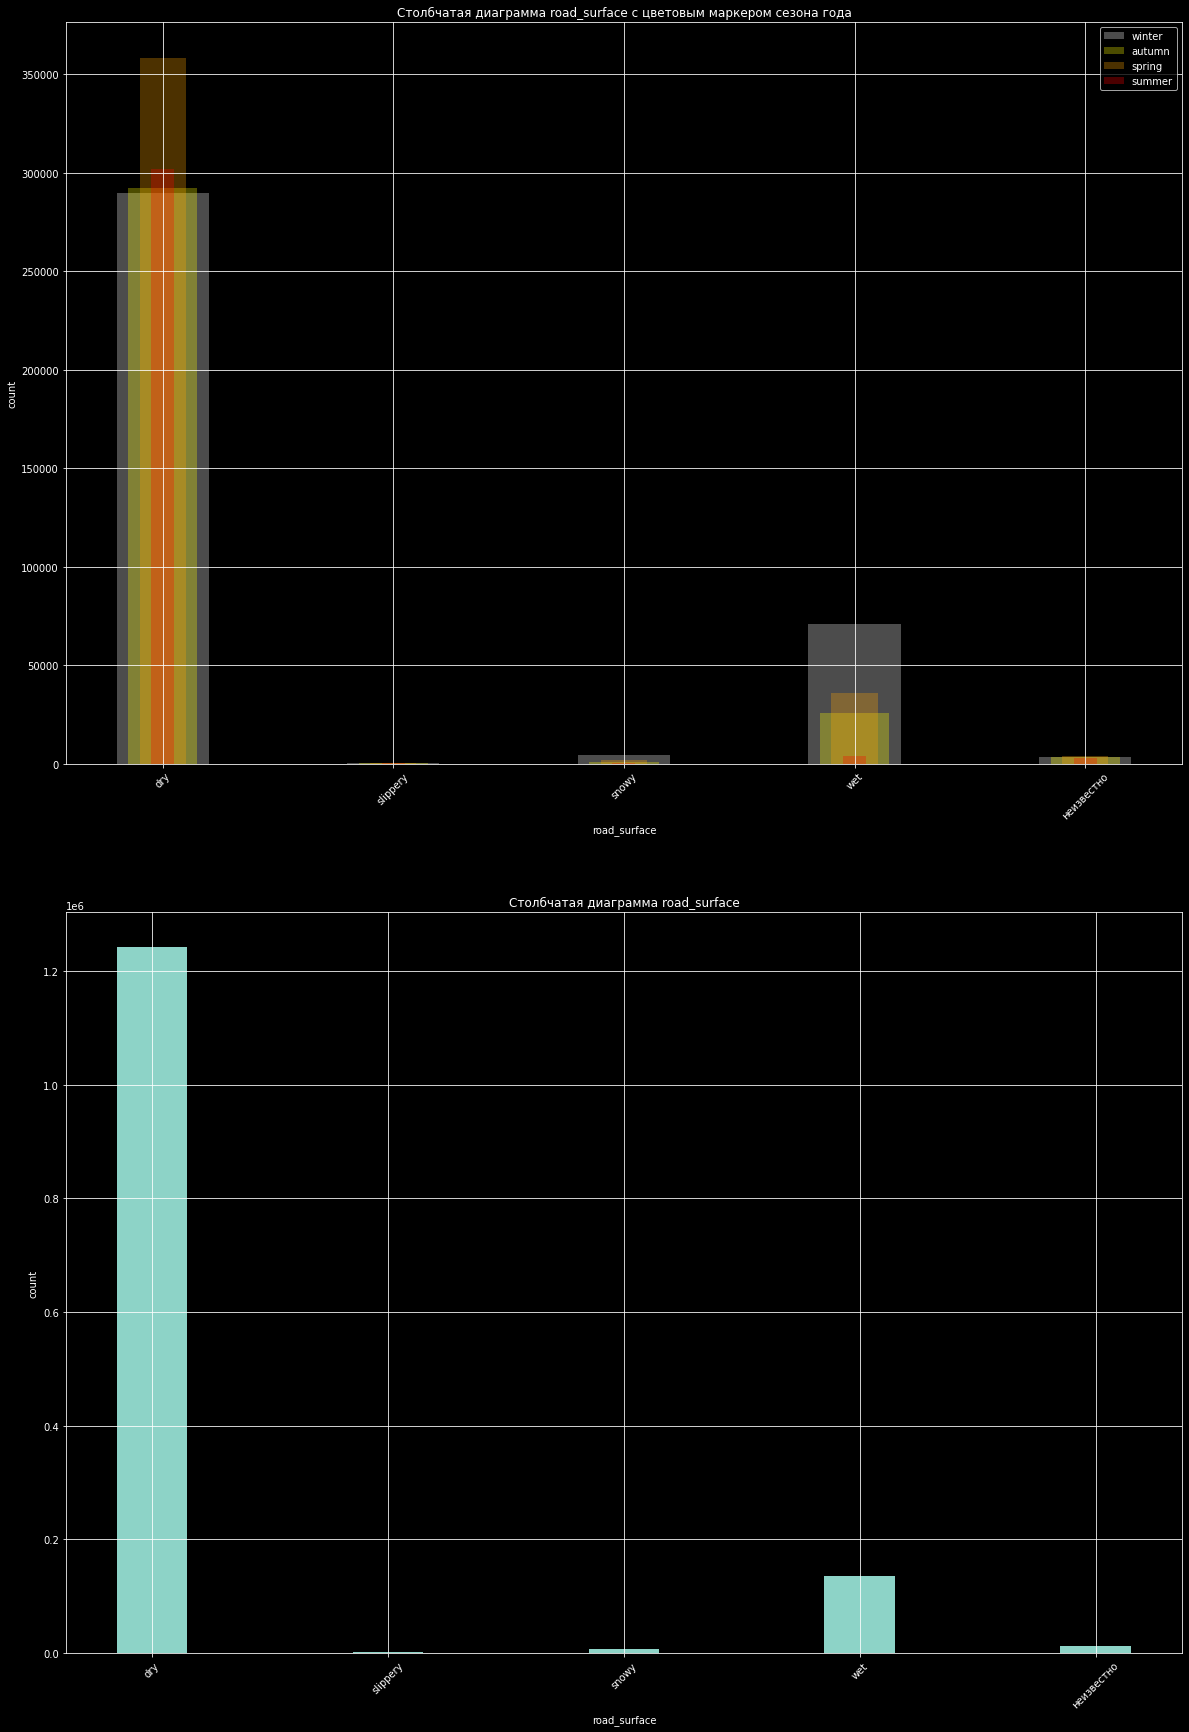

road_condition_1


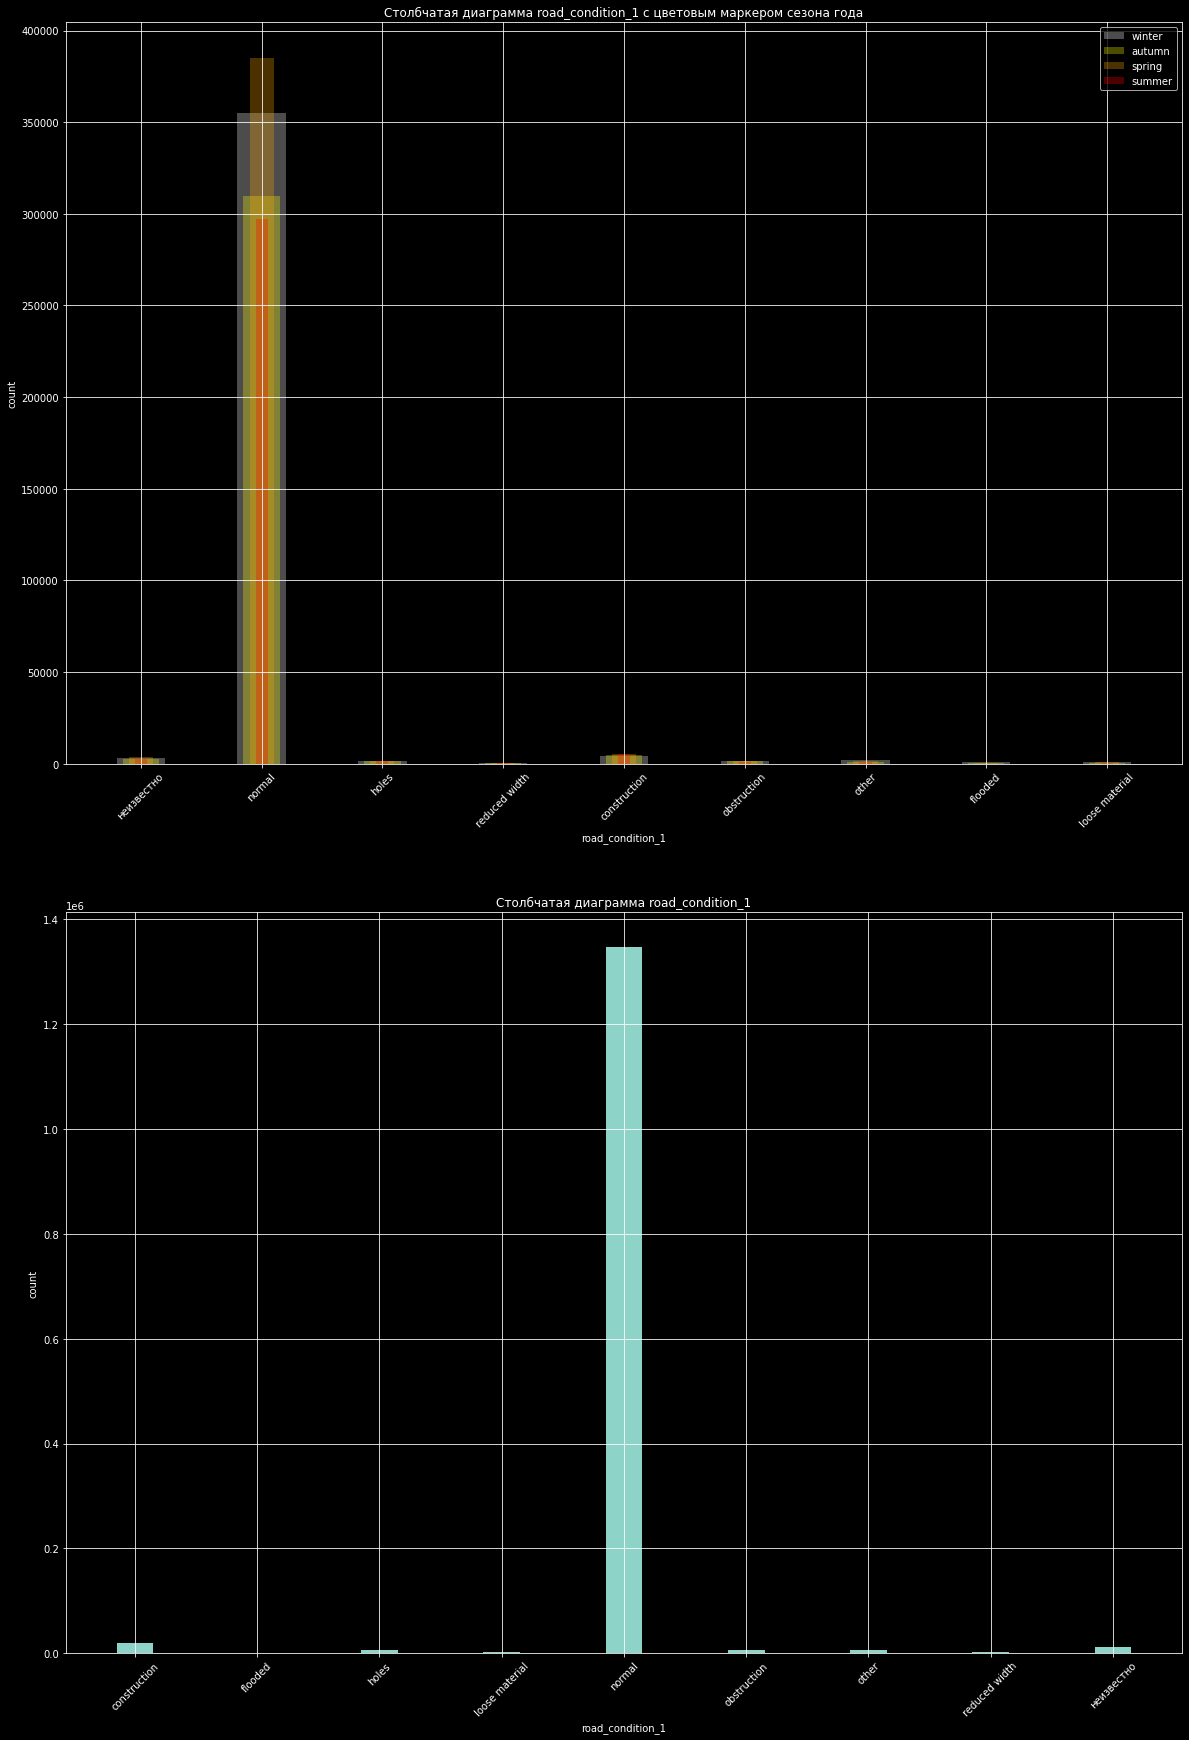

location_type


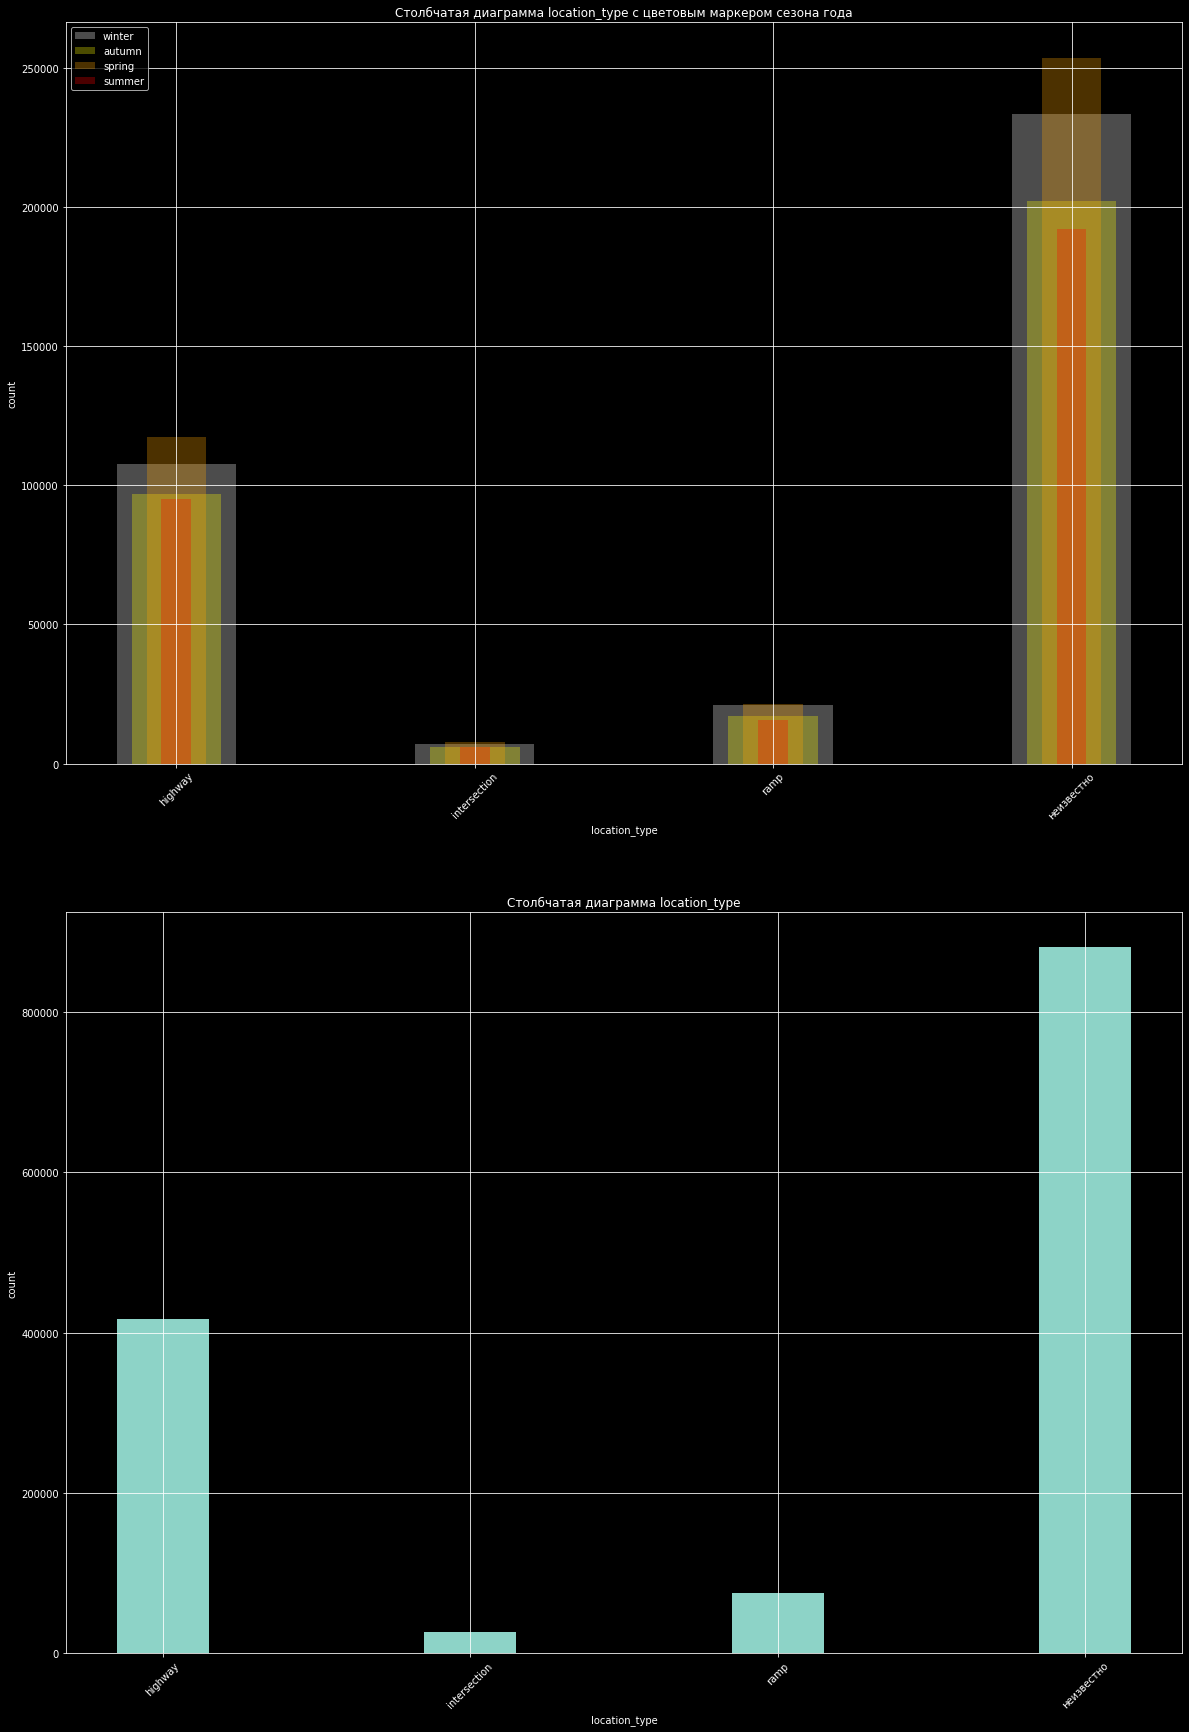

weather_1


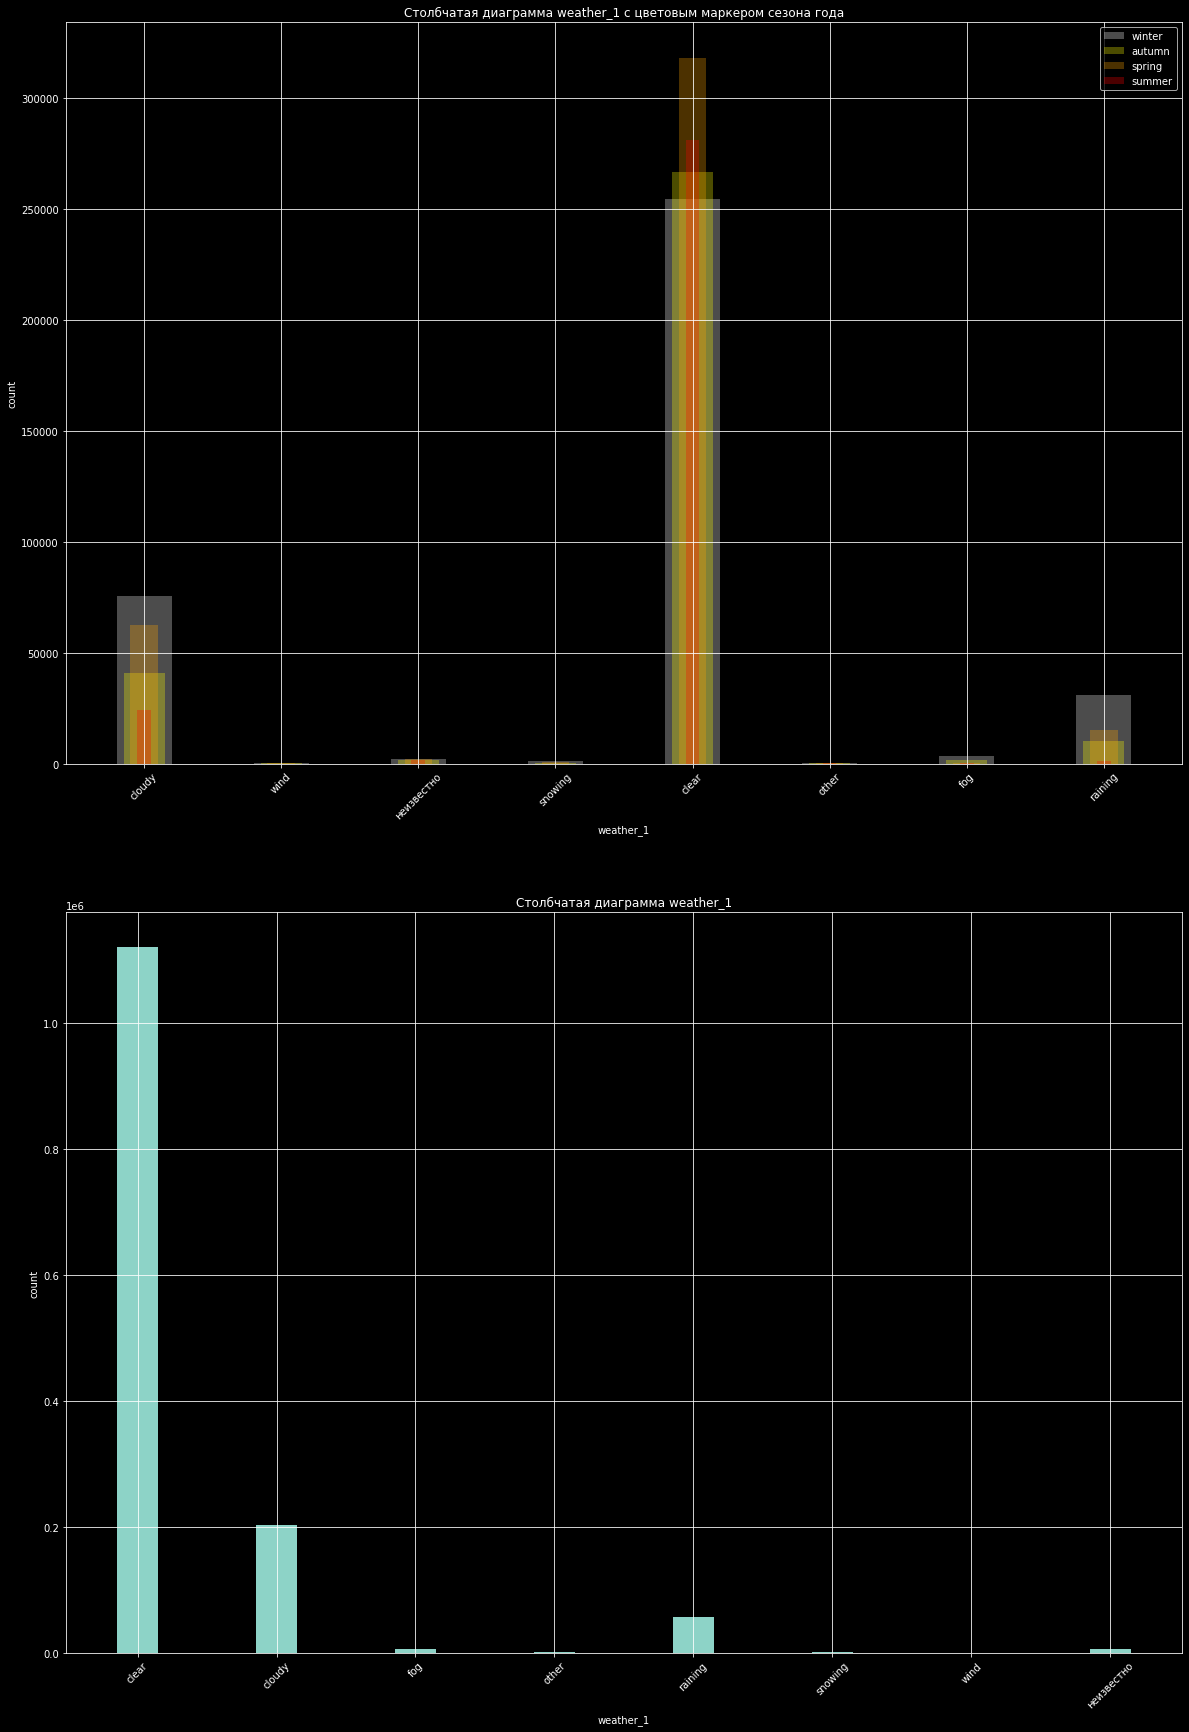

lighting


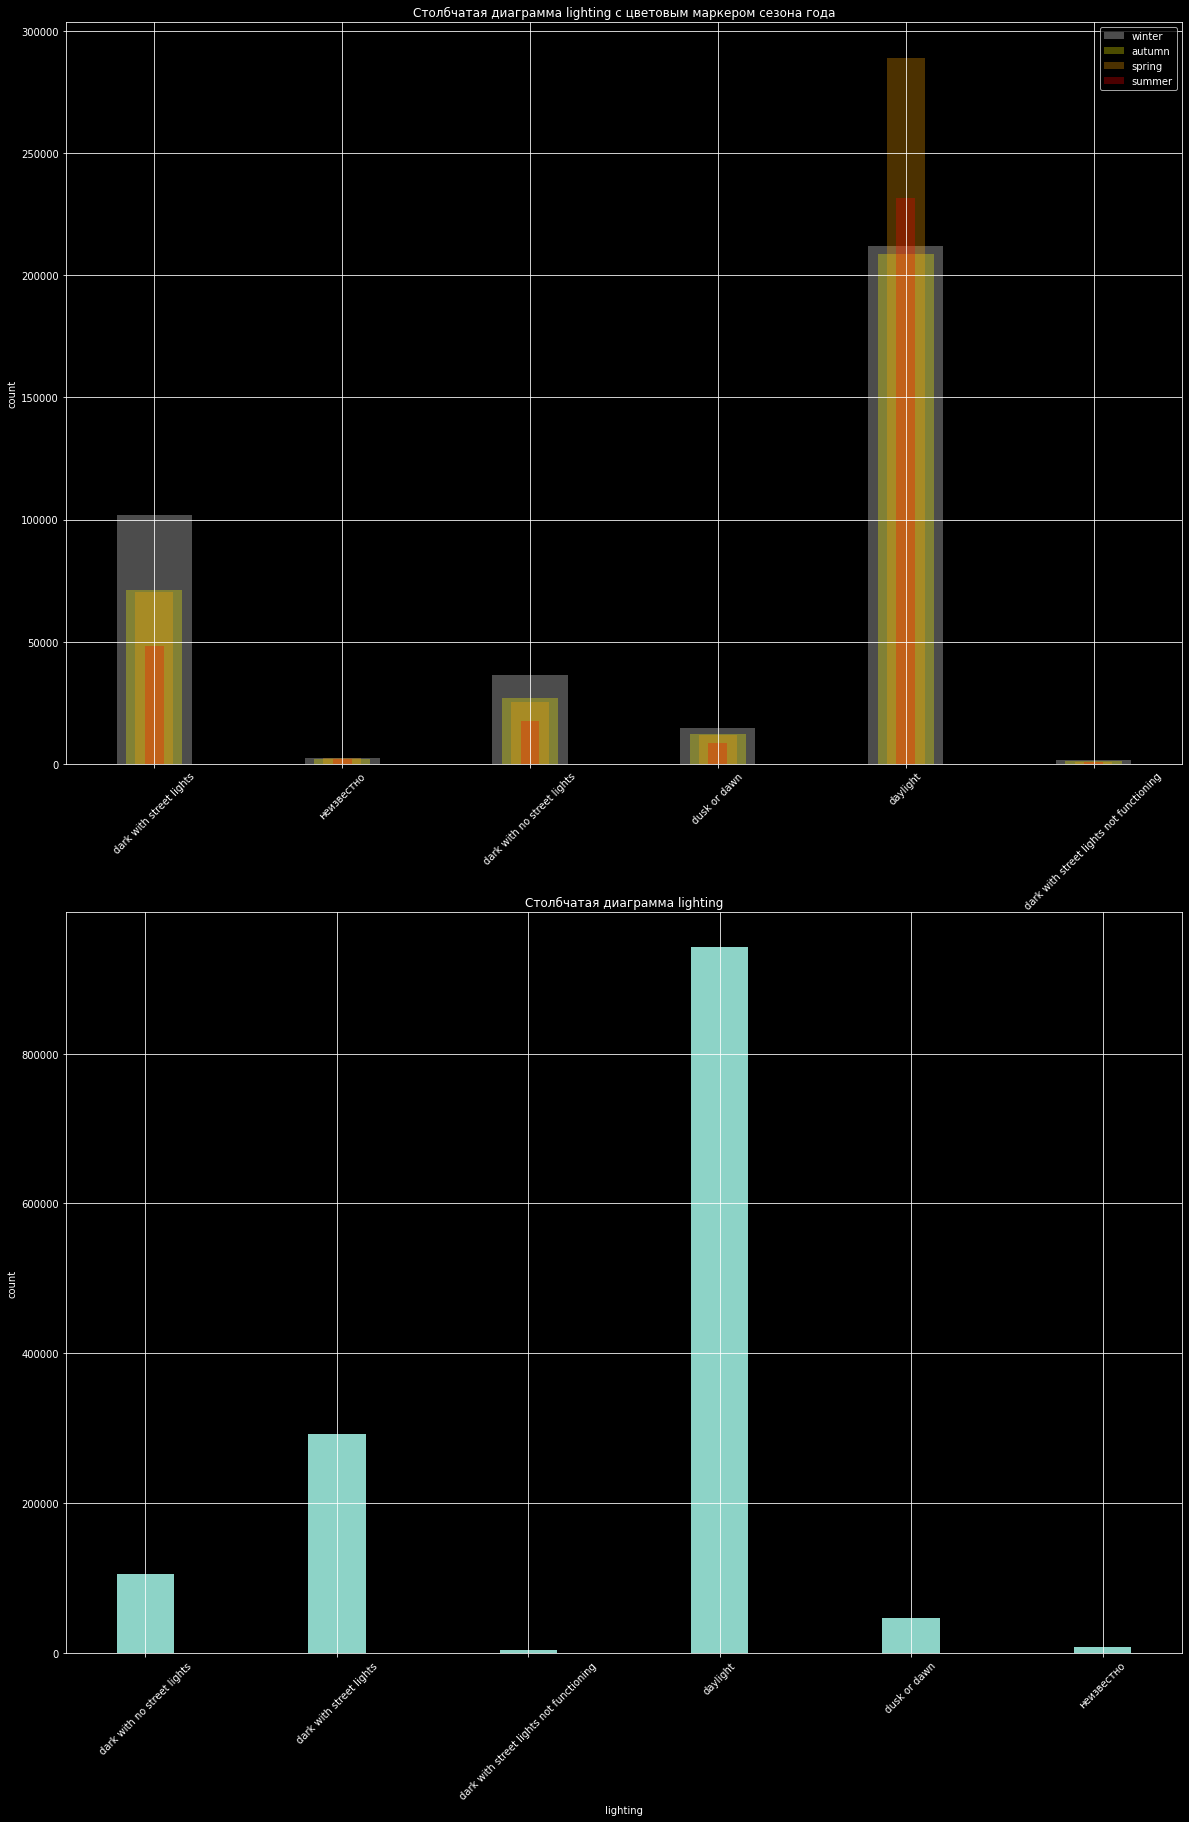

direction


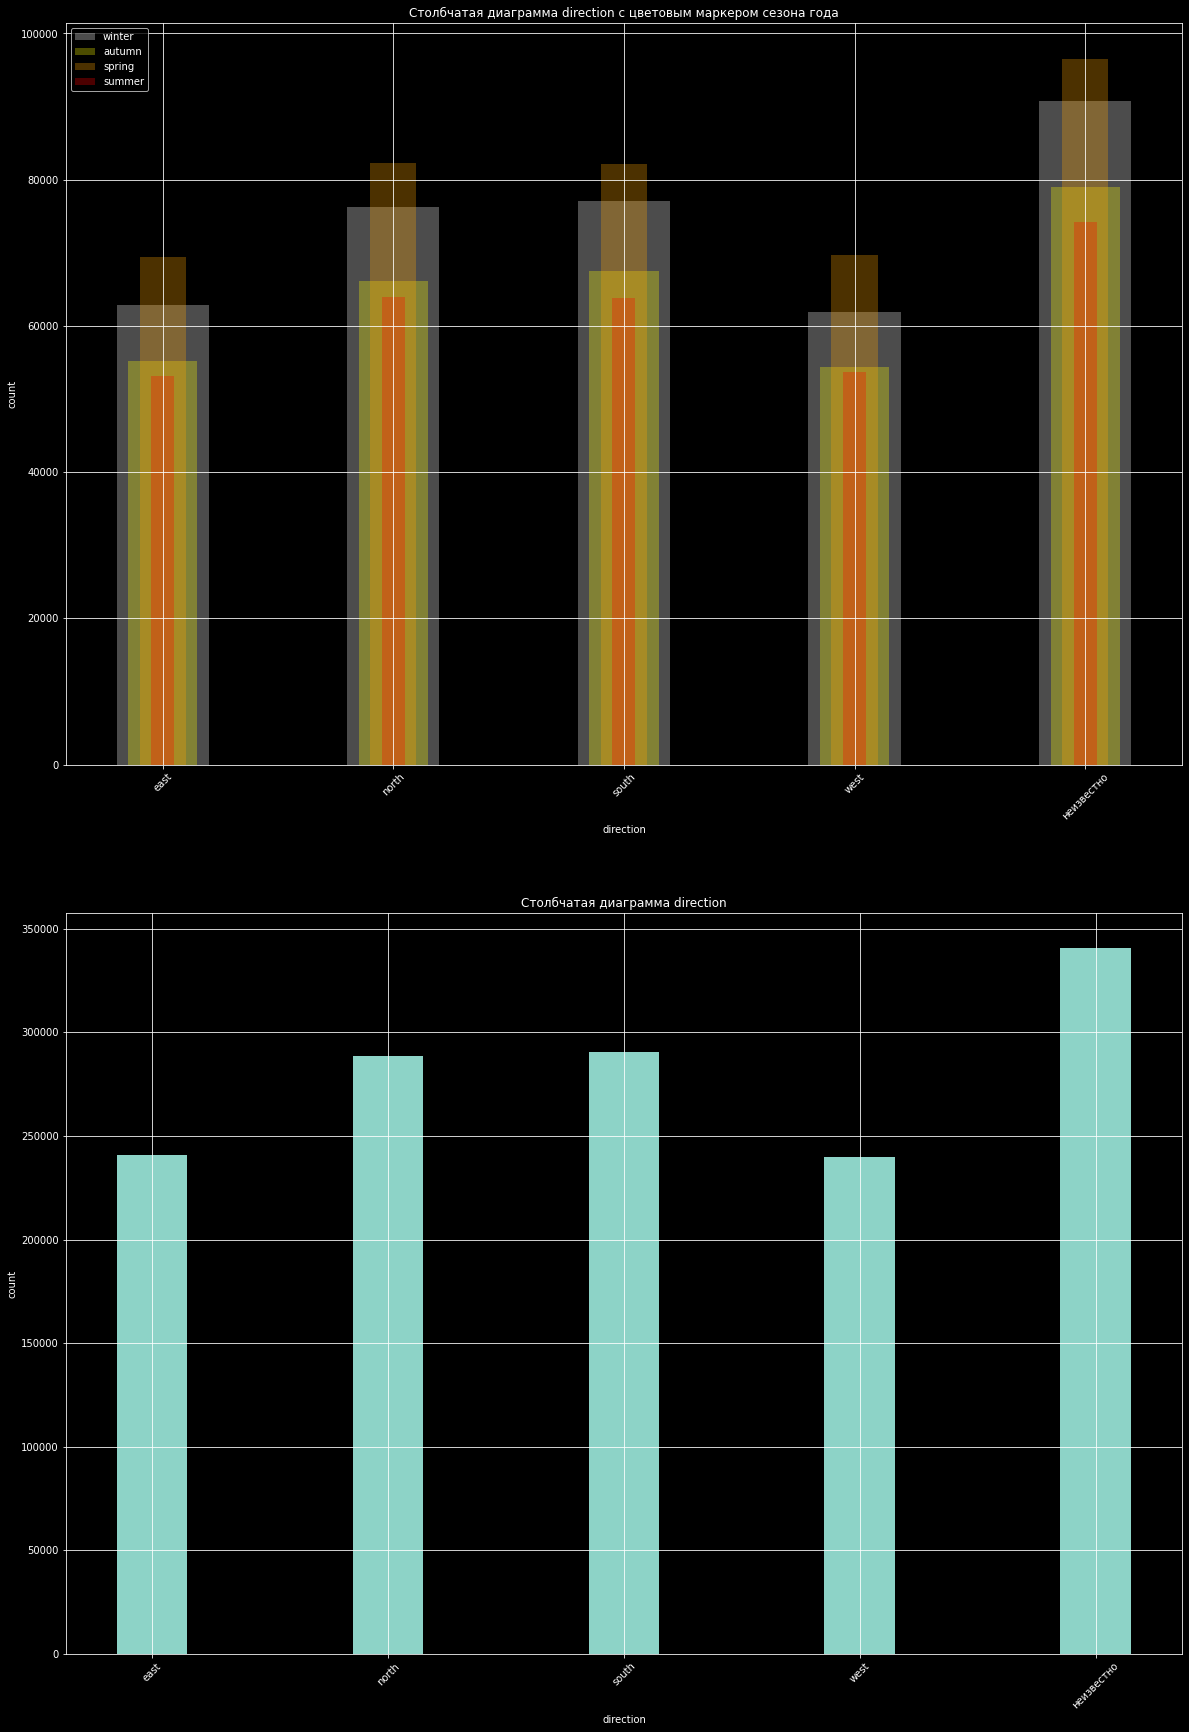

control_device


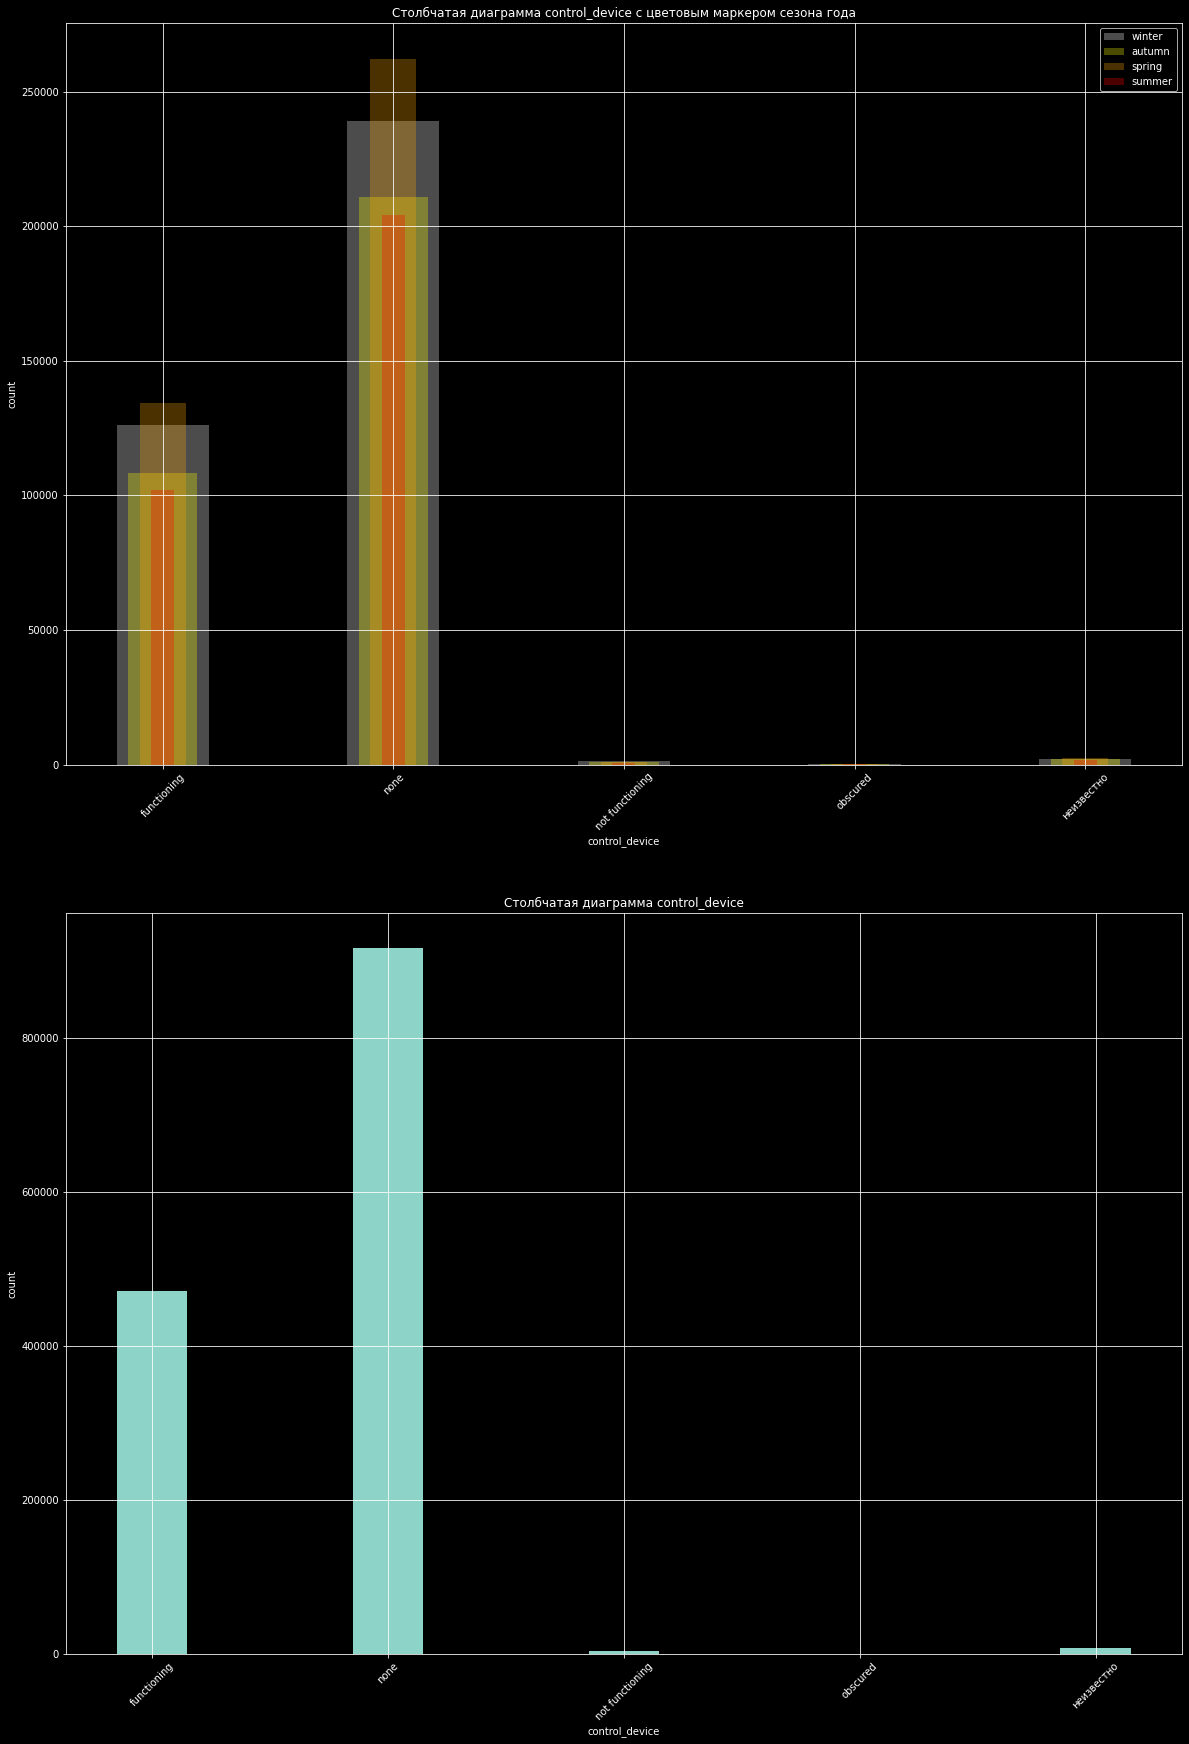

motor_vehicle_involved_with


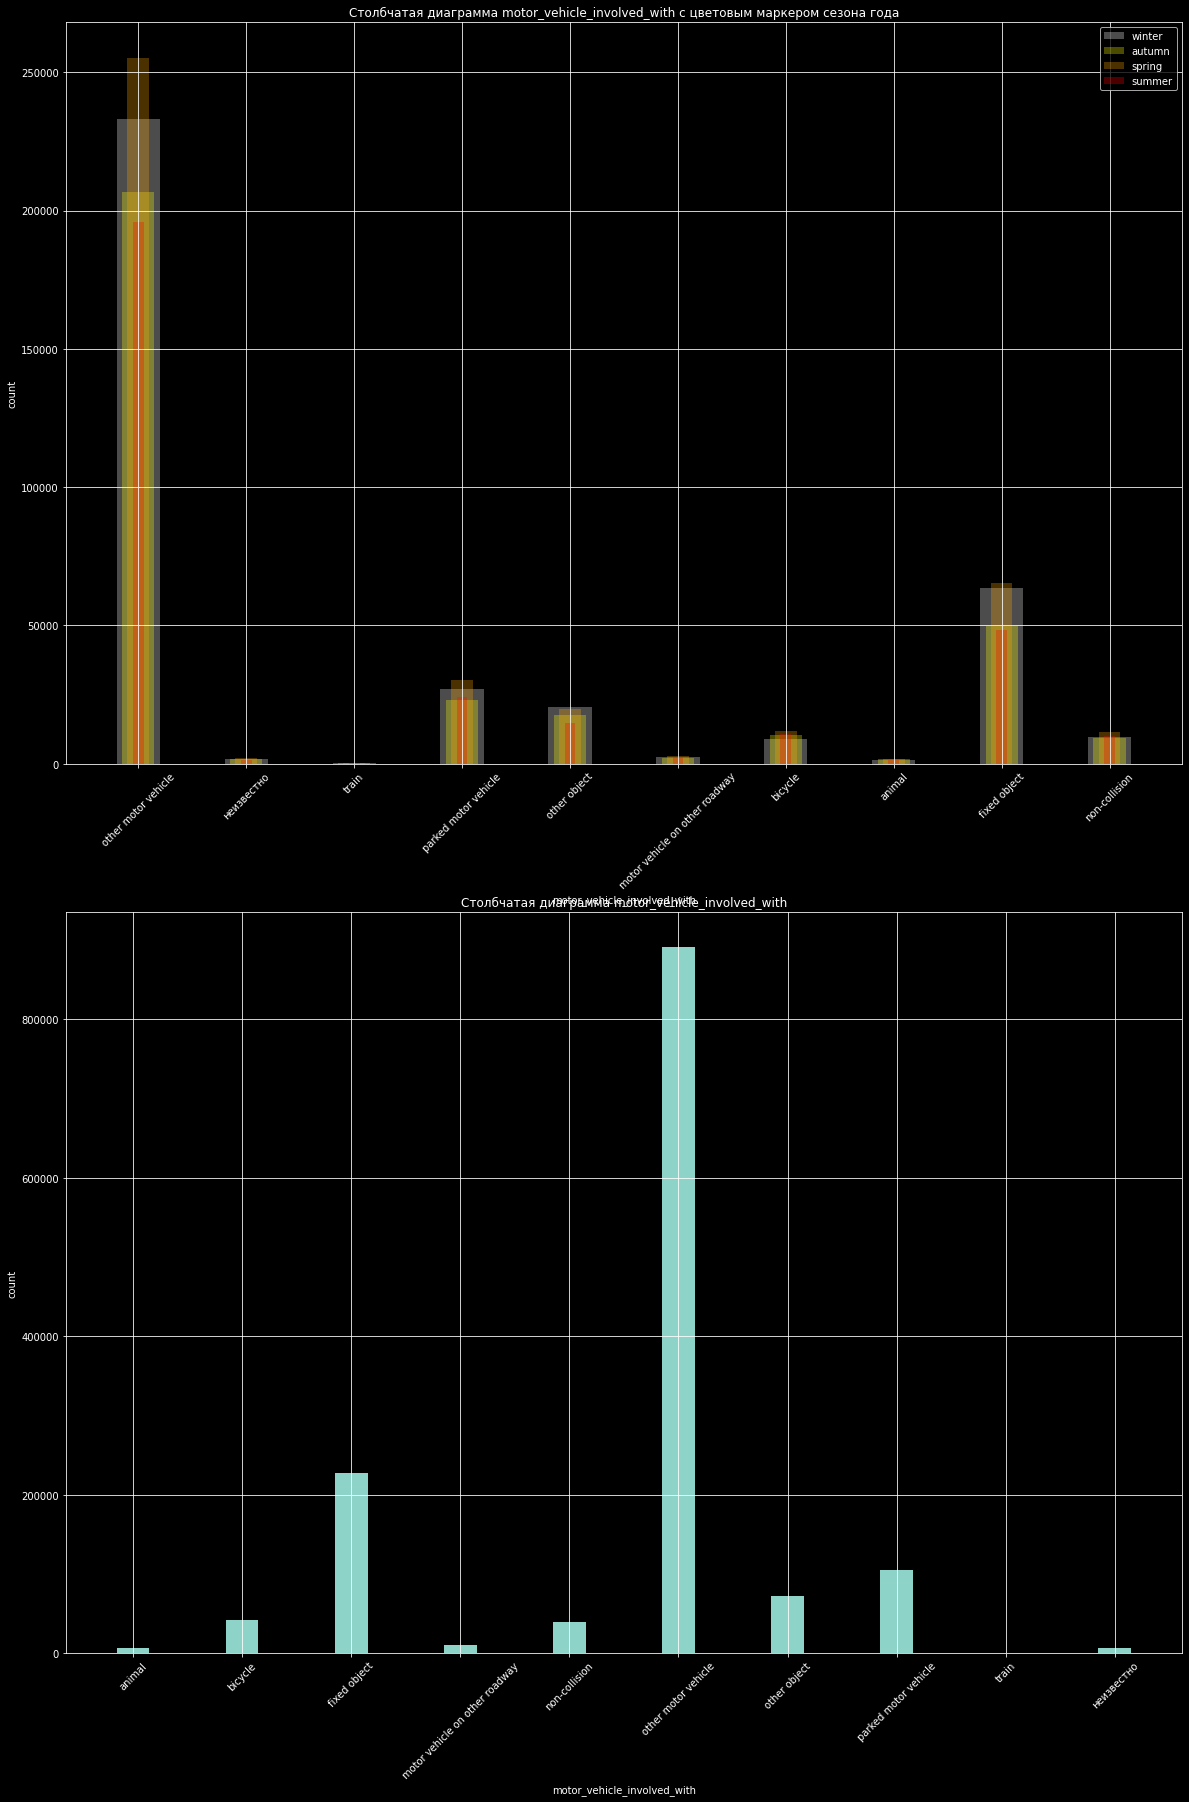

type_of_collision


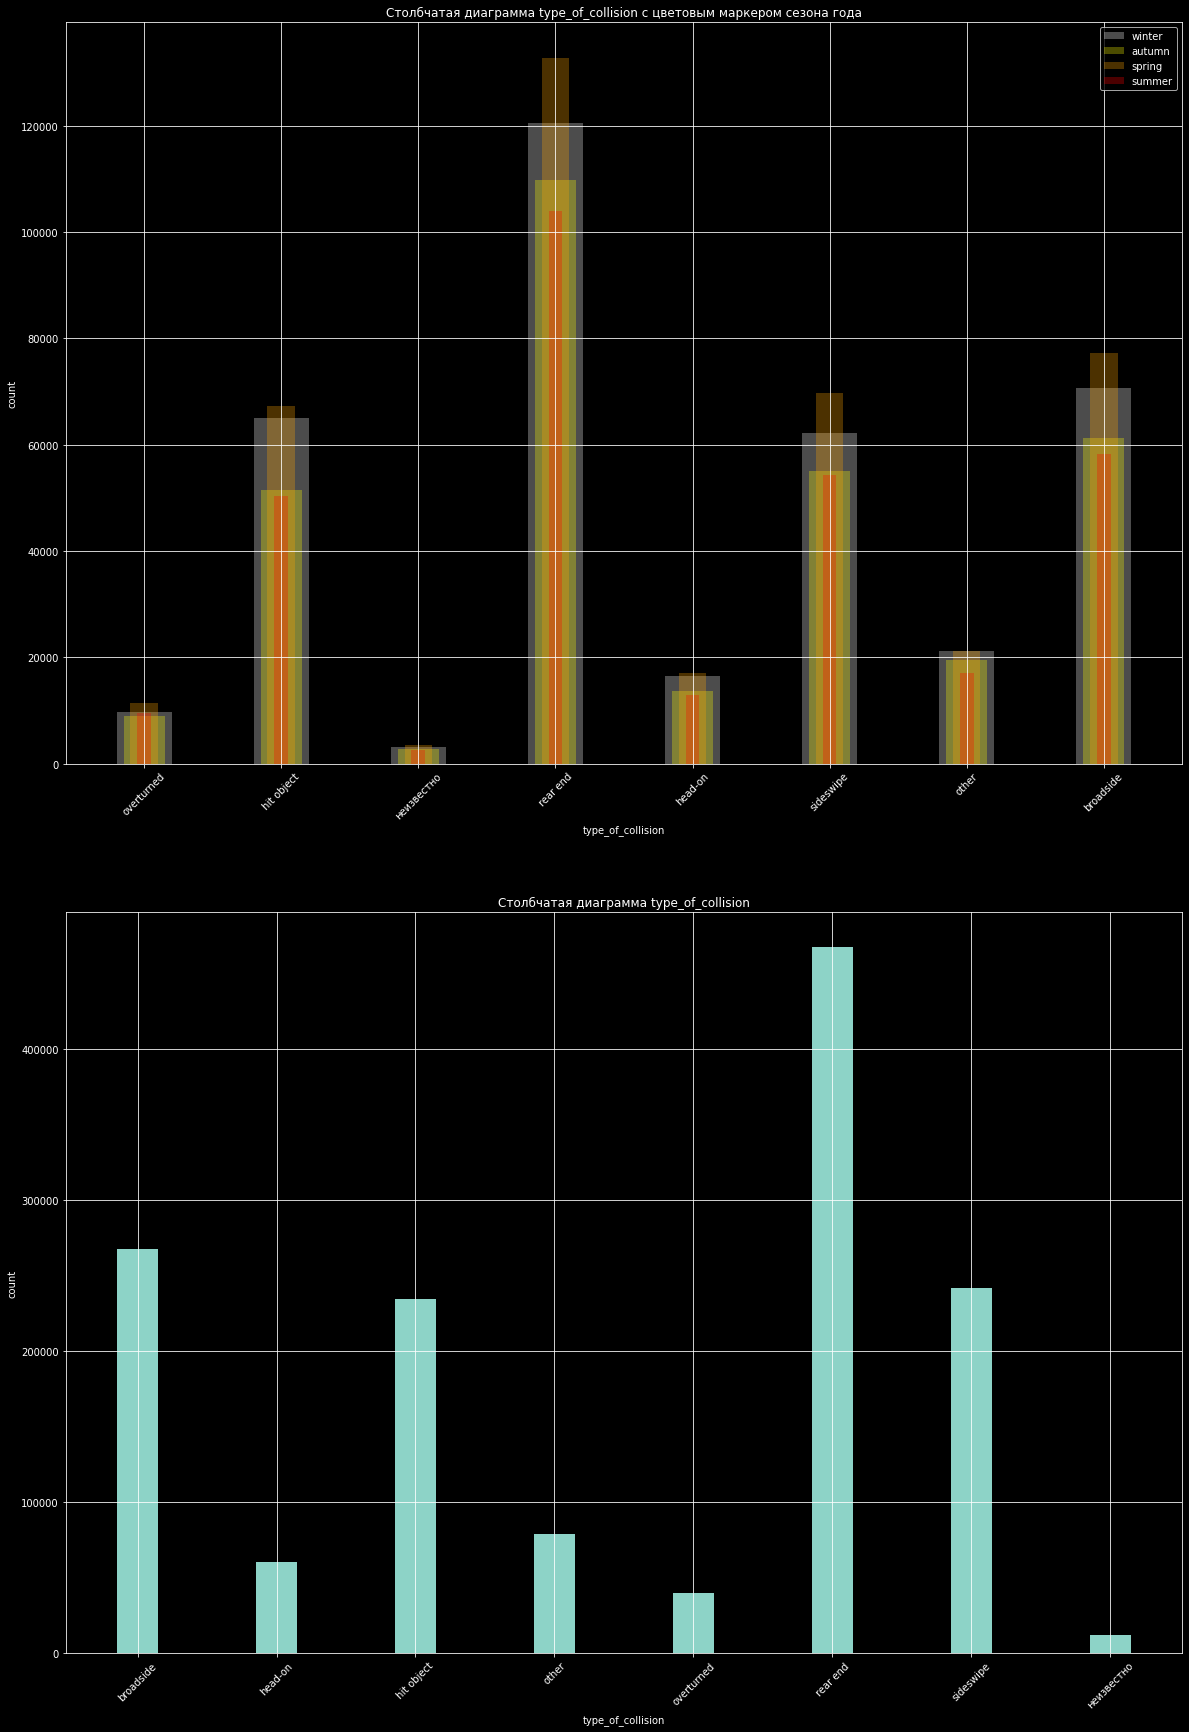

pcf_violation_category


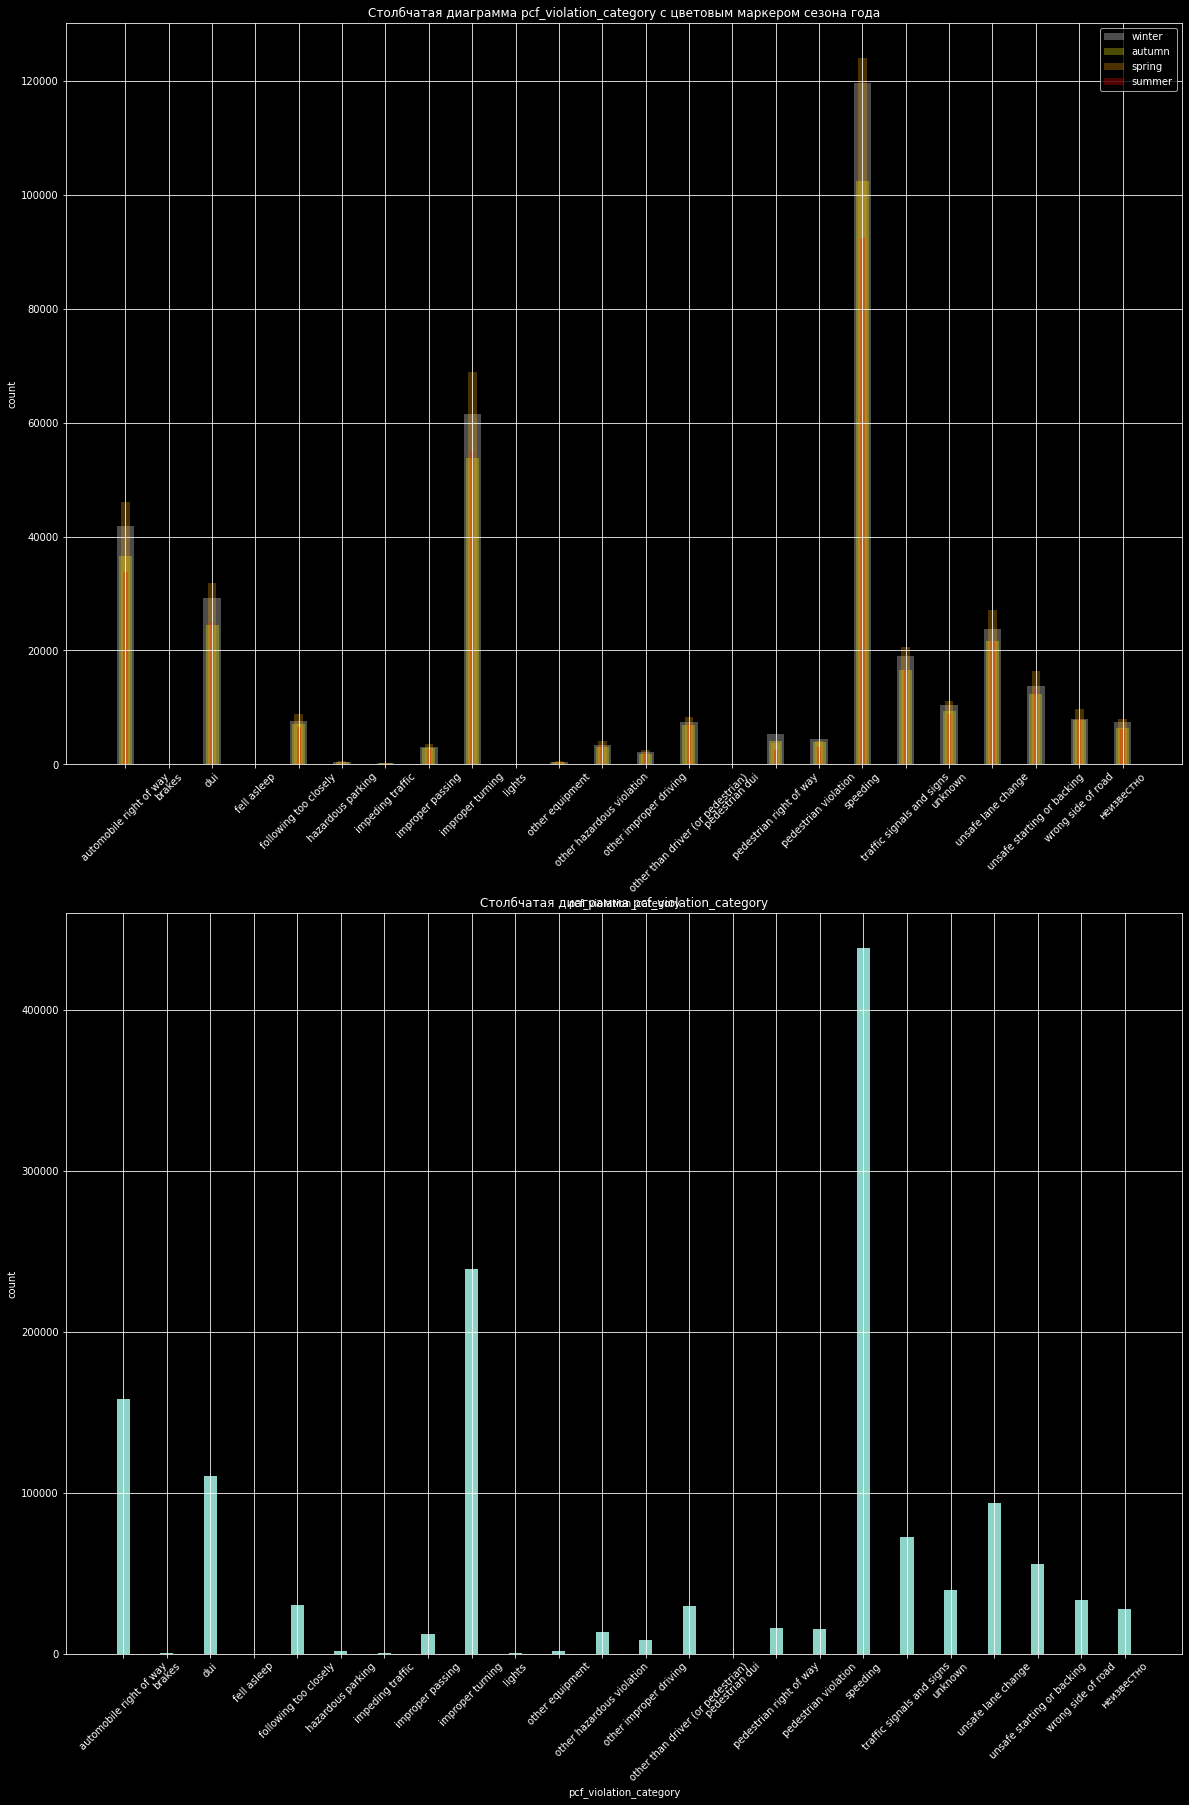

primary_collision_factor


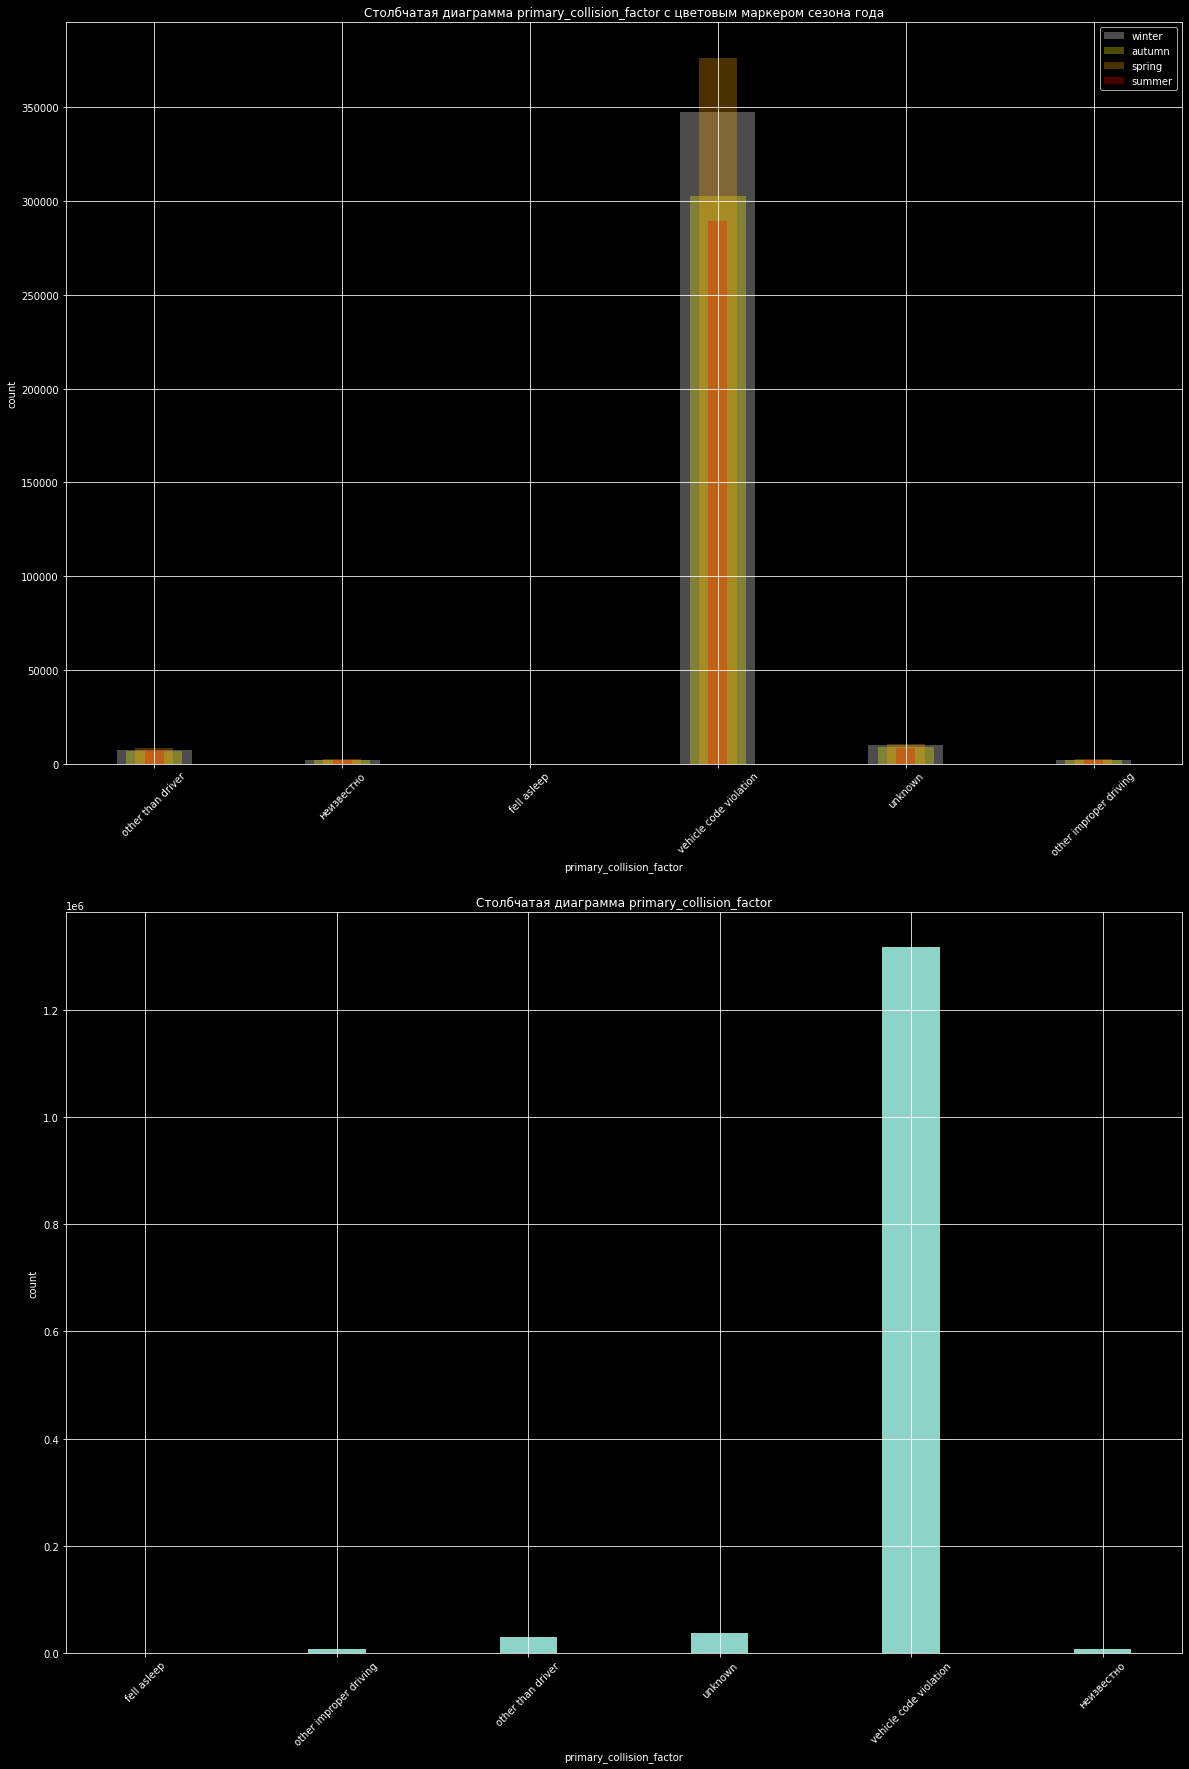

party_drug_physical


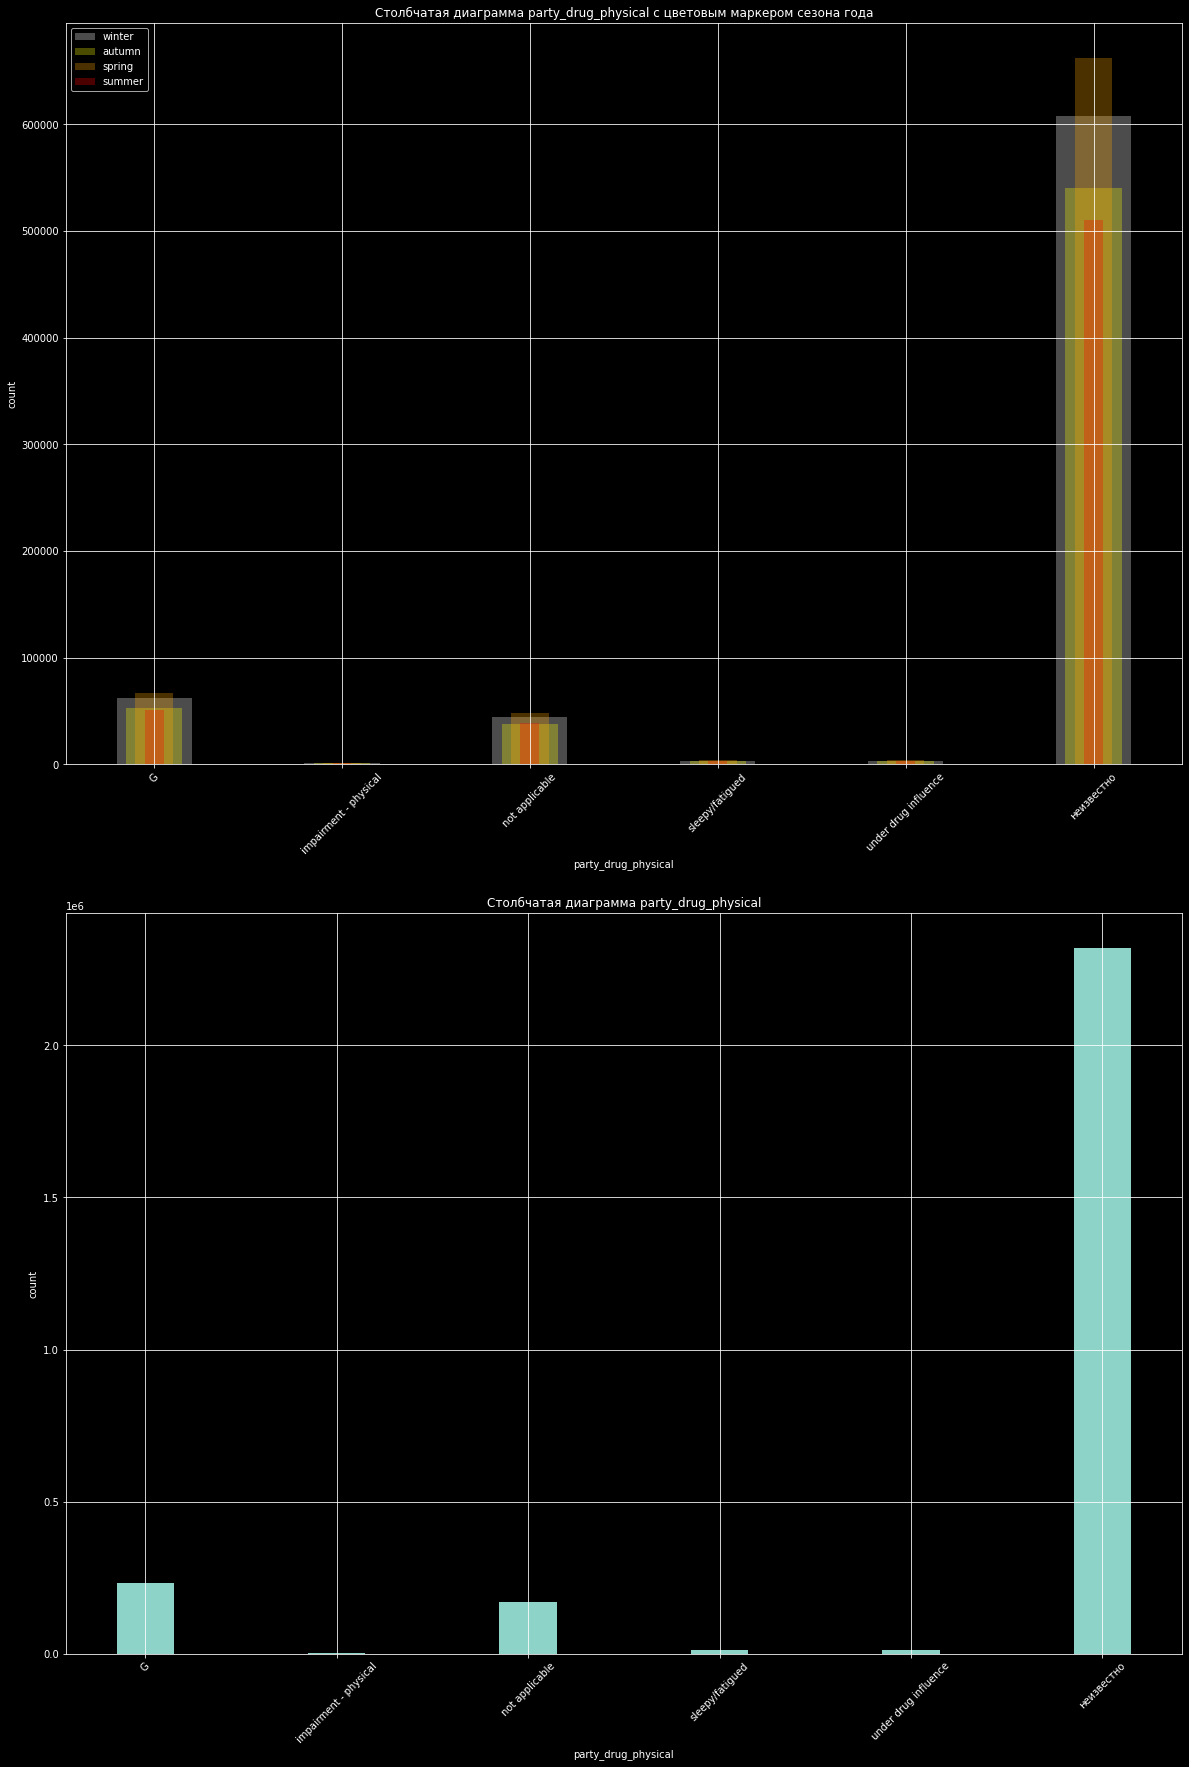

In [ ]:
for colum in ['road_surface', 'road_condition_1', 'location_type',
              'weather_1', 'lighting', 'direction',
              'control_device', 'motor_vehicle_involved_with',
              'type_of_collision', 'pcf_violation_category',
              'primary_collision_factor', 'party_drug_physical']:
    if colum == 'party_drug_physical':
        query = """
            SELECT
                COALESCE(p.{colum}, 'неизвестно') AS {colum},
                CASE
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                    ELSE 'autumn'
                END AS seasons_of_the_year,
                COUNT(*) AS count
            FROM parties p
            LEFT JOIN collisions c ON p.case_id = c.case_id
            GROUP BY COALESCE(p.{colum}, 'неизвестно'),
                CASE
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                    ELSE 'autumn'
                END
        """.format(colum=colum)
        x = pd.read_sql_query(query, con=engine)

        query = """
            SELECT
                COALESCE(p.{colum}, 'неизвестно') AS {colum},
                COUNT(*) AS count
            FROM parties p
            GROUP BY COALESCE(p.{colum}, 'неизвестно')
        """.format(colum=colum)
        y = pd.read_sql_query(query, con=engine)
    else:
        query = """
            SELECT
                COALESCE(c.{colum}, 'неизвестно') AS {colum},
                CASE
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                    ELSE 'autumn'
                END AS seasons_of_the_year,
                COUNT(*) AS count
            FROM collisions c
            GROUP BY COALESCE(c.{colum}, 'неизвестно'),
                CASE
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                    WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                    ELSE 'autumn'
                END
        """.format(colum=colum)
        x = pd.read_sql_query(query, con=engine)

        query = """
            SELECT
                COALESCE(c.{colum}, 'неизвестно') AS {colum},
                COUNT(*) AS count
            FROM collisions c
            GROUP BY COALESCE(c.{colum}, 'неизвестно')
        """.format(colum=colum)
        y = pd.read_sql_query(query, con=engine)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 30))
    print(colum)
    x_values = x[colum].unique()
    for color, row, width in (['white', 'winter', 0.4],
                            ['yellow', 'autumn', 0.3],
                            ['orange', 'spring', 0.2],
                            ['red', 'summer', 0.1]):
        if colum == 'party_drug_physical':
            query = """
                SELECT
                    COALESCE(p.{colum}, 'неизвестно') AS {colum},
                    COUNT(*) AS count
                FROM parties p
                LEFT JOIN collisions c ON p.case_id = c.case_id
                WHERE
                    CASE
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                        ELSE 'autumn'
                    END = '{row}'
                GROUP BY COALESCE(p.{colum}, 'неизвестно')
            """.format(colum=colum, row=row)
            x_row = pd.read_sql_query(query, con=engine)
        else:
            query = """
                SELECT
                    COALESCE(c.{colum}, 'неизвестно') AS {colum},
                    COUNT(*) AS count
                FROM collisions c
                WHERE
                    CASE
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (12, 1, 2) THEN 'winter'
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (3, 4, 5) THEN 'spring'
                        WHEN EXTRACT(MONTH FROM c.collision_date) IN (6, 7, 8) THEN 'summer'
                        ELSE 'autumn'
                    END = '{row}'
                GROUP BY COALESCE(c.{colum}, 'неизвестно')
            """.format(colum=colum, row=row)
            x_row = pd.read_sql_query(query, con=engine)
        x_row = x_row.set_index(colum).reindex(x_values).fillna(0)
        ax[0].bar(x_values, x_row['count'], alpha=0.3, color=color, width=width, label=row)
    ax[0].set_xticks(range(len(x_values)))
    ax[0].set_xticklabels(x_values, rotation=45)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Столбчатая диаграмма ' + colum + ' с цветовым маркером сезона года')
    ax[0].grid(True)

    ax[1].bar(y[colum], y['count'], width=0.3)
    ax[1].set_xticks(range(len(y[colum])))
    ax[1].set_xticklabels(y[colum], rotation=45)
    ax[1].set_title('Столбчатая диаграмма ' + colum)
    ax[1].set_xlabel(colum)
    ax[1].set_ylabel('count')
    ax[1].grid(True)
    plt.show()

-'road_surface'(состояние дороги) на влажной дороге ДТП значительно чаще в зимнем сезоне и реже в летнем. На сухой дороге +- ДТП по сезонам происходят одинакого часто, чуть чаще весной (вероятно это потому что в данных баланс классов по сезонам чуть смещен к весеннему)

-'road_condition_1'(состояние дорожного полотна) чуть больше на нормальной дороге преобладают ДТП весной (баланс классов). Остальные состояния дороги +- равномерные пропорции по сезонам года

-'location_type'(тип дороги) +- равномерные пропорции по сезонам года

-'weather_1'(погода) облачная, туманная, дождливая погода в момент ДТП преобладает во все кроме летнего сезона, больше в зимний. Ясная погода в летний сезон

-'lighting'(освещенность) дневной свет при ДТП чуть преобладает летом и осенью, темная освещенность при ДТП чаще в зимний сезон

-'direction'(направление движения на перекрестке) +- равномерные пропорции по сезонам года

-'control_device'(состояние устройств управления) +- равномерные пропорции по сезонам года

-'motor_vehicle_involved_with'(дополнительные участники ДТП) не столкновение и участие велосепидиста в ДТП чаще в летний сезон

-'type_of_collision'(тип столкновения) опрокидывание чуть чаще в летний сезон

-'pcf_violation_category'(категория нарушения, приведшего к ДТП) нарушение пешехода и право прохода пешехода чаще в зимний сезон, осатльные категории нарушения соблюдают +- равномерные пропорции по сезонам года

-'primary_collision_factor'(основная причина ДТП) +- равномерные пропорции по сезонам года

-'party_drug_physical'(состояние участника ДТП) сонных или уставших участников ДТП чуть больше в летний сезон

## Подготовка данных для моделирования

Создайте модель для оценки водительского риска
Подготовьте набор данных на основе первичного предположения заказчика:

Выберите тип виновника — только машина (car).

Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).

Для моделирования возьмите данные только за 2012 год.

In [ ]:
query = """
SELECT v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age,
       c.case_id::integer,
       c.party_count::integer,
       c.county_city_location,
       c.county_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.primary_collision_factor,
       c.pcf_violation_category,
       c.type_of_collision,
       c.motor_vehicle_involved_with,
       c.road_surface,
       c.road_condition_1,
       c.lighting,
       c.control_device,
       to_char(c.collision_date, 'day') AS day_of_week,
       EXTRACT(hour FROM c.collision_time) AS time_of_day,
       p.party_type,
       p.at_fault,
       p.insurance_premium,
       p.party_sobriety,
       p.party_drug_physical,
       p.cellphone_in_use
FROM collisions c
LEFT JOIN parties p ON c.case_id = p.case_id
LEFT JOIN vehicles v ON c.case_id = v.case_id
WHERE p.party_type = 'car'
AND c.collision_damage != 'scratch'
AND EXTRACT(YEAR FROM c.collision_date) = 2012
AND v.vehicle_age IS NOT NULL
"""

df_model = pd.read_sql_query(query, con=engine)
df_model.head()

vehicle_type vehicle_transmission  vehicle_age  case_id  party_count  \
0        sedan               manual            4  5467284            5   
1        sedan               manual            0  5468100            2   
2        sedan                 auto            2  5468100            2   
3        sedan                 auto            4  5468710            4   
4        coupe               manual            7  5480041            2   

  county_city_location county_location  distance direction  intersection  ...  \
0                 3900     san joaquin     120.0      west           0.0  ...   
1                 3045          orange     200.0     north           0.0  ...   
2                 3045          orange     200.0     north           0.0  ...   
3                 1900     los angeles      35.0     north           0.0  ...   
4                 1965     los angeles       0.0      None           1.0  ...   

                     lighting control_device day_of_week time_of_day  \
0  dark with no street lights           none   tuesday           5.0   
1                dusk or dawn           none   tuesday          18.0   
2                dusk or dawn           none   tuesday          18.0   
3                    daylight           none   tuesday          12.0   
4                    daylight    functioning   sunday            8.0   

  party_type at_fault insurance_premium         party_sobriety  \
0        car        0              43.0  had not been drinking   
1        car        1              18.0  had not been drinking   
2        car        1              18.0  had not been drinking   
3        car        1              67.0  had not been drinking   
4        car        0              44.0  had not been drinking   

  party_drug_physical cellphone_in_use  
0                None              0.0  
1                None              0.0  
2                None              0.0  
3                None              0.0  
4                None              0.0  

[5 rows x 28 columns]

In [ ]:
len(df_model)

115046

In [ ]:
df_model.isna().mean()

vehicle_type                   0.000000
vehicle_transmission           0.011274
vehicle_age                    0.000000
case_id                        0.000000
party_count                    0.000000
county_city_location           0.000000
county_location                0.000000
distance                       0.000000
direction                      0.241660
intersection                   0.003060
weather_1                      0.003320
location_type                  0.528536
primary_collision_factor       0.002077
pcf_violation_category         0.014255
type_of_collision              0.005259
motor_vehicle_involved_with    0.002608
road_surface                   0.006284
road_condition_1               0.004737
lighting                       0.002825
control_device                 0.003790
day_of_week                    0.000000
time_of_day                    0.001052
party_type                     0.000000
at_fault                       0.000000
insurance_premium              0.042174


In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115046 entries, 0 to 115045
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   vehicle_type                 115046 non-null  object 
 1   vehicle_transmission         113749 non-null  object 
 2   vehicle_age                  115046 non-null  int64  
 3   case_id                      115046 non-null  int64  
 4   party_count                  115046 non-null  int64  
 5   county_city_location         115046 non-null  object 
 6   county_location              115046 non-null  object 
 7   distance                     115046 non-null  float64
 8   direction                    87244 non-null   object 
 9   intersection                 114694 non-null  float64
 10  weather_1                    114664 non-null  object 
 11  location_type                54240 non-null   object 
 12  primary_collision_factor     114807 non-null  object 
 13 

Проведите первичный отбор факторов, необходимых для модели.

Изучите описание факторов. Нужно отобрать те, которые могут влиять на вероятность ДТП.

Будет хорошо, если вы аргументируете свой выбор.

**case_id** - случайный номинальный признак. Отбрасываем признак

**party_number** - нумерация участников дтп, вероятно учитывая высокую корреляцию с целевым признаком нумерация происходила после выяснения виновника в дтп. Отбрасываем признак

**party_type** - т.к. у нас тип выбран 'car', отот признак не имеет смысла. Отбрасываем признак

<font color='green'>**at_fault**</font> - целевой признак. Оставляем в выборке

**insurance_premium** - страховая премия выплачивается после выяснения виновника в дтп. Отбрасываем признак

<font color='green'>**party_sobriety**</font> - трезвость участника дтп должна влиять на целевой признак. Оставляем в выборке

**party_drug_physical** - состояние участника дтп должна влиять на целевой признак, имеет 92% пропусков. Отбрасываем признак

<font color='green'>**cellphone_in_use**</font> - использовался ли телефон во время вождения. Оставляем в выборке

**county_city_location** - номер географического района имеет схожую 'природу' с **county_location**. Оставим только <font color='green'>**county_location**</font>

<font color='green'>**distance**</font> - расстояние до главной дороги. Оставляем в выборке

**direction** - низкая корреляция и много пропусков. Отбрасываем признак

**intersection** - есть в значении признака **location_type**. Отбрасываем признак

<font color='green'>**weather_1**</font> - состояние погоды. Оставляем в выборке

**location_type** - тип дороги, много пропусков. Отбрасываем признак

**collision_damage**- серьезность дтп. Оставляем в выборке

<font color='green'>**party_count**</font> - число участников дтп, чем больше участников тем меньше вероятность признания виновным в дтп. Оставляем в выборке

**primary_collision_factor** - оснавная причина дтп, скорее всего его значение  повлечет утечку целевого признака. Отбрасываем признак

**pcf_violation_category** - категория нарушения, те же причины что и **primary_collision_factor**. Отбрасываем признак

<font color='green'>**type_of_collision**</font> - тип столкновения. Оставляем в выборке

<font color='green'>**motor_vehicle_involved_with**</font> - дополнительные участники дтп, вероятно что если это не другой автомобиль то вероятность признания виновным увеличивается. Оставляем в выборке

<font color='green'>**road_surface**</font> - состояние дороги. Оставляем в выборке

<font color='green'>**road_condition_1**</font> - состояние дорожного полотна. Оставляем в выборке

<font color='green'>**lighting**</font> - освещение, вероятно виновники дтп более склонны 'гонять' по плохо освещенной местности. Оставляем в выборке

**control_device** - много пропусков. Отбрасываем признак

**collision_datetime** - возьмем выведенное из этого признака значение <font color='green'>**day_of_week**</font>. Его и оставим в выборке

**collision_time** - возьмем выведенное из этого признака значение <font color='green'>**time_of_day**</font>. Его и оставим в выборке

**vehicle_type** - тип кузова автомобиля. Отбрасываем признак

**vehicle_transmission** - тип кпп автомобиля. Отбрасываем признак

<font color='green'>**vehicle_age**</font> - возраст автомобиля в годах. Оставляем в выборке

In [ ]:
model_feat = ['at_fault', 'party_sobriety', 'cellphone_in_use', 'county_location',
              'distance', 'weather_1', 'party_count',
              'type_of_collision', 'motor_vehicle_involved_with', 'road_surface',
              'road_condition_1', 'lighting', 'time_of_day', 'day_of_week', 'vehicle_age']

In [ ]:
df_model = df_model[model_feat]

In [ ]:
df_model.isna().mean()

at_fault                       0.000000
party_sobriety                 0.014472
cellphone_in_use               0.089347
county_location                0.000000
distance                       0.000000
weather_1                      0.003320
party_count                    0.000000
type_of_collision              0.005259
motor_vehicle_involved_with    0.002608
road_surface                   0.006284
road_condition_1               0.004737
lighting                       0.002825
time_of_day                    0.001052
day_of_week                    0.000000
vehicle_age                    0.000000
dtype: float64

In [ ]:
df_model.head()

at_fault         party_sobriety  cellphone_in_use county_location  \
0         0  had not been drinking               0.0     san joaquin   
1         1  had not been drinking               0.0          orange   
2         1  had not been drinking               0.0          orange   
3         1  had not been drinking               0.0     los angeles   
4         0  had not been drinking               0.0     los angeles   

   distance weather_1  party_count type_of_collision  \
0     120.0     clear            5          rear end   
1     200.0     clear            2          rear end   
2     200.0     clear            2          rear end   
3      35.0     clear            4         sideswipe   
4       0.0     clear            2         broadside   

  motor_vehicle_involved_with road_surface road_condition_1  \
0         other motor vehicle          dry           normal   
1         other motor vehicle          dry           normal   
2         other motor vehicle          dry           normal   
3        parked motor vehicle          dry           normal   
4         other motor vehicle          dry           normal   

                     lighting  time_of_day day_of_week  vehicle_age  
0  dark with no street lights          5.0   tuesday              4  
1                dusk or dawn         18.0   tuesday              0  
2                dusk or dawn         18.0   tuesday              2  
3                    daylight         12.0   tuesday              4  
4                    daylight          8.0   sunday               7

In [ ]:
model_feat

['at_fault',
 'party_sobriety',
 'cellphone_in_use',
 'county_location',
 'distance',
 'weather_1',
 'party_count',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'road_surface',
 'road_condition_1',
 'lighting',
 'time_of_day',
 'day_of_week',
 'vehicle_age']

In [ ]:
cat_col = model_feat
num_col = ['distance', 'vehicle_age', 'time_of_day']

In [ ]:
cat_col.remove('time_of_day')
cat_col.remove('distance')
cat_col.remove('vehicle_age')
cat_col.remove('at_fault')

In [ ]:
df_model[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115046 entries, 0 to 115045
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   party_sobriety               113381 non-null  object 
 1   cellphone_in_use             104767 non-null  float64
 2   county_location              115046 non-null  object 
 3   weather_1                    114664 non-null  object 
 4   party_count                  115046 non-null  int64  
 5   type_of_collision            114441 non-null  object 
 6   motor_vehicle_involved_with  114746 non-null  object 
 7   road_surface                 114323 non-null  object 
 8   road_condition_1             114501 non-null  object 
 9   lighting                     114721 non-null  object 
 10  day_of_week                  115046 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 9.7+ MB


Некорректный тип данных для категориального по смыслу признака, исправим это:

In [ ]:
df_model['cellphone_in_use'] = df_model['cellphone_in_use'].apply(lambda x: '1' if x == 1 else '0' if x == 0 else x)
df_model['cellphone_in_use'].unique()

array(['0', nan, '1'], dtype=object)

## Исследовательский анализ тренировочных данных

party_sobriety
[57866, 0, 1440, 370, 314, 104, 317]
[104, 314, 370, 57866, 1440, 317, 0]
['had not been drinking', 'неизвестно', 'impairment unknown', 'had been drinking, under influence', 'had been drinking, not under influence', 'had been drinking, impairment unknown', 'not applicable']
['had been drinking, impairment unknown', 'had been drinking, not under influence', 'had been drinking, under influence', 'had not been drinking', 'impairment unknown', 'not applicable', 'неизвестно']
[41295, 0, 4378, 5990, 639, 432, 236]
[432, 639, 5990, 41295, 4378, 236, 0]
['had not been drinking', 'неизвестно', 'impairment unknown', 'had been drinking, under influence', 'had been drinking, not under influence', 'had been drinking, impairment unknown', 'not applicable']
['had been drinking, impairment unknown', 'had been drinking, not under influence', 'had been drinking, under influence', 'had not been drinking', 'impairment unknown', 'not applicable', 'неизвестно']


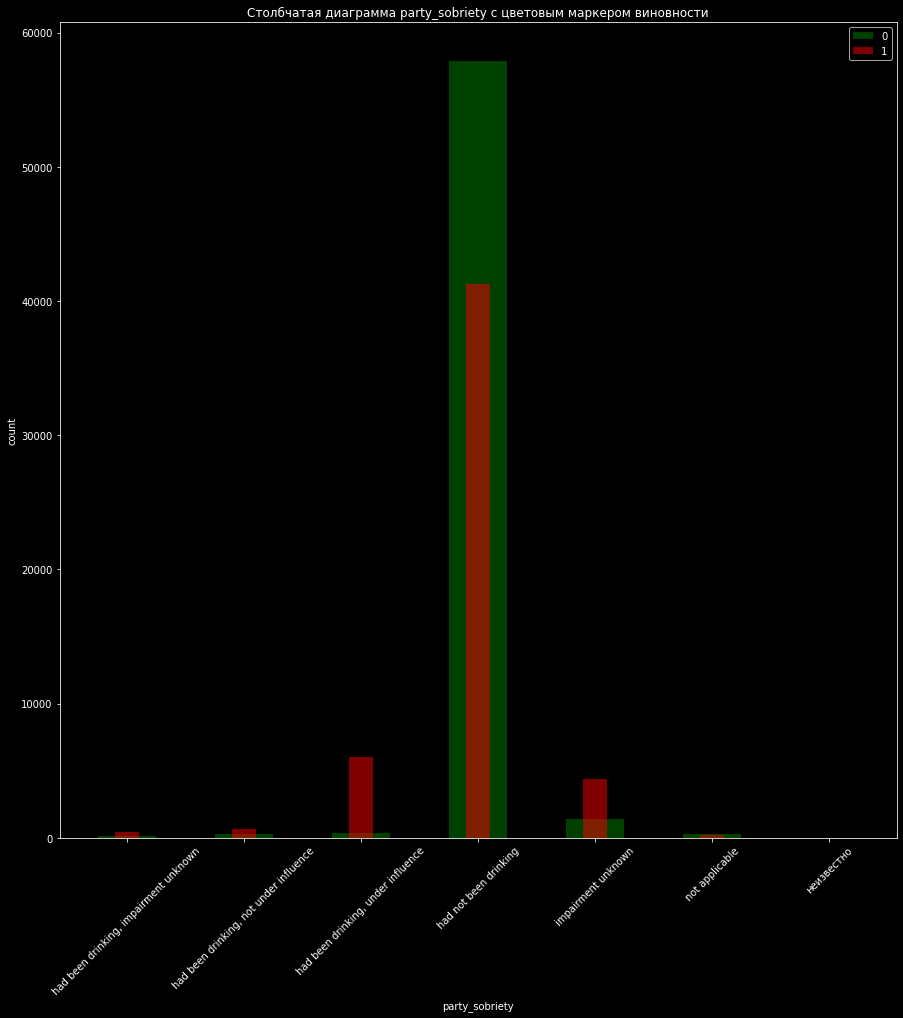

cellphone_in_use
[55003, 0, 1133]
[55003, 1133, 0]
['0', 'неизвестно', '1']
['0', '1', 'неизвестно']
[47542, 0, 1089]
[47542, 1089, 0]
['0', 'неизвестно', '1']
['0', '1', 'неизвестно']


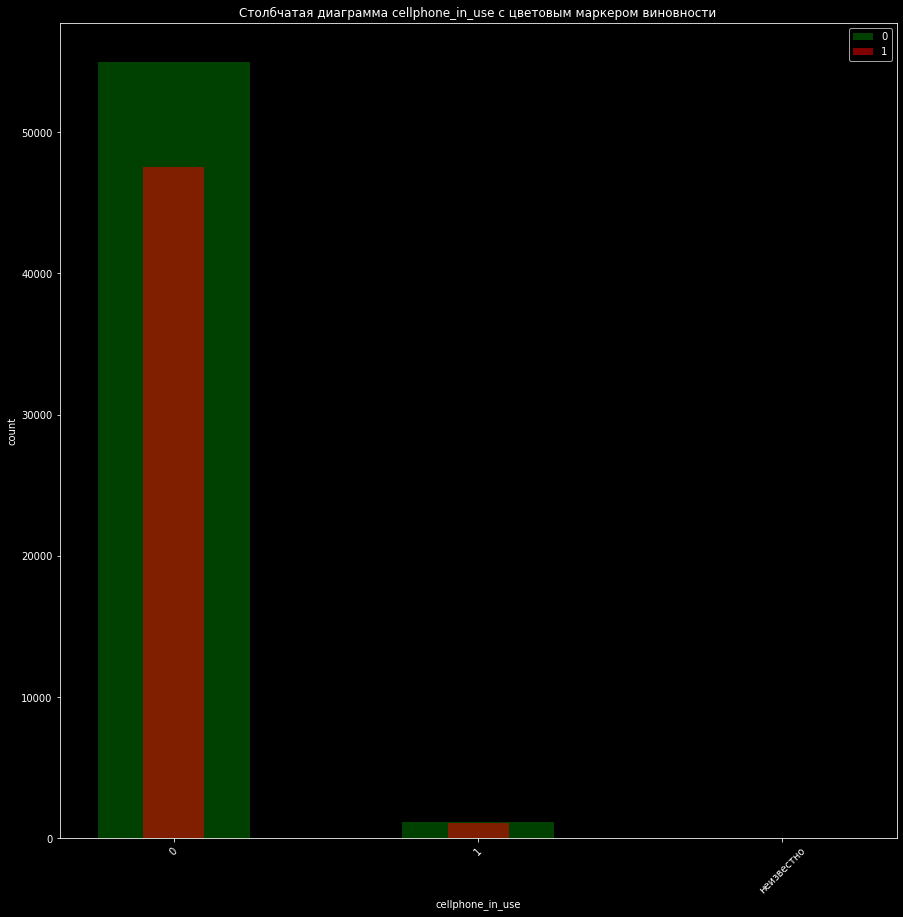

county_location
[893, 6387, 19478, 2209, 3933, 949, 582, 2547, 3931, 1059, 3605, 450, 2052, 583, 1534, 552, 279, 561, 89, 356, 184, 305, 249, 1101, 389, 798, 236, 718, 665, 661, 118, 212, 1294, 89, 255, 109, 175, 33, 47, 201, 63, 367, 116, 13, 141, 51, 41, 31, 42, 36, 105, 4, 8, 13, 62, 35, 4, 19]
[2052, 8, 47, 255, 89, 41, 1059, 42, 212, 949, 19, 249, 175, 31, 1294, 236, 63, 33, 19478, 305, 389, 36, 118, 367, 13, 35, 552, 184, 116, 6387, 583, 4, 3605, 2547, 62, 3933, 3931, 582, 893, 356, 1101, 718, 2209, 450, 201, 4, 51, 561, 665, 798, 141, 109, 13, 661, 105, 1534, 279, 89]
['san joaquin', 'orange', 'los angeles', 'santa clara', 'san bernardino', 'fresno', 'san francisco', 'sacramento', 'san diego', 'contra costa', 'riverside', 'santa cruz', 'alameda', 'placer', 'ventura', 'monterey', 'yolo', 'solano', 'yuba', 'san luis obispo', 'napa', 'madera', 'humboldt', 'san mateo', 'marin', 'stanislaus', 'kings', 'santa barbara', 'sonoma', 'tulare', 'mendocino', 'el dorado', 'kern', 'calaveras',

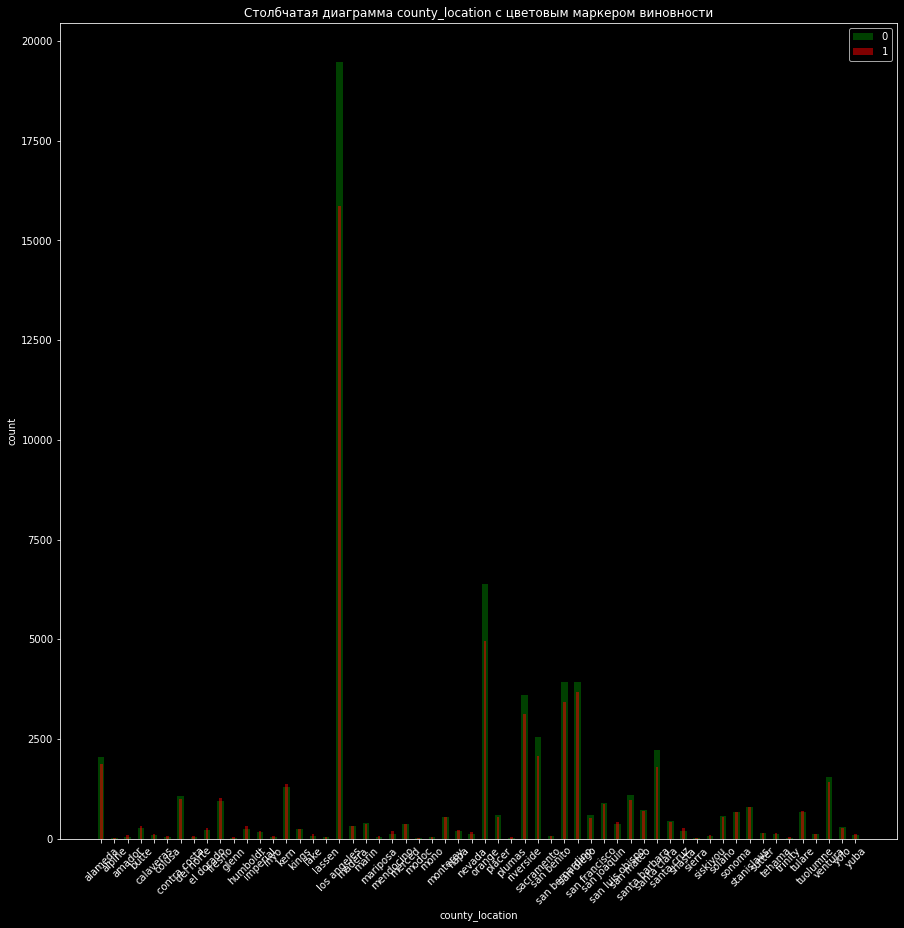

weather_1
[49997, 8452, 1986, 192, 115, 0, 30, 13]
[49997, 8452, 192, 30, 1986, 115, 13, 0]
['clear', 'cloudy', 'raining', 'fog', 'snowing', 'неизвестно', 'other', 'wind']
['clear', 'cloudy', 'fog', 'other', 'raining', 'snowing', 'wind', 'неизвестно']
[43339, 8066, 2105, 181, 148, 0, 30, 10]
[43339, 8066, 181, 30, 2105, 148, 10, 0]
['clear', 'cloudy', 'raining', 'fog', 'snowing', 'неизвестно', 'other', 'wind']
['clear', 'cloudy', 'fog', 'other', 'raining', 'snowing', 'wind', 'неизвестно']


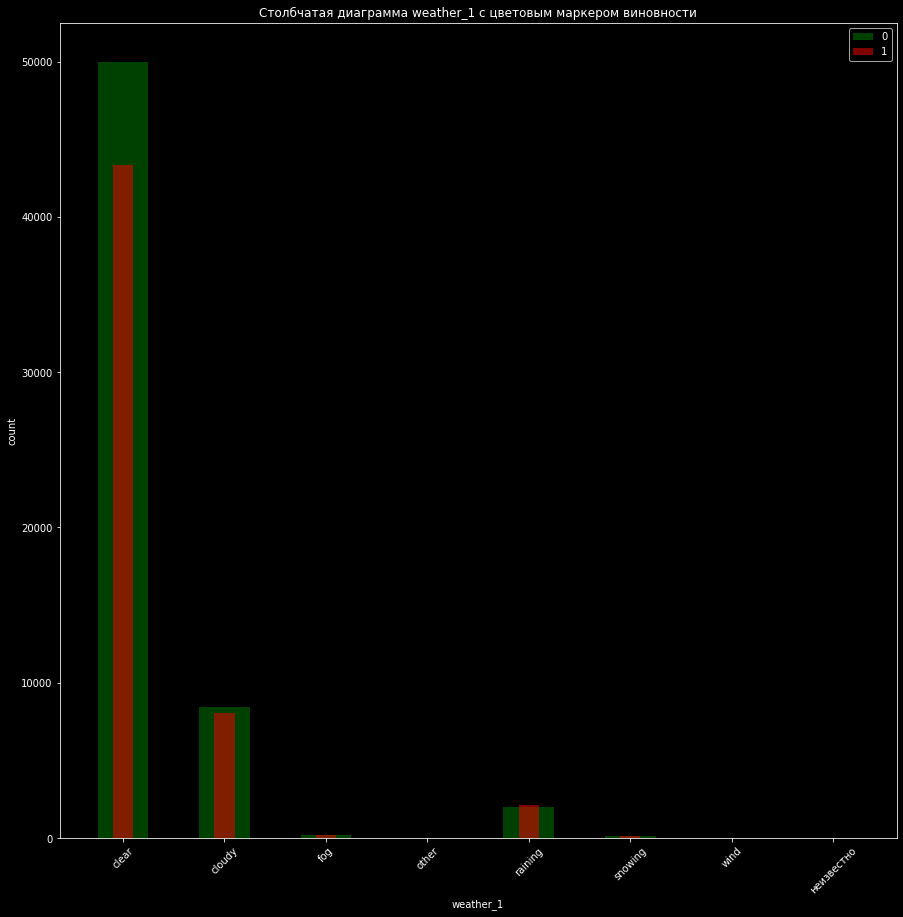

party_count
[2022, 37520, 5477, 855, 13979, 132, 645, 136, 226, 27]
[855, 37520, 13979, 5477, 2022, 645, 226, 132, 136, 27]
[5, 2, 4, 1, 3, 8, 6, 9, 7, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[631, 34402, 2103, 9133, 7522, 25, 148, 17, 43, 3]
[9133, 34402, 7522, 2103, 631, 148, 43, 25, 17, 3]
[5, 2, 4, 1, 3, 8, 6, 9, 7, 10]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


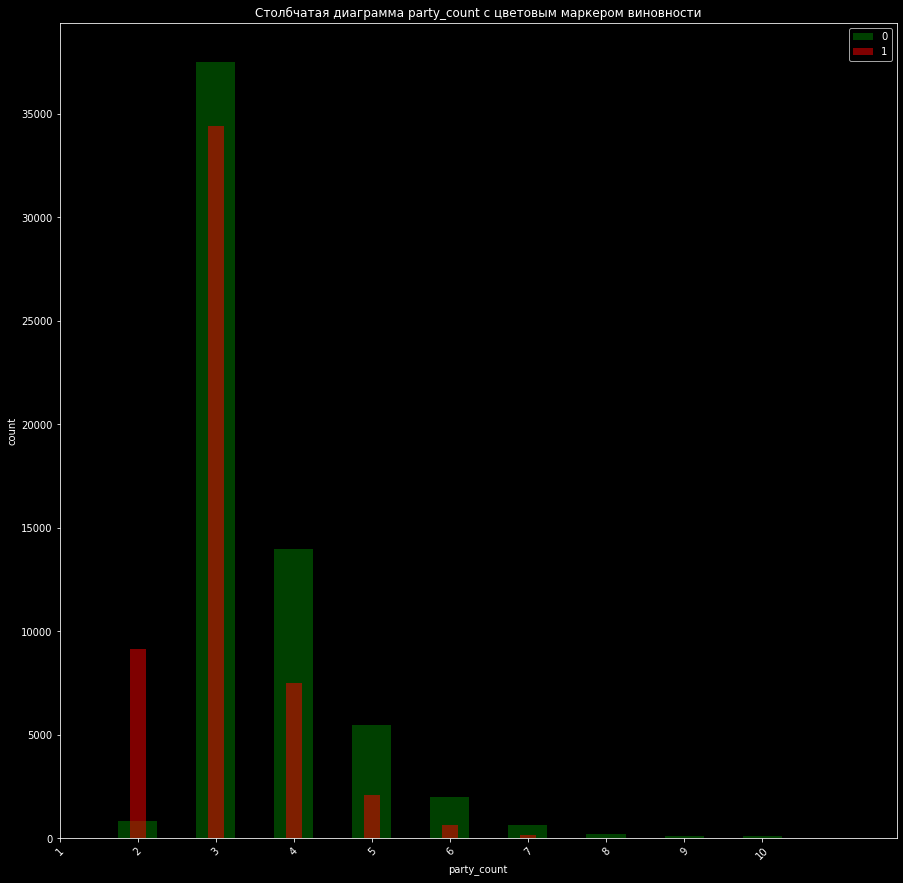

type_of_collision
[26096, 10786, 14188, 442, 3402, 2082, 3678, 0]
[14188, 3678, 2082, 3402, 442, 26096, 10786, 0]
['rear end', 'sideswipe', 'broadside', 'overturned', 'other', 'hit object', 'head-on', 'неизвестно']
['broadside', 'head-on', 'hit object', 'other', 'overturned', 'rear end', 'sideswipe', 'неизвестно']
[18220, 8492, 11245, 2224, 2580, 7882, 3124, 0]
[11245, 3124, 7882, 2580, 2224, 18220, 8492, 0]
['rear end', 'sideswipe', 'broadside', 'overturned', 'other', 'hit object', 'head-on', 'неизвестно']
['broadside', 'head-on', 'hit object', 'other', 'overturned', 'rear end', 'sideswipe', 'неизвестно']


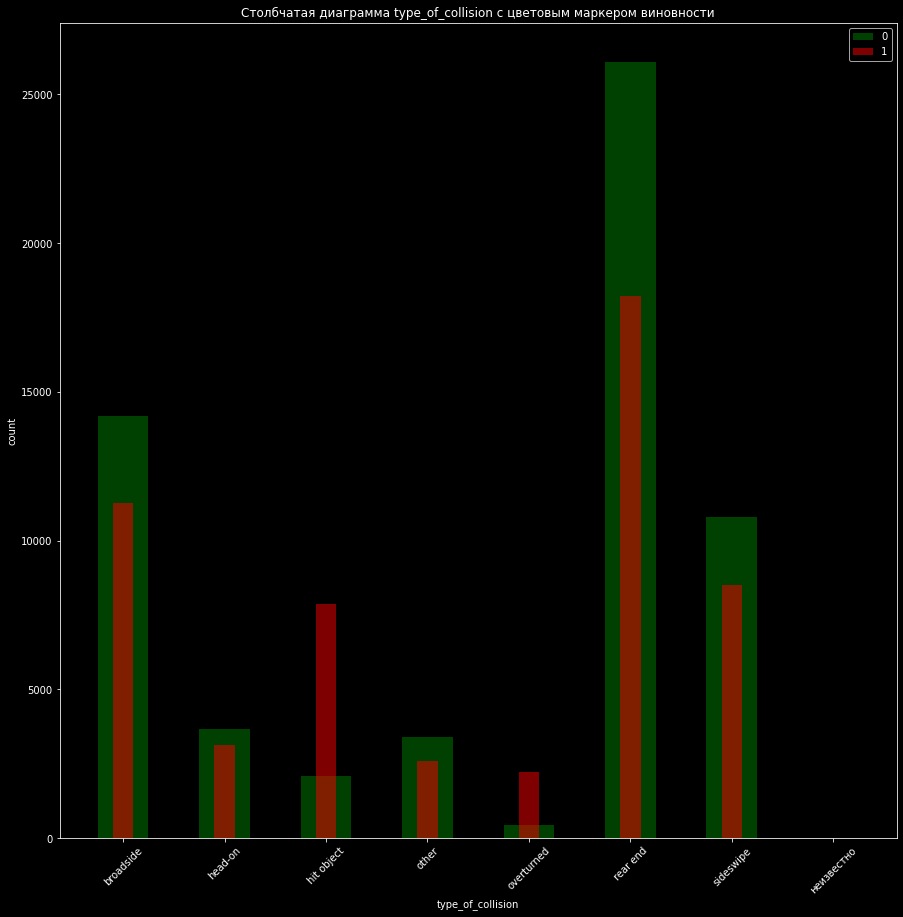

motor_vehicle_involved_with
[53165, 225, 747, 1745, 2856, 1380, 519, 211, 0, 7]
[211, 1745, 1380, 519, 747, 53165, 2856, 225, 7, 0]
['other motor vehicle', 'parked motor vehicle', 'non-collision', 'bicycle', 'other object', 'fixed object', 'motor vehicle on other roadway', 'animal', 'неизвестно', 'train']
['animal', 'bicycle', 'fixed object', 'motor vehicle on other roadway', 'non-collision', 'other motor vehicle', 'other object', 'parked motor vehicle', 'train', 'неизвестно']
[38345, 1737, 2090, 996, 2463, 7849, 370, 23, 0, 18]
[23, 996, 7849, 370, 2090, 38345, 2463, 1737, 18, 0]
['other motor vehicle', 'parked motor vehicle', 'non-collision', 'bicycle', 'other object', 'fixed object', 'motor vehicle on other roadway', 'animal', 'неизвестно', 'train']
['animal', 'bicycle', 'fixed object', 'motor vehicle on other roadway', 'non-collision', 'other motor vehicle', 'other object', 'parked motor vehicle', 'train', 'неизвестно']


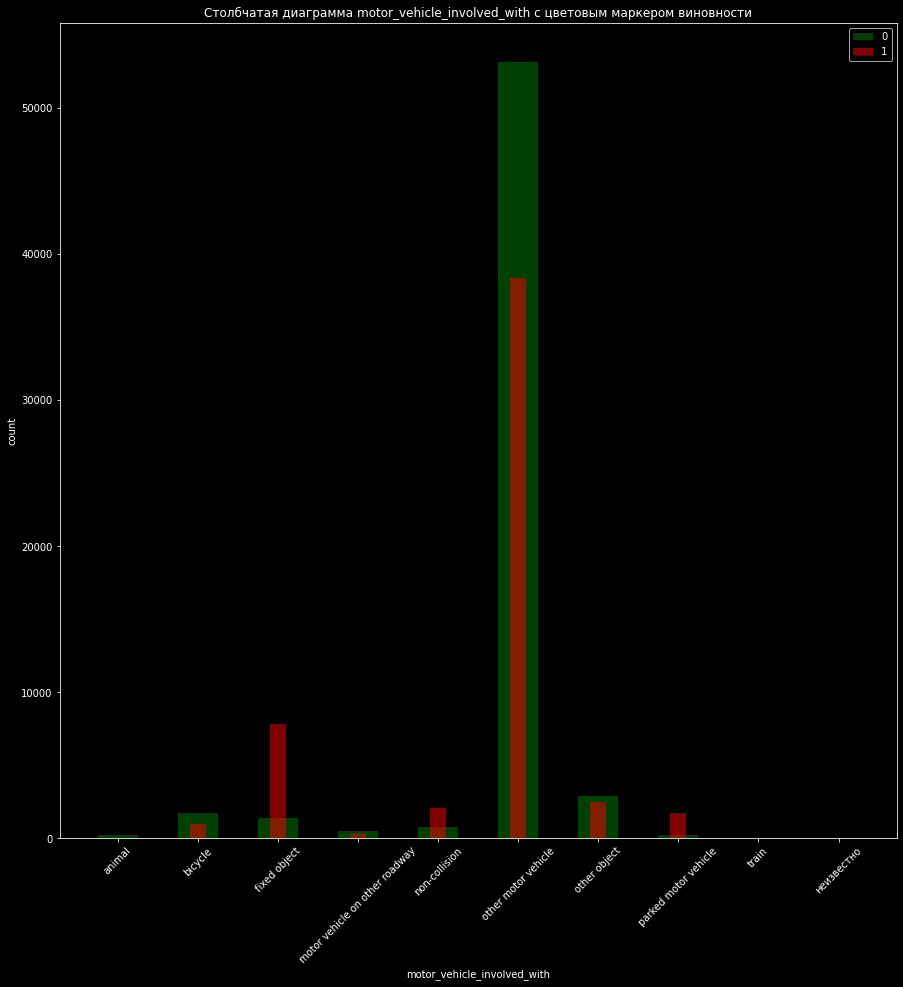

road_surface
[55621, 4745, 0, 213, 35]
[55621, 35, 213, 4745, 0]
['dry', 'wet', 'неизвестно', 'snowy', 'slippery']
['dry', 'slippery', 'snowy', 'wet', 'неизвестно']
[48253, 5078, 0, 342, 36]
[48253, 36, 342, 5078, 0]
['dry', 'wet', 'неизвестно', 'snowy', 'slippery']
['dry', 'slippery', 'snowy', 'wet', 'неизвестно']


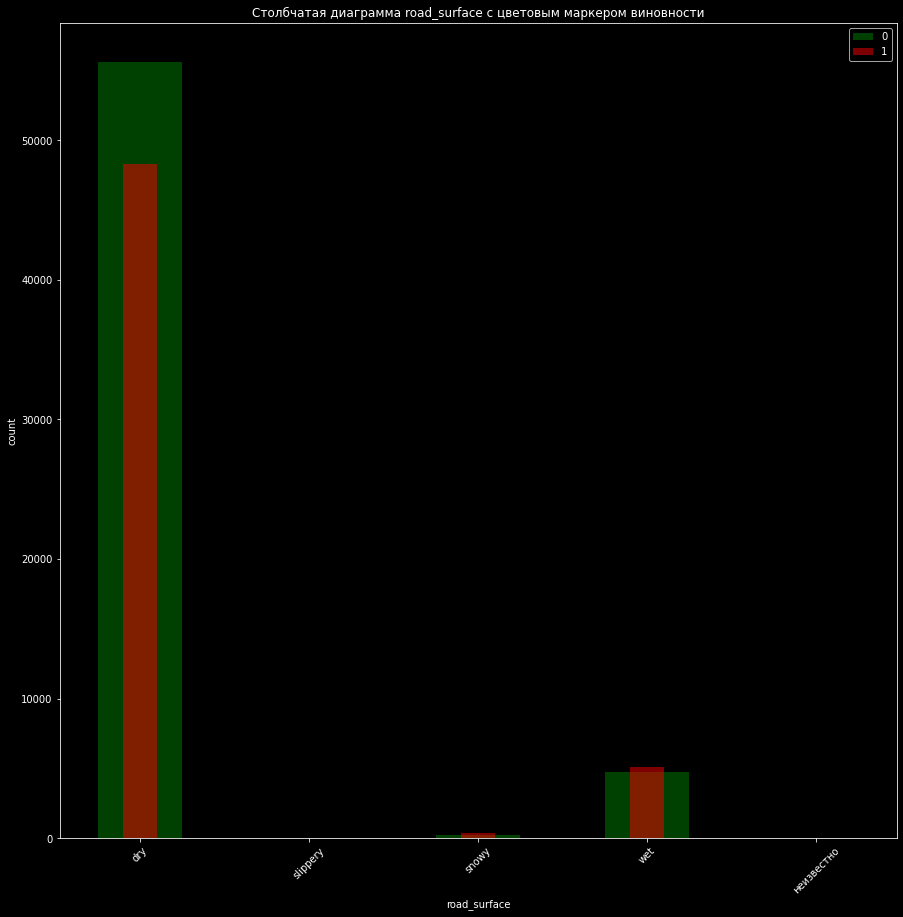

road_condition_1
[58502, 215, 1329, 239, 0, 258, 60, 75, 21]
[1329, 21, 258, 75, 58502, 239, 215, 60, 0]
['normal', 'other', 'construction', 'obstruction', 'неизвестно', 'holes', 'reduced width', 'loose material', 'flooded']
['construction', 'flooded', 'holes', 'loose material', 'normal', 'obstruction', 'other', 'reduced width', 'неизвестно']
[52048, 203, 937, 207, 0, 204, 60, 110, 33]
[937, 33, 204, 110, 52048, 207, 203, 60, 0]
['normal', 'other', 'construction', 'obstruction', 'неизвестно', 'holes', 'reduced width', 'loose material', 'flooded']
['construction', 'flooded', 'holes', 'loose material', 'normal', 'obstruction', 'other', 'reduced width', 'неизвестно']


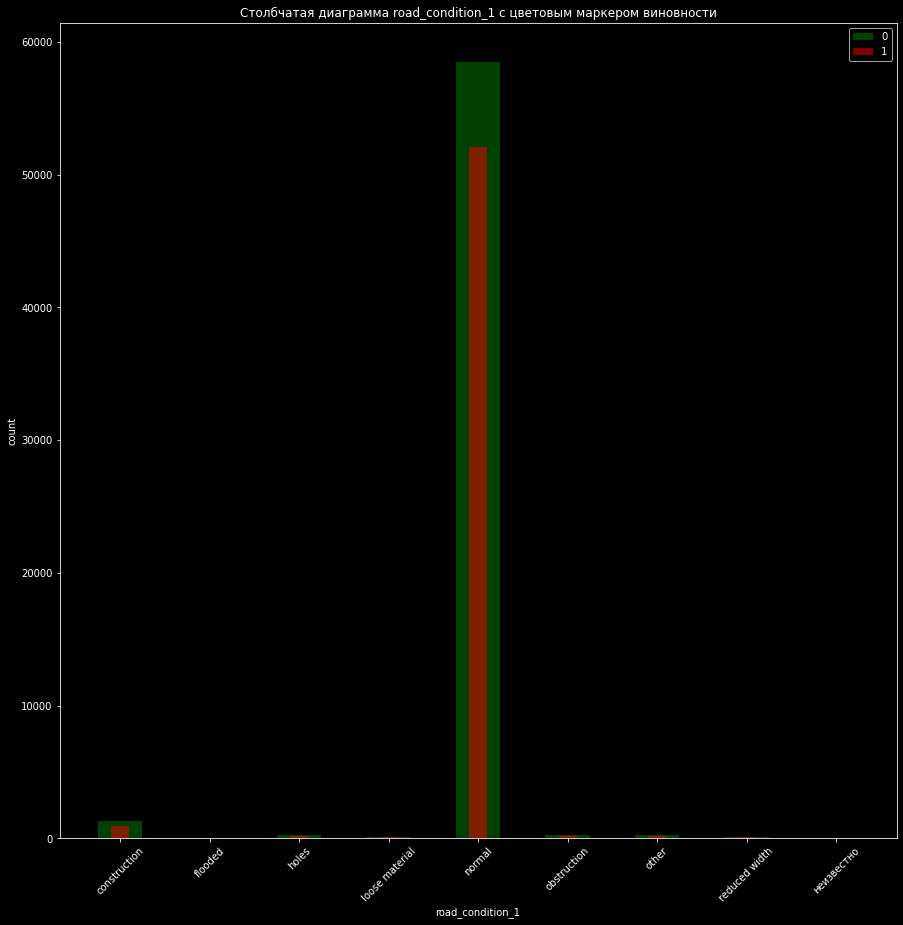

lighting
[4133, 1928, 43948, 10676, 149, 0]
[4133, 10676, 149, 43948, 1928, 0]
['dark with no street lights', 'dusk or dawn', 'daylight', 'dark with street lights', 'dark with street lights not functioning', 'неизвестно']
['dark with no street lights', 'dark with street lights', 'dark with street lights not functioning', 'daylight', 'dusk or dawn', 'неизвестно']
[4813, 1692, 36646, 10605, 131, 0]
[4813, 10605, 131, 36646, 1692, 0]
['dark with no street lights', 'dusk or dawn', 'daylight', 'dark with street lights', 'dark with street lights not functioning', 'неизвестно']
['dark with no street lights', 'dark with street lights', 'dark with street lights not functioning', 'daylight', 'dusk or dawn', 'неизвестно']


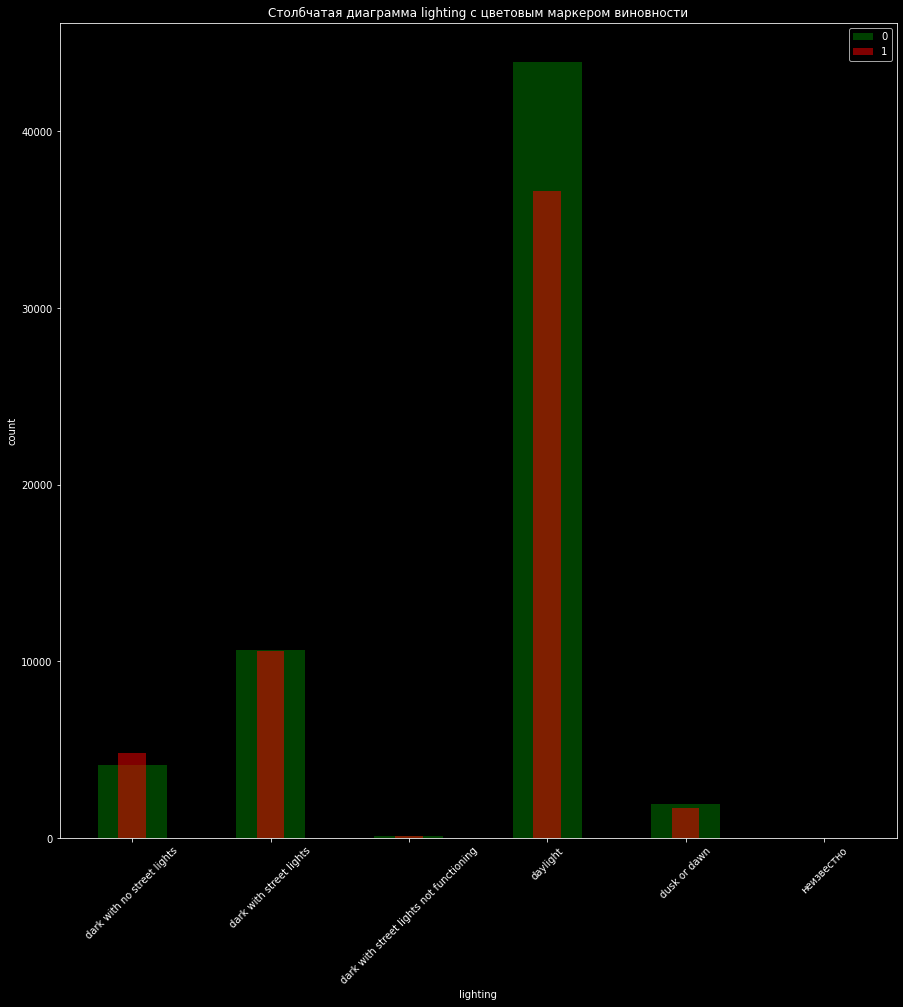

day_of_week
[8200, 7823, 8451, 7694, 9614, 10565, 8672]
[10565, 7694, 9614, 7823, 8672, 8200, 8451]
['tuesday  ', 'sunday   ', 'wednesday', 'monday   ', 'saturday ', 'friday   ', 'thursday ']
['friday   ', 'monday   ', 'saturday ', 'sunday   ', 'thursday ', 'tuesday  ', 'wednesday']
[6889, 7725, 7289, 6786, 8942, 8933, 7463]
[8933, 6786, 8942, 7725, 7463, 6889, 7289]
['tuesday  ', 'sunday   ', 'wednesday', 'monday   ', 'saturday ', 'friday   ', 'thursday ']
['friday   ', 'monday   ', 'saturday ', 'sunday   ', 'thursday ', 'tuesday  ', 'wednesday']


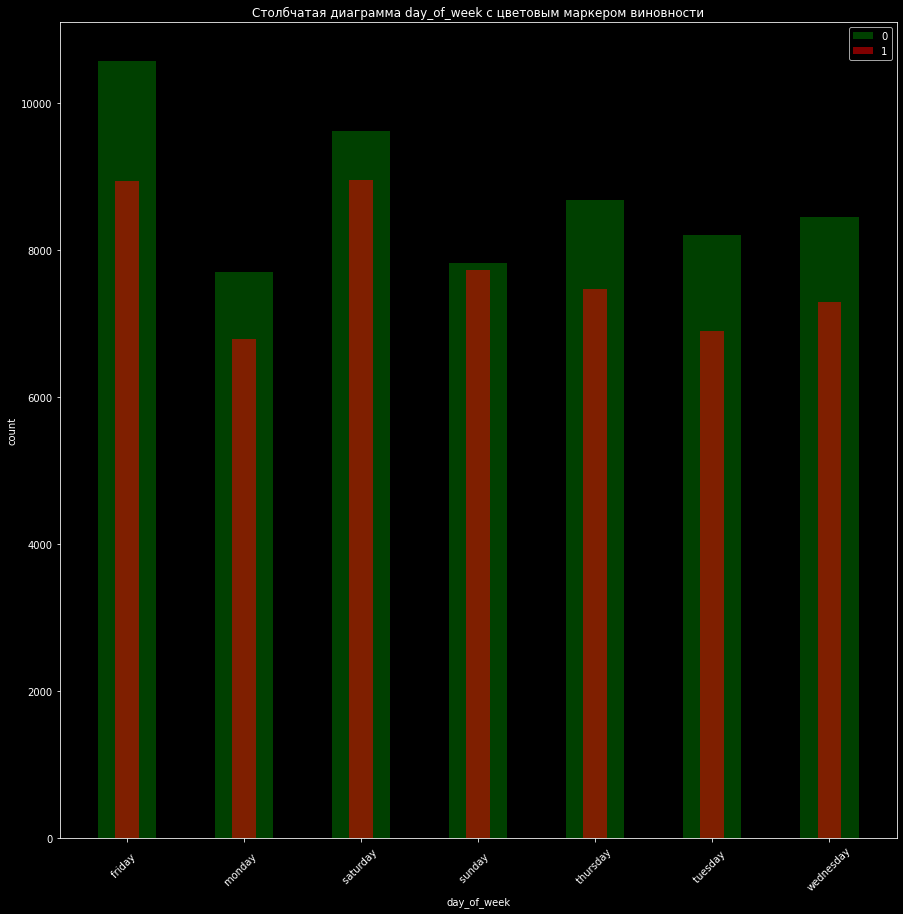

In [ ]:
for colum in cat_col:
    fig, ax = plt.subplots(figsize=(15, 15))
    print(colum)
    for color, row, width in (['green', 0, 0.5],
                            ['red', 1, 0.2]):
        y = list(df_model[colum].fillna('неизвестно').unique())
        x = []
        for i in y:
            l = df_model[(df_model['at_fault'].fillna('неизвестно') == row
                         ) & (df_model[colum].fillna('неизвестно') == i)][colum].count()
            x.append(l)
        # сортировка оси абсцисс:
        y_sub = y.copy()
        y_sub.sort()
        x_sub = []
        [x_sub.append(x[y.index(_)]) for _ in y_sub]
        print(x)
        print(x_sub)
        print(y)
        print(y_sub)
        plt.bar(y_sub, x_sub, alpha=0.5, color=color, width=width, label=row)
    ax.set_xticks(range(len(y_sub)))
    ax.set_xticklabels(y_sub, rotation=45)
    ax.set_xlabel(colum)
    ax.set_ylabel('count')
    ax.legend(loc="best")
    ax.set_title('Столбчатая диаграмма ' + colum + ' с цветовым маркером виновности')
    # plt.grid(True)
    plt.show()

-'party_sobriety'(трезвость участника ДТП) вероятность признания виновным значительно возрастает если участник ДТП находится под воздействием ПАВ

-'cellphone_in_use'(использовался ли телефон во время вождения) слегка выше вероятность признания веновным если участник ДТП использовал телефон

-'county_location'(название географического района, где произошло ДТП) ниже вероятность признания участника веновным если ДТП произошло в районе: 'los angeles', 'orange', 'santa clara'

-'weather_1'(погода) признания виновным участника ДТП чуть выше в: облачную, дождливую и снегопад

-'collision_damage'(серьезность ДТП) чуть выше признание виновным участника при повреждении отдельного элемента (под замену)

-'party_count'(число участников ДТП) пропорционально выше вероятность признания участника ДТП виновным при уменьшении кол-ва участников ДТП

-'type_of_collision'(тип столкновения) значительно выше вероятность признания виновным участника при столкновении с объектом и опрокидывании. Ниже вероятность признания виновным при боковом ударе и столкновением с задней частью автомобиля

-'motor_vehicle_involved_with'(дополнительные участники ДТП) ниже вероятнсть признания виновным: при участии дикого животного, велосипедиста, другого автомобиля. Значительно выше вероятность признания виновным при: столкновении с неподвижным объектом, не столкновением и столкновением с припаркованным автомобилем

-'road_surface'(состояние дороги) Выше вероятность признания виновным при ДТП на заснеженной дороге

-'road_condition_1'(состояние дорожного полотна) чуть выше вероятность признания виновным при нормальном состоянии дорожного полотна

-'lighting'(освещенность) выше вероятность признания виновным на ДТП при темном уличным ослвещении, ниже вероятность признания виновным при дневном свет


-'day_of_week'(день недели когда произошло ДТП) чуть выше пероятность признания виновным при ДТП во вторник и среду



distance
count    1.150460e+05
mean     7.446556e+02
std      7.000611e+03
min      0.000000e+00
25%      3.000000e+00
50%      1.200000e+02
75%      5.280000e+02
max      1.584000e+06
Name: distance, dtype: float64


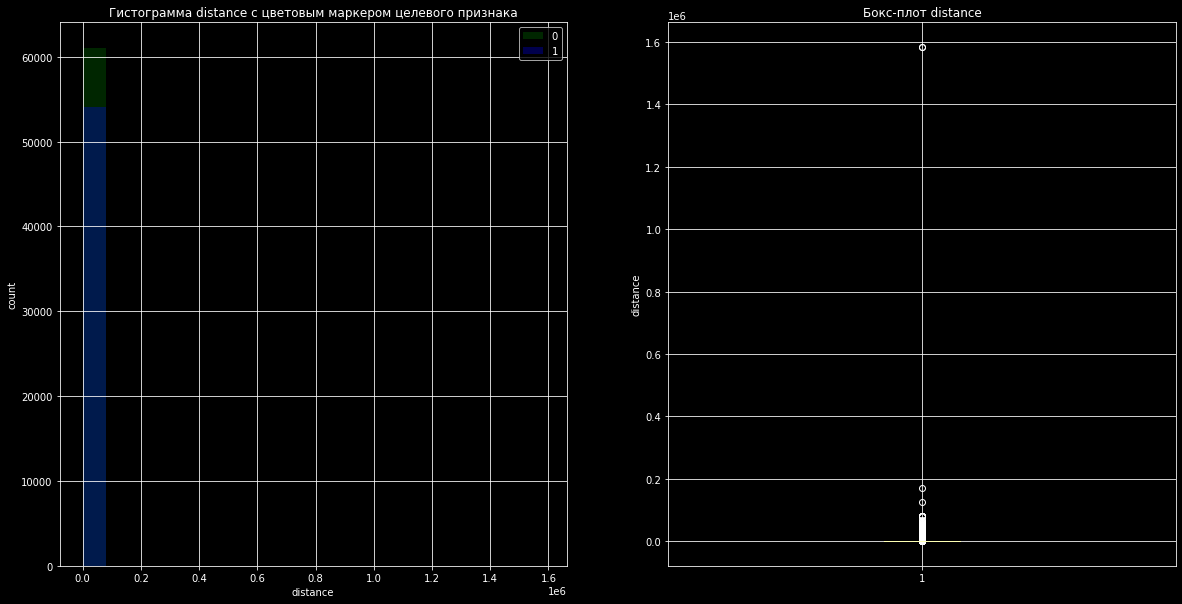

vehicle_age
count    115046.000000
mean          4.908263
std           3.266265
min           0.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         161.000000
Name: vehicle_age, dtype: float64


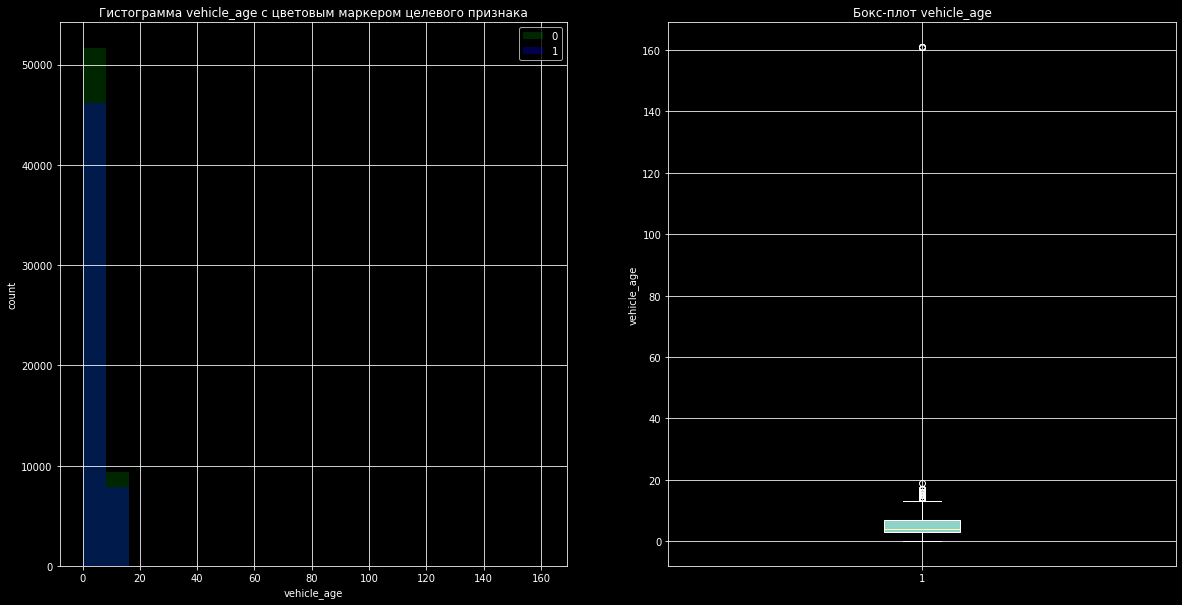

time_of_day
count    114925.000000
mean         13.509167
std           5.234006
min           0.000000
25%          10.000000
50%          14.000000
75%          17.000000
max          23.000000
Name: time_of_day, dtype: float64


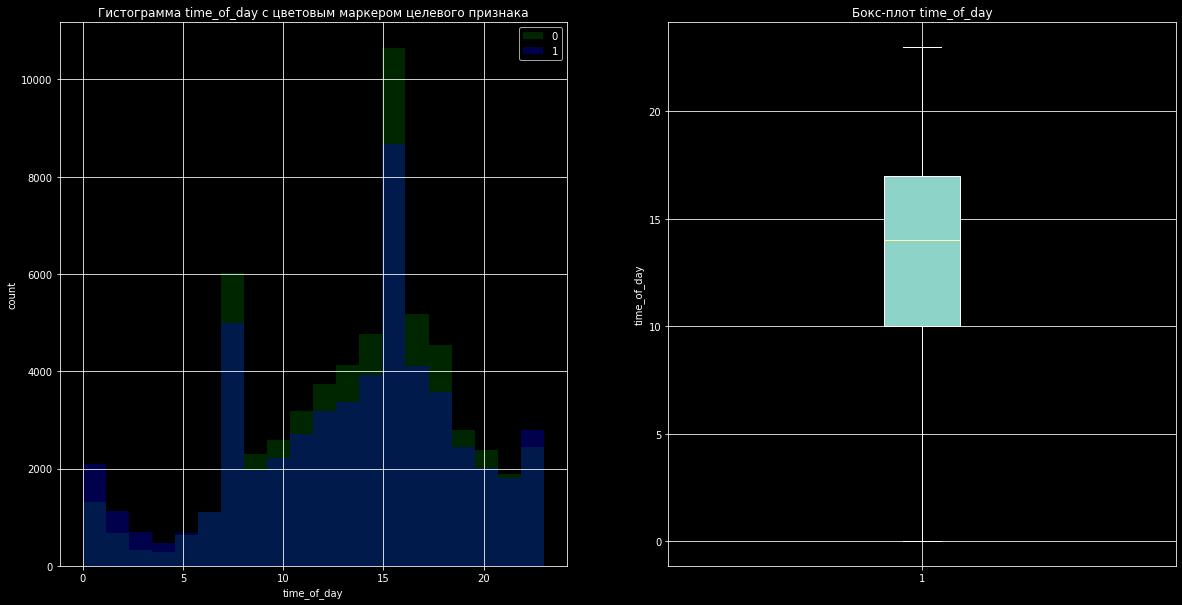

In [ ]:
for colum in num_col:
    print(colum)
    print(df_model[colum].describe())
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    for color, row in (['green', 0],
                        ['blue', 1]):
        x = df_model[df_model['at_fault'] == row][colum]
        ax[0].hist(x, bins=20, color=color, alpha=0.3, label=row)
    ax[0].set_xlabel(colum)
    ax[0].set_ylabel('count')
    ax[0].legend(loc="best")
    ax[0].set_title('Гистограмма ' + colum + ' с цветовым маркером целевого признака')
    ax[0].grid(True)

    if df_model[colum].isna().sum() != 0:
        ax[1].boxplot(df_model[colum].fillna(df_model[colum].mean()), patch_artist=True)

    else:
        ax[1].boxplot(df_model[colum], patch_artist=True)

    ax[1].set_ylabel(colum)
    ax[1].set_title('Бокс-плот ' + colum)
    ax[1].grid(True)
    plt.show()

Создадим признак на основании 'time_of_day' с конкретными категориями времени суток. Признак демонстрирует некую категоризацию, что отражается в его распределении

In [ ]:
df_model['time_of_day'] = df_model['time_of_day'].apply(lambda x: 'morning'
                                                                  if x in [6, 7, 8, 9, 10, 11] else 'daytime'
                                                                  if x in [12, 13, 14, 15, 16, 17] else 'evening'
                                                                  if x in [18, 19, 20, 21, 22, 23] else 'night')
num_col.remove('time_of_day')
cat_col.append('time_of_day')
df_model['time_of_day'].unique()

array(['night', 'evening', 'daytime', 'morning'], dtype=object)

In [ ]:
df_model[cat_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115046 entries, 0 to 115045
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   party_sobriety               113381 non-null  object
 1   cellphone_in_use             104767 non-null  object
 2   county_location              115046 non-null  object
 3   weather_1                    114664 non-null  object
 4   party_count                  115046 non-null  int64 
 5   type_of_collision            114441 non-null  object
 6   motor_vehicle_involved_with  114746 non-null  object
 7   road_surface                 114323 non-null  object
 8   road_condition_1             114501 non-null  object
 9   lighting                     114721 non-null  object
 10  day_of_week                  115046 non-null  object
 11  time_of_day                  115046 non-null  object
dtypes: int64(1), object(11)
memory usage: 10.5+ MB


## Кодирование и масштабирование

Зафиксируем 'случайность' в генераторах torch, numpy

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

Разделим данные на тренировочные, валидационные и тестовые. Выделим таргет из данных:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('at_fault', axis=1),
                                                    df_model['at_fault'],test_size=0.3,
                                                    shuffle=True, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, train_size=0.5, random_state=42, shuffle=True)

Обработаем пропуски кол-ых переменных KNNImputer

In [ ]:
knnimp = KNNImputer(n_neighbors=2, weights="uniform")
X_train[num_col] = knnimp.fit_transform(X_train[num_col])
X_valid[num_col] = knnimp.transform(X_valid[num_col])
X_test[num_col] = knnimp.transform(X_test[num_col])

Сохраняю 'сырые' данные, для того же Catboost лучше данные не обрабатывать Onehot и просто указать ему где категориальные столбцы</div>

In [ ]:
X_train_raw = X_train.copy()
X_valid_raw = X_valid.copy()
X_test_raw = X_test.copy()

Масштабирование и кодирование:

In [ ]:
encoder = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col])
X_valid_ohe = encoder.transform(X_valid[cat_col])
X_test_ohe = encoder.transform(X_test[cat_col])

encoder_col_names = encoder.get_feature_names()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col])
X_valid_scaled = scaler.transform(X_valid[num_col])
X_test_scaled = scaler.transform(X_test[num_col])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_valid_ohe = pd.DataFrame(X_valid_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=num_col)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_valid = pd.concat([X_valid_ohe, X_valid_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
X_train.head()

x0_had been drinking, not under influence  \
0                                        0.0   
1                                        0.0   
2                                        0.0   
3                                        0.0   
4                                        0.0   

   x0_had been drinking, under influence  x0_had not been drinking  \
0                                    0.0                       1.0   
1                                    0.0                       0.0   
2                                    0.0                       1.0   
3                                    0.0                       1.0   
4                                    1.0                       0.0   

   x0_impairment unknown  x0_not applicable  x0_None  x1_1  x1_nan  x2_alpine  \
0                    0.0                0.0      0.0   0.0     0.0        0.0   
1                    1.0                0.0      0.0   0.0     1.0        0.0   
2                    0.0                0.0      0.0   0.0     0.0        0.0   
3                    0.0                0.0      0.0   0.0     0.0        0.0   
4                    0.0                0.0      0.0   0.0     0.0        0.0   

   x2_amador  ...  x10_saturday   x10_sunday     x10_thursday   x10_tuesday    \
0        0.0  ...            1.0            0.0            0.0            0.0   
1        0.0  ...            1.0            0.0            0.0            0.0   
2        0.0  ...            0.0            0.0            0.0            0.0   
3        0.0  ...            0.0            0.0            1.0            0.0   
4        0.0  ...            0.0            0.0            0.0            0.0   

   x10_wednesday  x11_evening  x11_morning  x11_night  distance  vehicle_age  
0            0.0          0.0          1.0        0.0  0.005247     0.026040  
1            0.0          0.0          0.0        0.0 -0.079815    -0.593298  
2            0.0          0.0          0.0        0.0 -0.067664    -1.212637  
3            0.0          0.0          0.0        0.0 -0.067664     0.026040  
4            1.0          1.0          0.0        0.0 -0.091967    -0.593298  

[5 rows x 125 columns]

In [ ]:
X_train.shape

(80532, 125)

In [ ]:
X_valid.shape

(17257, 125)

In [ ]:
X_test.shape

(17257, 125)

## Моделирование

### RandomForest

В качества метрики исходя из поставленной бизнесом задачи - 'как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска', нам необходимо как повысить долю правильно выявленных виновников ДТП (точность) так и снизить долю опасных водителей которые алгоритм посчитает безопасными (полнота). Как баланс между Precision и Recall нам подойдет F1-мера

Для поббора гиперпараметров используем OptunaSearch

In [ ]:
param_grid = {
        'min_samples_leaf': distributions.IntDistribution(1, 20),
        'max_depth': distributions.IntDistribution(2, 300),
        'min_samples_split': distributions.IntDistribution(2, 20),
        'max_features': distributions.IntDistribution(2, 100),
        'n_estimators': distributions.IntDistribution(10, 101),
        'criterion': distributions.CategoricalDistribution(['gini', 'entropy', 'log_loss'])
        }

optuna_search_rf = OptunaSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    n_trials=15,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

optuna_search_rf.fit(pd.concat([X_train, X_valid], axis=0).reset_index(drop=True),
                     pd.concat([y_train, y_valid], axis=0).reset_index(drop=True))
print('Лучшая модель и её параметры:\n\n', optuna_search_rf.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', optuna_search_rf.best_score_)

[I 2024-08-23 12:58:25,224] A new study created in memory with name: no-name-32b5c887-e946-495a-9f79-61e1591b7100
[W 2024-08-23 12:58:29,384] Trial 3 failed with parameters: {'min_samples_leaf': 5, 'max_depth': 20, 'min_samples_split': 15, 'max_features': 13, 'n_estimators': 22, 'criterion': 'log_loss'} because of the following error: The value nan is not acceptable.
[W 2024-08-23 12:58:29,389] Trial 3 failed with value nan.
[W 2024-08-23 12:58:29,576] Trial 5 failed with parameters: {'min_samples_leaf': 10, 'max_depth': 218, 'min_samples_split': 16, 'max_features': 66, 'n_estimators': 46, 'criterion': 'log_loss'} because of the following error: The value nan is not acceptable.
[W 2024-08-23 12:58:29,581] Trial 5 failed with value nan.
[W 2024-08-23 12:58:29,869] Trial 7 failed with parameters: {'min_samples_leaf': 19, 'max_depth': 272, 'min_samples_split': 4, 'max_features': 34, 'n_estimators': 66, 'criterion': 'log_loss'} because of the following error: The value nan is not acceptabl

Лучшая модель и её параметры:

 RandomForestClassifier(max_depth=162, max_features=11, min_samples_leaf=8,
                       min_samples_split=4, n_estimators=70, random_state=42)
Метрика лучшей модели на кросс-валидации: 0.5101984547575108


### LGBM

Обучим алгоритм градиентного бустинга LightGBM, в качестве тренировочных данных возьмем не обработанный датасет (LightGBM лучше воспримет сырые категориальные признаки, нежели их обработает OneHotEncoder)

Явно указываем категории 'party_count', 'cellphone_in_use', меняем тип данных категориальных переменных на 'category'. Применяем StandardScaler на кол-ые признаки

In [ ]:
scaler = StandardScaler()
for df in [X_train_raw, X_valid_raw, X_test_raw]:

    df['party_count'] = df['party_count'].apply(lambda x: 'one' if x==1 else 'two'
                                                if x==2 else 'three' if x==3 else
                                                'four 'if x==4 else 'five' if x==5 else
                                                'six' if x==6 else 'seven' if x==7 else
                                                'eight'if x==8 else 'nine' if x==9 else
                                                'ten' if x==10 else x)
    df['cellphone_in_use'] = df['cellphone_in_use'].apply(lambda x: 'yes' if x==1 else 'no' if x==0 else x)
    df[cat_col] = df[cat_col].astype('category')

X_train_raw[num_col] = scaler.fit_transform(X_train_raw[num_col])
X_valid_raw[num_col] = scaler.transform(X_valid_raw[num_col])
X_test_raw[num_col] = scaler.transform(X_test_raw[num_col])

Алгоритм требует отсутствие nan значений в категориальных признаках, заполним эти пропуски 'заглушкой'

In [ ]:
X_train_raw.isna().mean()

party_sobriety                 0.014702
cellphone_in_use               0.088946
county_location                0.000000
distance                       0.000000
weather_1                      0.003253
party_count                    0.000000
type_of_collision              0.005215
motor_vehicle_involved_with    0.002558
road_surface                   0.006196
road_condition_1               0.004545
lighting                       0.002868
time_of_day                    0.000000
day_of_week                    0.000000
vehicle_age                    0.000000
dtype: float64

In [ ]:
for df in [X_train_raw, X_valid_raw, X_test_raw]:
    for column in cat_col:
        if df[column].isna().sum() != 0:
            df[column] = df[column].cat.add_categories('неизвестно')
            df[column] = df[column].fillna('неизвестно')
            df[column] = df[column].astype('category')

In [ ]:
X_train_lgm = pd.concat([X_train_raw, X_valid_raw], axis=0).reset_index(drop=True)
X_train_lgm['party_count'] = X_train_lgm['party_count'].astype('category')
y_train_lgm = pd.concat([y_train, y_valid], axis=0).reset_index(drop=True)
X_train_lgm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97789 entries, 0 to 97788
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   party_sobriety               97789 non-null  category
 1   cellphone_in_use             97789 non-null  category
 2   county_location              97789 non-null  category
 3   distance                     97789 non-null  float64 
 4   weather_1                    97789 non-null  category
 5   party_count                  97789 non-null  category
 6   type_of_collision            97789 non-null  category
 7   motor_vehicle_involved_with  97789 non-null  category
 8   road_surface                 97789 non-null  category
 9   road_condition_1             97789 non-null  category
 10  lighting                     97789 non-null  category
 11  time_of_day                  97789 non-null  category
 12  day_of_week                  97789 non-null  category
 13  v

In [ ]:
param_grid = {
        'learning_rate': distributions.FloatDistribution(0.01, 0.1),
        'n_estimators': distributions.IntDistribution(100, 1300),
        'max_depth': distributions.IntDistribution(2, 10),
        'num_leaves': distributions.IntDistribution(20, 100),
        'min_data_in_leaf': distributions.IntDistribution(50, 150),
        'lambda_l1': distributions.FloatDistribution(1e-4, 1e-3),
        'lambda_l2': distributions.FloatDistribution(1e-2, 1e-1)
        }

optuna_search_lgbm = OptunaSearchCV(
    LGBMClassifier(random_seed=42, iterations=500, categorical_feature=cat_col, verbose=-1),
    param_grid,
    cv=3,
    n_trials=15,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

optuna_search_lgbm.fit(X_train_lgm, y_train_lgm)
print('Лучшая модель и её параметры:\n\n', optuna_search_lgbm.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', optuna_search_lgbm.best_score_)

[I 2024-08-23 13:08:22,725] A new study created in memory with name: no-name-ee549cf1-6081-4756-bf71-2adc37c3b6b6


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00032927739107869146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032927739107869146
[LightGBM] [Warning] lambda_l2 is set=0.024687927761159453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024687927761159453
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00044680232405918546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044680232405918546
[LightGBM] [Warning] lambda_l2 is set=0.02612441862211612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02612441862211612
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00014

[I 2024-08-23 13:09:03,072] Trial 2 finished with value: 0.49713350256768224 and parameters: {'learning_rate': 0.025831702957751612, 'n_estimators': 127, 'max_depth': 3, 'num_leaves': 55, 'min_data_in_leaf': 85, 'lambda_l1': 0.00027805118822928624, 'lambda_l2': 0.0650896070324921}. Best is trial 2 with value: 0.49713350256768224.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00014565819526318117, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014565819526318117
[LightGBM] [Warning] lambda_l2 is set=0.04260825012012174, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04260825012012174
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00014447980458990822, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014447980458990822
[LightGBM] [Warning] lambda_l2 is set=0.08191381784849383, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08191381784849383
[LightGBM] [Warning] min_data_in_leaf is set=95, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=95
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.000145658

[I 2024-08-23 13:10:17,879] Trial 8 finished with value: 0.5091175287206385 and parameters: {'learning_rate': 0.07482662574348567, 'n_estimators': 248, 'max_depth': 3, 'num_leaves': 72, 'min_data_in_leaf': 50, 'lambda_l1': 0.00014565819526318117, 'lambda_l2': 0.04260825012012174}. Best is trial 8 with value: 0.5091175287206385.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00048403518704316477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048403518704316477
[LightGBM] [Warning] lambda_l2 is set=0.01959048438700835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01959048438700835
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54


[I 2024-08-23 13:10:48,071] Trial 1 finished with value: 0.5039731398878822 and parameters: {'learning_rate': 0.025968429150547895, 'n_estimators': 229, 'max_depth': 5, 'num_leaves': 92, 'min_data_in_leaf': 95, 'lambda_l1': 0.00014447980458990822, 'lambda_l2': 0.08191381784849383}. Best is trial 8 with value: 0.5091175287206385.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00033744102224056097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033744102224056097
[LightGBM] [Warning] lambda_l2 is set=0.04941351998213774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04941351998213774
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00032927739107869146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032927739107869146
[LightGBM] [Warning] lambda_l2 is set=0.024687927761159453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024687927761159453
[LightGBM] [Warning] min_data_in_leaf is set=130, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=130
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00042

[I 2024-08-23 13:13:58,169] Trial 4 finished with value: 0.5199544403005251 and parameters: {'learning_rate': 0.05302189854706731, 'n_estimators': 1146, 'max_depth': 3, 'num_leaves': 69, 'min_data_in_leaf': 51, 'lambda_l1': 0.00044680232405918546, 'lambda_l2': 0.02612441862211612}. Best is trial 4 with value: 0.5199544403005251.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0008103341479096484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008103341479096484
[LightGBM] [Warning] lambda_l2 is set=0.031992430040996805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031992430040996805
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52


[I 2024-08-23 13:14:25,568] Trial 10 finished with value: 0.5206272141259346 and parameters: {'learning_rate': 0.09167593266995953, 'n_estimators': 968, 'max_depth': 2, 'num_leaves': 32, 'min_data_in_leaf': 85, 'lambda_l1': 0.00033744102224056097, 'lambda_l2': 0.04941351998213774}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0005119329642070209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005119329642070209
[LightGBM] [Warning] lambda_l2 is set=0.018626822212073853, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018626822212073853
[LightGBM] [Warning] min_data_in_leaf is set=139, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=139
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0008103341479096484, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008103341479096484
[LightGBM] [Warning] lambda_l2 is set=0.031992430040996805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031992430040996805
[LightGBM] [Warning] min_data_in_leaf is set=52, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=52
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0005119

[I 2024-08-23 13:15:59,686] Trial 12 finished with value: 0.5060979760701113 and parameters: {'learning_rate': 0.06510393373970157, 'n_estimators': 483, 'max_depth': 2, 'num_leaves': 65, 'min_data_in_leaf': 139, 'lambda_l1': 0.0005119329642070209, 'lambda_l2': 0.018626822212073853}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0004804336862081319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004804336862081319
[LightGBM] [Warning] lambda_l2 is set=0.051444889366617404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.051444889366617404
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115


[I 2024-08-23 13:16:05,980] Trial 6 finished with value: 0.5151430345289855 and parameters: {'learning_rate': 0.041504744509809025, 'n_estimators': 362, 'max_depth': 9, 'num_leaves': 52, 'min_data_in_leaf': 130, 'lambda_l1': 0.00032927739107869146, 'lambda_l2': 0.024687927761159453}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0005151618176295182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005151618176295182
[LightGBM] [Warning] lambda_l2 is set=0.05995211292152655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05995211292152655
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74


[I 2024-08-23 13:16:12,972] Trial 3 finished with value: 0.5133505492119393 and parameters: {'learning_rate': 0.030043978002114786, 'n_estimators': 311, 'max_depth': 8, 'num_leaves': 78, 'min_data_in_leaf': 117, 'lambda_l1': 0.00042712136162899317, 'lambda_l2': 0.06728387534422002}. Best is trial 10 with value: 0.5206272141259346.
[I 2024-08-23 13:16:17,967] Trial 5 finished with value: 0.516563005522916 and parameters: {'learning_rate': 0.08450488464114674, 'n_estimators': 773, 'max_depth': 6, 'num_leaves': 21, 'min_data_in_leaf': 60, 'lambda_l1': 0.0004257860555368589, 'lambda_l2': 0.0316325063698933}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0004804336862081319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004804336862081319
[LightGBM] [Warning] lambda_l2 is set=0.051444889366617404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.051444889366617404
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0003668432455471924, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003668432455471924
[LightGBM] [Warning] lambda_l2 is set=0.03366103317991527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03366103317991527
[LightGBM] [Warning] min_data_in_leaf is set=101, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=101


[I 2024-08-23 13:16:42,079] Trial 11 finished with value: 0.5022942829190123 and parameters: {'learning_rate': 0.022114156423864818, 'n_estimators': 511, 'max_depth': 3, 'num_leaves': 91, 'min_data_in_leaf': 52, 'lambda_l1': 0.0008103341479096484, 'lambda_l2': 0.031992430040996805}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0004804336862081319, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004804336862081319
[LightGBM] [Warning] lambda_l2 is set=0.051444889366617404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.051444889366617404
[LightGBM] [Warning] min_data_in_leaf is set=115, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=115


[I 2024-08-23 13:17:07,781] Trial 13 finished with value: 0.5101573591618292 and parameters: {'learning_rate': 0.07618925919184162, 'n_estimators': 267, 'max_depth': 3, 'num_leaves': 92, 'min_data_in_leaf': 115, 'lambda_l1': 0.0004804336862081319, 'lambda_l2': 0.051444889366617404}. Best is trial 10 with value: 0.5206272141259346.
[I 2024-08-23 13:17:26,979] Trial 9 finished with value: 0.5165464733583978 and parameters: {'learning_rate': 0.09362130156480458, 'n_estimators': 487, 'max_depth': 6, 'num_leaves': 48, 'min_data_in_leaf': 54, 'lambda_l1': 0.00048403518704316477, 'lambda_l2': 0.01959048438700835}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0005151618176295182, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005151618176295182
[LightGBM] [Warning] lambda_l2 is set=0.05995211292152655, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05995211292152655
[LightGBM] [Warning] min_data_in_leaf is set=74, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=74
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0002249593942281357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002249593942281357
[LightGBM] [Warning] lambda_l2 is set=0.05565247902366261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05565247902366261
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0005151618176

[I 2024-08-23 13:18:56,568] Trial 0 finished with value: 0.5172940487671198 and parameters: {'learning_rate': 0.0326827807621217, 'n_estimators': 1005, 'max_depth': 6, 'num_leaves': 30, 'min_data_in_leaf': 101, 'lambda_l1': 0.0003668432455471924, 'lambda_l2': 0.03366103317991527}. Best is trial 10 with value: 0.5206272141259346.
[I 2024-08-23 13:19:09,775] Trial 14 finished with value: 0.5103257798828742 and parameters: {'learning_rate': 0.018887753294212238, 'n_estimators': 1215, 'max_depth': 3, 'num_leaves': 34, 'min_data_in_leaf': 74, 'lambda_l1': 0.0005151618176295182, 'lambda_l2': 0.05995211292152655}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.0002249593942281357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002249593942281357
[LightGBM] [Warning] lambda_l2 is set=0.05565247902366261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05565247902366261
[LightGBM] [Warning] min_data_in_leaf is set=53, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=53


[I 2024-08-23 13:21:49,078] Trial 7 finished with value: 0.5119560020349708 and parameters: {'learning_rate': 0.010765541005174855, 'n_estimators': 941, 'max_depth': 8, 'num_leaves': 94, 'min_data_in_leaf': 53, 'lambda_l1': 0.0002249593942281357, 'lambda_l2': 0.05565247902366261}. Best is trial 10 with value: 0.5206272141259346.


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] lambda_l1 is set=0.00033744102224056097, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00033744102224056097
[LightGBM] [Warning] lambda_l2 is set=0.04941351998213774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04941351998213774
[LightGBM] [Warning] min_data_in_leaf is set=85, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=85
Лучшая модель и её параметры:

 LGBMClassifier(categorical_feature=['party_sobriety', 'cellphone_in_use',
                                    'county_location', 'weather_1',
                                    'party_count', 'type_of_collision',
                                    'motor_vehicle_involved_with',
                                    'road_surface', 'road_condition_1',
                                    'lighting', 'day_of_week', 'time_of_day'],
               iterations=500, lambda_l1=0.00033744102224056097,
               lambda

### CatBoost

Обучим CatBoost

In [ ]:
X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80532 entries, 102296 to 15795
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   party_sobriety               80532 non-null  category
 1   cellphone_in_use             80532 non-null  category
 2   county_location              80532 non-null  category
 3   distance                     80532 non-null  float64 
 4   weather_1                    80532 non-null  category
 5   party_count                  80532 non-null  category
 6   type_of_collision            80532 non-null  category
 7   motor_vehicle_involved_with  80532 non-null  category
 8   road_surface                 80532 non-null  category
 9   road_condition_1             80532 non-null  category
 10  lighting                     80532 non-null  category
 11  time_of_day                  80532 non-null  category
 12  day_of_week                  80532 non-null  category
 

In [ ]:
# param_grid = {
#         'learning_rate': distributions.FloatDistribution(1e-2, 1e-1),
#         'n_estimators': distributions.IntDistribution(100, 1300),
#         'max_depth': distributions.IntDistribution(2, 10)
#         }

# optuna_search_cat = OptunaSearchCV(
#     CatBoostClassifier(random_state=42, cat_features=cat_col, use_best_model=True),
#     param_grid,
#     cv=3,
#     n_trials=15,
#     scoring='f1',
#     random_state=42,
#     n_jobs=-1
# )

# optuna_search_cat.fit(X_train_raw, y_train, verbose=False, eval_set=(X_valid_raw, y_valid))
# print('Лучшая модель и её параметры:\n\n', optuna_search_cat.best_estimator_.get_params())
# print ('Метрика лучшей модели на кросс-валидации:', optuna_search_cat.best_score_)

Лучшая модель и её параметры:

 {'use_best_model': True, 'random_state': 42, 'cat_features': ['party_sobriety', 'cellphone_in_use', 'county_location', 'weather_1', 'collision_damage', 'party_count', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'day_of_week', 'time_of_day'], 'learning_rate': 0.09624781689063823, 'n_estimators': 818, 'max_depth': 9}

Метрика лучшей модели на кросс-валидации: 0.538744841322227

### NeuralNet

Обучим алгоритм нейронной сети

Для работы с torch переведем данные в тензоры

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_valid = torch.FloatTensor(X_valid.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_valid = torch.FloatTensor(y_valid.values)
y_test = torch.FloatTensor(y_test.values)

Приведение истинных ответов к размеру соответствующему ответам предсказания, которые ожидает алгоритм оценки

In [ ]:
y_train = y_train.squeeze()
y_valid = y_valid.squeeze()
y_test = y_test.squeeze()

В качестве функции потерь возьмем бинарную кросс-энтропия(BCE)

In [ ]:
# loss = nn.BCEWithLogitsLoss()
loss = nn.BCELoss()

Добавим метод init_weights для инициализации слоёв. Будем инициализировать веса с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 2, а смещения — с помощью нормального распределения с математическим ожиданием 0.5 и среднеквадратичным отклонением 1

In [ ]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, 0.5, 2)
        nn.init.normal_(layer.bias, -0.5, 1)

Входные, выходные нейроны сети

In [ ]:
n_in_neurons = X_train.shape[1]
n_out_neurons = 1

Тестовый вариант структуры сети, в качестве алгоритма оптимизации выберем Adam

In [ ]:
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 50

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.Tanh(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
    nn.Sigmoid()
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

F1 = F1Score(task='binary', num_classes=2)
roc_auc = AUROC(task='binary')

num_epochs = 100

Сверять метрику качества сети будем каждые 10 итераций

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            preds_valid = net.forward(X_valid).flatten()
            preds_valid_class = (preds_valid > 0.5).int()  # преобразование предсказаний в классы
            print(F1(preds_valid_class, y_valid))
        net.train()

tensor(0.0324)
tensor(0.1587)
tensor(0.4210)
tensor(0.4965)
tensor(0.5241)
tensor(0.5233)
tensor(0.5097)
tensor(0.5053)
tensor(0.5070)
tensor(0.5050)
tensor(0.5057)


Зададим параметры для перебора в построении сети, таковыми являются: скорость обучения, размер батча (обучение будем производить по батчам), дропаут части нейронов сети, фунция активации

In [ ]:
lr = [1e-3, 1e-2, 5e-2, 1e-1]
batch_sizes = [5000, 15000, 30000]
p_drop = [0, 0.2, 0.5]
af = [nn.Tanh(), nn.ReLU()]
n_iter = 15
num_epochs = 50

Добавим коэффициенты регуляризации Elastic Net


In [ ]:
l1 = [1e-3, 1e-2, 0]
l2 = [1e-3, 1e-2, 0]

#### 2 скрытых слоя

In [ ]:
h = list(range(300,1001, 50))

Так же к структуре сети добавлен метод регуляризации BatchNorm

В качестве индикатора адекватности лучшей версии алгоритма добавил оценку roc-auc меры. При roc-auc = 0.5, что говорит о константном предсказании ответов на валидации, оценка при этом f1 ~= 0.65 что дает оценку выше чем когда модель пытается находить патерн правильной оценки целевого признака

In [ ]:
# best_result = []
# n_hidden_neurons_1_result = []
# n_hidden_neurons_2_result = []
# epoch_result = []
# af1_result = []
# af2_result = []
# lr_result = []
# bs_result = []
# p_drop_1_result = []
# p_drop_2_result = []
# l1_result = []
# l2_result = []
# roc_auc_result = []
# for i in range(n_iter):

#     n_hidden_neurons_1 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_2 = h[np.random.randint(0, len(h))]
#     af1 = af[np.random.randint(0, len(af))]
#     af2 = af[np.random.randint(0, len(af))]
#     lr_net = lr[np.random.randint(0, len(lr))]
#     batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
#     drop_1 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_2 = p_drop[np.random.randint(0, len(p_drop))]
#     l_reg_1 = l1[np.random.randint(0, len(l1))]
#     l_reg_2 = l2[np.random.randint(0, len(l2))]

#     data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

#     net = nn.Sequential(
#     nn.Linear(n_in_neurons, n_hidden_neurons_1),
#     nn.BatchNorm1d(n_hidden_neurons_1),
#     af1,
#     nn.Dropout(p=drop_1),
#     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
#     nn.BatchNorm1d(n_hidden_neurons_2),
#     af2,
#     nn.Dropout(p=drop_2),
#     nn.Linear(n_hidden_neurons_2, n_out_neurons),
#     nn.Sigmoid()
#     )
#     net.apply(init_weights)

#     optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

#     for epoch in range(num_epochs):
#         optimizer.zero_grad()

#         for X_batch, y_batch in data_loader:
#             preds = net.forward(X_batch).flatten()
#             loss_value = loss(preds, y_batch)

#             l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
#             l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

#             total_loss = loss_value + l1_reg + l2_reg
#             total_loss.backward()
#             optimizer.step()

#         if epoch % 10 == 0 or epoch == num_epochs - 1:
#             net.eval()
#             with torch.no_grad():
#                 preds_valid_prob = net.forward(X_valid).flatten()
#                 roc_auc_ = roc_auc(preds_valid_prob, y_valid)
#                 preds_valid_class = (preds_valid_prob > 0.5).int()
#                 true_class = (y_valid > 0.5).int()
#                 f1_sklearn = f1_score(true_class.numpy(), preds_valid_class.numpy())
#                 result = F1(preds_valid_class, true_class)
#             net.train()


#             print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2},  номер эпохи: {epoch}, F1: {result}')
#             print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2},  скорость обучения: {lr_net}, roc_auc: {roc_auc_}')
#             print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}, F1 sklearn: {f1_sklearn}')
#             print(f'регуляризация l1: {l_reg_1}, регуляризация l2: {l_reg_2}')
#             print()

#             best_result.append(result)
#             n_hidden_neurons_1_result.append(n_hidden_neurons_1)
#             n_hidden_neurons_2_result.append(n_hidden_neurons_2)
#             epoch_result.append(epoch)
#             af1_result.append(af1)
#             af2_result.append(af2)
#             lr_result.append(lr_net)
#             bs_result.append(batch_size)
#             p_drop_1_result.append(drop_1)
#             p_drop_2_result.append(drop_2)
#             l1_result.append(l_reg_1)
#             l2_result.append(l_reg_2)
#             roc_auc_result.append(roc_auc_)

In [ ]:
# _best_result_ = best_result.copy()

В качестве фильтра константных моделей или моделей близких к константной оценке, установил отсечку по roc-auc > 0.7

In [ ]:
# for i in range(len(roc_auc_result)):
#     if roc_auc_result[i] < 0.7:
#         best_result[i] = 0
# print(f"лучший результат обучения, F1: {max(best_result)}")

Сохраним результат подбора модели:

In [ ]:
# best_result_ = max(best_result)
# best_id = best_result.index(best_result_)
# best_id

In [ ]:
# best_model_2_hidden = []
# best_model_2_hidden.append(f"F1: {max(best_result)}")
# best_model_2_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
# best_model_2_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
# best_model_2_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
# best_model_2_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
# best_model_2_hidden.append(f"learning rate: {lr_result[best_id]}")
# best_model_2_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
# best_model_2_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
# best_model_2_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
# best_model_2_hidden.append(f"размер батча: {bs_result[best_id]}")
# best_model_2_hidden.append(f"регуляризация l1: {l1_result[best_id]}")
# best_model_2_hidden.append(f"регуляризация l2: {l2_result[best_id]}")
# best_model_2_hidden.append(f"roc-auc: {roc_auc_result[best_id]}")

# print('лучшие параметры сети с 2-мя скр. слоями:')
# best_model_2_hidden

лучшие параметры сети с 2-мя скр. слоями:

['F1: 0.6369668245315552',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 800',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 49',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 30000',
 'регуляризация l1: 0',
 'регуляризация l2: 0.01',
 'roc-auc: 0.7009150385856628']

#### 3 скрытых слоя

In [ ]:
h = list(range(100, 501, 50))

In [ ]:
# best_result = []
# n_hidden_neurons_1_result = []
# n_hidden_neurons_2_result = []
# n_hidden_neurons_3_result = []
# epoch_result = []
# af1_result = []
# af2_result = []
# af3_result = []
# lr_result = []
# bs_result = []
# p_drop_1_result = []
# p_drop_2_result = []
# p_drop_3_result = []
# l1_result = []
# l2_result = []
# roc_auc_result = []

# for i in range(n_iter):

#     n_hidden_neurons_1 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_2 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_3 = h[np.random.randint(0, len(h))]
#     af1 = af[np.random.randint(0, len(af))]
#     af2 = af[np.random.randint(0, len(af))]
#     af3 = af[np.random.randint(0, len(af))]
#     lr_net = lr[np.random.randint(0, len(lr))]
#     batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
#     drop_1 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_2 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_3 = p_drop[np.random.randint(0, len(p_drop))]
#     l_reg_1 = l1[np.random.randint(0, len(l1))]
#     l_reg_2 = l2[np.random.randint(0, len(l2))]

#     data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

#     net = nn.Sequential(
#     nn.Linear(n_in_neurons, n_hidden_neurons_1),
#     nn.BatchNorm1d(n_hidden_neurons_1),
#     af1,
#     nn.Dropout(p=drop_1),
#     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
#     nn.BatchNorm1d(n_hidden_neurons_2),
#     af2,
#     nn.Dropout(p=drop_2),
#     nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
#     nn.BatchNorm1d(n_hidden_neurons_3),
#     af3,
#     nn.Dropout(p=drop_3),
#     nn.Linear(n_hidden_neurons_3, n_out_neurons),
#     nn.Sigmoid()
#     )
#     net.apply(init_weights)

#     optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

#     for epoch in range(num_epochs):
#         optimizer.zero_grad()

#         for X_batch, y_batch in data_loader:
#             preds = net.forward(X_batch).flatten()
#             loss_value = loss(preds, y_batch)

#             l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
#             l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

#             total_loss = loss_value + l1_reg + l2_reg
#             total_loss.backward()
#             optimizer.step()

#         if epoch % 10 == 0 or epoch == num_epochs - 1:
#             net.eval()
#             with torch.no_grad():
#                 preds_valid_prob = net.forward(X_valid).flatten()
#                 roc_auc_ = roc_auc(preds_valid_prob, y_valid)
#                 preds_valid_class = (preds_valid_prob > 0.5).int()
#                 true_class = (y_valid > 0.5).int()
#                 result = F1(preds_valid_class, true_class)
#             net.train()

#             print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2}, кол-во нейронов в 3-ем слое: {n_hidden_neurons_3},  номер эпохи: {epoch}, F1: {result}')
#             print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2}, функция активации 3-го слоя: {af3},  скорость обучения: {lr_net}, roc_auc: {roc_auc_}')
#             print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2},  dropout 3-го слоя: {drop_3}')
#             print(f'регуляризация l1: {l_reg_1}, регуляризация l2: {l_reg_2}')
#             print()

#             best_result.append(result)
#             n_hidden_neurons_1_result.append(n_hidden_neurons_1)
#             n_hidden_neurons_2_result.append(n_hidden_neurons_2)
#             n_hidden_neurons_3_result.append(n_hidden_neurons_3)
#             epoch_result.append(epoch)
#             af1_result.append(af1)
#             af2_result.append(af2)
#             af3_result.append(af3)
#             lr_result.append(lr_net)
#             bs_result.append(batch_size)
#             p_drop_1_result.append(drop_1)
#             p_drop_2_result.append(drop_2)
#             p_drop_3_result.append(drop_3)
#             l1_result.append(l_reg_1)
#             l2_result.append(l_reg_2)
#             roc_auc_result.append(roc_auc_)

In [ ]:
# _best_result_3 = best_result.copy()

In [ ]:
# for i in range(len(roc_auc_result)):
#     if roc_auc_result[i] < 0.7:
#         best_result[i] = 0
# print(f"лучший результат обучения, F1: {max(best_result)}")

In [ ]:
# best_result_ = max(best_result)
# best_id = best_result.index(best_result_)
# best_id

In [ ]:
# best_model_3_hidden = []
# best_model_3_hidden.append(f"F1: {max(best_result)}")
# best_model_3_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
# best_model_3_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
# best_model_3_hidden.append(f"Нейроны 3 слой: {n_hidden_neurons_3_result[best_id]}")
# best_model_3_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
# best_model_3_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
# best_model_3_hidden.append(f"Функ. акт. 3 слоя: {af3_result[best_id]}")
# best_model_3_hidden.append(f"learning rate: {lr_result[best_id]}")
# best_model_3_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
# best_model_3_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
# best_model_3_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
# best_model_3_hidden.append(f"dropout 3 слоя: {p_drop_3_result[best_id]}")
# best_model_3_hidden.append(f"размер батча: {bs_result[best_id]}")
# best_model_3_hidden.append(f"регуляризация l1: {l1_result[best_id]}")
# best_model_3_hidden.append(f"регуляризация l2: {l2_result[best_id]}")
# best_model_3_hidden.append(f"roc-auc: {roc_auc_result[best_id]}")

# print('лучшие параметры сети с 3-мя скр. слоями:')
# best_model_3_hidden

лучшие параметры сети с 3-мя скр. слоями:

['F1: 0.6543166041374207',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 100',
 'Нейроны 3 слой: 400',
 'Функ. акт. 1 слоя: ReLU()',
 'Функ. акт. 2 слоя: Tanh()',
 'Функ. акт. 3 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 40',
 'dropout 1 слоя: 0.5',
 'dropout 2 слоя: 0.5',
 'dropout 3 слоя: 0.2',
 'размер батча: 5000',
 'регуляризация l1: 0',
 'регуляризация l2: 0.001',
 'roc-auc: 0.705475926399231']

#### 5 скрытых слоев

In [ ]:
h = list(range(100,301, 50))

In [ ]:
# best_result = []
# n_hidden_neurons_1_result = []
# n_hidden_neurons_2_result = []
# n_hidden_neurons_3_result = []
# n_hidden_neurons_4_result = []
# n_hidden_neurons_5_result = []
# epoch_result = []
# af1_result = []
# af2_result = []
# af3_result = []
# af4_result = []
# af5_result = []
# lr_result = []
# bs_result = []
# p_drop_1_result = []
# p_drop_2_result = []
# p_drop_3_result = []
# p_drop_4_result = []
# p_drop_5_result = []
# l1_result = []
# l2_result = []
# roc_auc_result = []

# for i in range(n_iter):

#     n_hidden_neurons_1 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_2 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_3 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_4 = h[np.random.randint(0, len(h))]
#     n_hidden_neurons_5 = h[np.random.randint(0, len(h))]
#     af1 = af[np.random.randint(0, len(af))]
#     af2 = af[np.random.randint(0, len(af))]
#     af3 = af[np.random.randint(0, len(af))]
#     af4 = af[np.random.randint(0, len(af))]
#     af5 = af[np.random.randint(0, len(af))]
#     lr_net = lr[np.random.randint(0, len(lr))]
#     batch_size = batch_sizes[np.random.randint(0, len(batch_sizes))]
#     drop_1 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_2 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_3 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_4 = p_drop[np.random.randint(0, len(p_drop))]
#     drop_5 = p_drop[np.random.randint(0, len(p_drop))]
#     l_reg_1 = l1[np.random.randint(0, len(l1))]
#     l_reg_2 = l2[np.random.randint(0, len(l2))]

#     data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

#     net = nn.Sequential(
#     nn.Linear(n_in_neurons, n_hidden_neurons_1),
#     nn.BatchNorm1d(n_hidden_neurons_1),
#     af1,
#     nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
#     nn.BatchNorm1d(n_hidden_neurons_2),
#     af2,
#     nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
#     nn.BatchNorm1d(n_hidden_neurons_3),
#     af3,
#     nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4),
#     nn.BatchNorm1d(n_hidden_neurons_4),
#     af4,
#     nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5),
#     nn.BatchNorm1d(n_hidden_neurons_5),
#     af5,
#     nn.Linear(n_hidden_neurons_5, n_out_neurons),
#     nn.Sigmoid()
#     )
#     net.apply(init_weights)

#     optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

#     for epoch in range(num_epochs):
#         optimizer.zero_grad()

#         for X_batch, y_batch in data_loader:
#             preds = net.forward(X_batch).flatten()
#             loss_value = loss(preds, y_batch)

#             l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
#             l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

#             total_loss = loss_value + l1_reg + l2_reg
#             total_loss.backward()
#             optimizer.step()

#         if epoch % 10 == 0 or epoch == num_epochs - 1:
#             net.eval()
#             with torch.no_grad():
#                 preds_valid_prob = net.forward(X_valid).flatten()
#                 roc_auc_ = roc_auc(preds_valid_prob, y_valid)
#                 preds_valid_class = (preds_valid_prob > 0.5).int()
#                 true_class = (y_valid > 0.5).int()
#                 result = F1(preds_valid_class, true_class)
#             net.train()

#             print(f'кол-во нейронов в 1-ом слое: {n_hidden_neurons_1}, кол-во нейронов в 2-ом слое: {n_hidden_neurons_2}, кол-во нейронов в 3-ем слое: {n_hidden_neurons_3}')
#             print(f'кол-во нейронов в 4-ом слое: {n_hidden_neurons_4}, кол-во нейронов в 5-ом слое: {n_hidden_neurons_5}, номер эпохи: {epoch}, F1: {result}')
#             print(f'функция активации 1-го слоя: {af1}, функция активации 2-го слоя: {af2}, функция активации 3-го слоя: {af3}')
#             print(f'функция активации 4-го слоя: {af4}, функция активации 5 -го слоя: {af5},  скорость обучения: {lr_net}, roc_auc: {roc_auc_}')
#             print(f'размер батча: {batch_size}, dropout 1-го слоя: {drop_1}, dropout 2-го слоя: {drop_2}, dropout 3-го слоя: {drop_3}, dropout 4-го слоя: {drop_4}, dropout 5-го слоя: {drop_5}')
#             print(f'регуляризация l1: {l_reg_1}, регуляризация l2: {l_reg_2}')
#             print()
#             best_result.append(result)
#             n_hidden_neurons_1_result.append(n_hidden_neurons_1)
#             n_hidden_neurons_2_result.append(n_hidden_neurons_2)
#             n_hidden_neurons_3_result.append(n_hidden_neurons_3)
#             n_hidden_neurons_4_result.append(n_hidden_neurons_4)
#             n_hidden_neurons_5_result.append(n_hidden_neurons_5)
#             epoch_result.append(epoch)
#             af1_result.append(af1)
#             af2_result.append(af2)
#             af3_result.append(af3)
#             af4_result.append(af4)
#             af5_result.append(af5)
#             lr_result.append(lr_net)
#             bs_result.append(batch_size)
#             p_drop_1_result.append(drop_1)
#             p_drop_2_result.append(drop_2)
#             p_drop_3_result.append(drop_3)
#             p_drop_4_result.append(drop_4)
#             p_drop_5_result.append(drop_5)
#             l1_result.append(l_reg_1)
#             l2_result.append(l_reg_2)
#             roc_auc_result.append(roc_auc_)

In [ ]:
# _best_result_5 = best_result.copy()

In [ ]:
# for i in range(len(roc_auc_result)):
#     if roc_auc_result[i] < 0.7:
#         best_result[i] = 0
# print(f"лучший результат обучения, F1: {max(best_result)}")

In [ ]:
# best_result_ = max(best_result)
# best_id = best_result.index(best_result_)
# best_id

In [ ]:
# best_model_5_hidden = []
# best_model_5_hidden.append(f"F1: {max(best_result)}")
# best_model_5_hidden.append(f"Нейроны 1 слой: {n_hidden_neurons_1_result[best_id]}")
# best_model_5_hidden.append(f"Нейроны 2 слой: {n_hidden_neurons_2_result[best_id]}")
# best_model_5_hidden.append(f"Нейроны 3 слой: {n_hidden_neurons_3_result[best_id]}")
# best_model_5_hidden.append(f"Нейроны 4 слой: {n_hidden_neurons_4_result[best_id]}")
# best_model_5_hidden.append(f"Нейроны 5 слой: {n_hidden_neurons_5_result[best_id]}")
# best_model_5_hidden.append(f"Функ. акт. 1 слоя: {af1_result[best_id]}")
# best_model_5_hidden.append(f"Функ. акт. 2 слоя: {af2_result[best_id]}")
# best_model_5_hidden.append(f"Функ. акт. 3 слоя: {af3_result[best_id]}")
# best_model_5_hidden.append(f"Функ. акт. 4 слоя: {af4_result[best_id]}")
# best_model_5_hidden.append(f"Функ. акт. 5 слоя: {af5_result[best_id]}")
# best_model_5_hidden.append(f"learning rate: {lr_result[best_id]}")
# best_model_5_hidden.append(f"Номер эпохи: {epoch_result[best_id]}")
# best_model_5_hidden.append(f"dropout 1 слоя: {p_drop_1_result[best_id]}")
# best_model_5_hidden.append(f"dropout 2 слоя: {p_drop_2_result[best_id]}")
# best_model_5_hidden.append(f"dropout 3 слоя: {p_drop_3_result[best_id]}")
# best_model_5_hidden.append(f"dropout 4 слоя: {p_drop_4_result[best_id]}")
# best_model_5_hidden.append(f"dropout 5 слоя: {p_drop_5_result[best_id]}")
# best_model_5_hidden.append(f"размер батча: {bs_result[best_id]}")
# best_model_5_hidden.append(f"регуляризация l1: {l1_result[best_id]}")
# best_model_5_hidden.append(f"регуляризация l2: {l2_result[best_id]}")
# best_model_5_hidden.append(f"roc-auc: {roc_auc_result[best_id]}")

# print('лучшие параметры сети с 5-ю скр. слоями:')
# best_model_5_hidden

лучшие параметры сети с 5-ю скр. слоями:

['F1: 0.6316091418266296',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 300',
 'Нейроны 3 слой: 150',
 'Нейроны 4 слой: 200',
 'Нейроны 5 слой: 200',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: ReLU()',
 'Функ. акт. 3 слоя: ReLU()',
 'Функ. акт. 4 слоя: ReLU()',
 'Функ. акт. 5 слоя: ReLU()',
 'learning rate: 0.01',
 'Номер эпохи: 49',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'dropout 3 слоя: 0.2',
 'dropout 4 слоя: 0.5',
 'dropout 5 слоя: 0.5',
 'размер батча: 15000',
 'регуляризация l1: 0',
 'регуляризация l2: 0',
 'roc-auc: 0.7047802209854126']

## Результаты моделирования

Зафиксируем результаты всех экспериментов в таблицу:

In [ ]:
data = [["RandomForest", 0.523],
        ["LGBM", 0.526],
        ["CatBoost", 0.538],
        ["NeuralNet 2 hidden", 0.636],
        ["NeuralNet 3 hidden", 0.631],
        ["NeuralNet 5 hidden", 0.631],]
column = ["Модель", "F1 на валидации"]
data = pd.DataFrame(data, columns=column)

data

Модель  F1 на валидации
0        RandomForest            0.523
1                LGBM            0.526
2            CatBoost            0.538
3  NeuralNet 2 hidden            0.636
4  NeuralNet 3 hidden            0.631
5  NeuralNet 5 hidden            0.631

Лучшей себя показал алгоритм нейронной сети с 2 скрытыми слоями

лучшие параметры сети с 2-мя скр. слоями:

['F1: 0.6369668245315552',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 800',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 49',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 30000',
 'регуляризация l1: 0',
 'регуляризация l2: 0.01',
 'roc-auc: 0.7009150385856628']

Перед получением результата моделирования попробуем увеличить кол-во эпох обучения до 200

In [ ]:
n_hidden_neurons_1 = 300
n_hidden_neurons_2 = 800
af1 = nn.Tanh()
af2 = nn.Tanh()
lr_net = 0.01
batch_size = 30000
drop_1 = 0.2
drop_2 = 0.2
l_reg_1 = 0
l_reg_2 = 0.01
num_epochs = 200

data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

net = nn.Sequential(
nn.Linear(n_in_neurons, n_hidden_neurons_1),
nn.BatchNorm1d(n_hidden_neurons_1),
af1,
nn.Dropout(p=drop_1),
nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
nn.BatchNorm1d(n_hidden_neurons_2),
af2,
nn.Dropout(p=drop_2),
nn.Linear(n_hidden_neurons_2, n_out_neurons),
nn.Sigmoid()
)
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=lr_net)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    for X_batch, y_batch in data_loader:
        preds = net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)

        l1_reg = l_reg_1 * sum(param.abs().sum() for param in net.parameters())
        l2_reg = l_reg_2 * sum(param.pow(2).sum() for param in net.parameters())

        total_loss = loss_value + l1_reg + l2_reg
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        with torch.no_grad():
            preds_valid_prob = net.forward(X_valid).flatten()
            roc_auc_ = roc_auc(preds_valid_prob, y_valid)
            preds_valid_class = (preds_valid_prob > 0.5).int()
            true_class = (y_valid > 0.5).int()
            result = F1(preds_valid_class, true_class)
        net.train()

        print(f'номер эпохи: {epoch}, F1: {result}')
        print(f'roc_auc: {roc_auc_}')
        print()

номер эпохи: 0, F1: 0.6412345767021179
roc_auc: 0.49993860721588135

номер эпохи: 10, F1: 0.6357589364051819
roc_auc: 0.5008677840232849

номер эпохи: 20, F1: 0.633871853351593
roc_auc: 0.49802422523498535

номер эпохи: 30, F1: 0.44758427143096924
roc_auc: 0.5424714088439941

номер эпохи: 40, F1: 0.5937692523002625
roc_auc: 0.6321314573287964

номер эпохи: 50, F1: 0.6147170662879944
roc_auc: 0.6911522150039673

номер эпохи: 60, F1: 0.6412881016731262
roc_auc: 0.6966373920440674

номер эпохи: 70, F1: 0.6124873757362366
roc_auc: 0.6926683187484741

номер эпохи: 80, F1: 0.1996482014656067
roc_auc: 0.6962410807609558

номер эпохи: 90, F1: 0.4857069253921509
roc_auc: 0.6787550449371338

номер эпохи: 100, F1: 0.6415258049964905
roc_auc: 0.6912040114402771

номер эпохи: 110, F1: 0.4896315336227417
roc_auc: 0.6951423287391663

номер эпохи: 120, F1: 0.49555423855781555
roc_auc: 0.6917843222618103

номер эпохи: 130, F1: 0.6427024602890015
roc_auc: 0.6989025473594666

номер эпохи: 140, F1: 0.5069

In [ ]:
net.eval()
with torch.no_grad():
    preds_test_prob = net.forward(X_test).flatten()
    roc_auc_ = roc_auc(preds_test_prob, y_test)
    preds_test_class = (preds_test_prob > 0.5).int()
    true_class = (y_test > 0.5).int()
    result = F1(preds_test_class, true_class)
print(f'F1 на тесте: {result}')
print(f'roc_auc на тесте: {roc_auc_}')

F1 на тесте: 0.5040881037712097
roc_auc на тесте: 0.6892789602279663


Проведем графический анализ «Матрицы ошибок»:

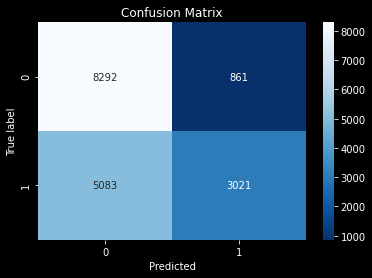

In [ ]:
cm = confusion_matrix(y_test.numpy(), preds_test_class.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Наблюдаем преобладание ошибки 1 рода что свидетельствует о том что модель склонна опасным водителям присваивать тег 'безопасный'. Рекомендую чуть сдвинуть порог классификации

Несколько вариантов подбора оптимального threshold:

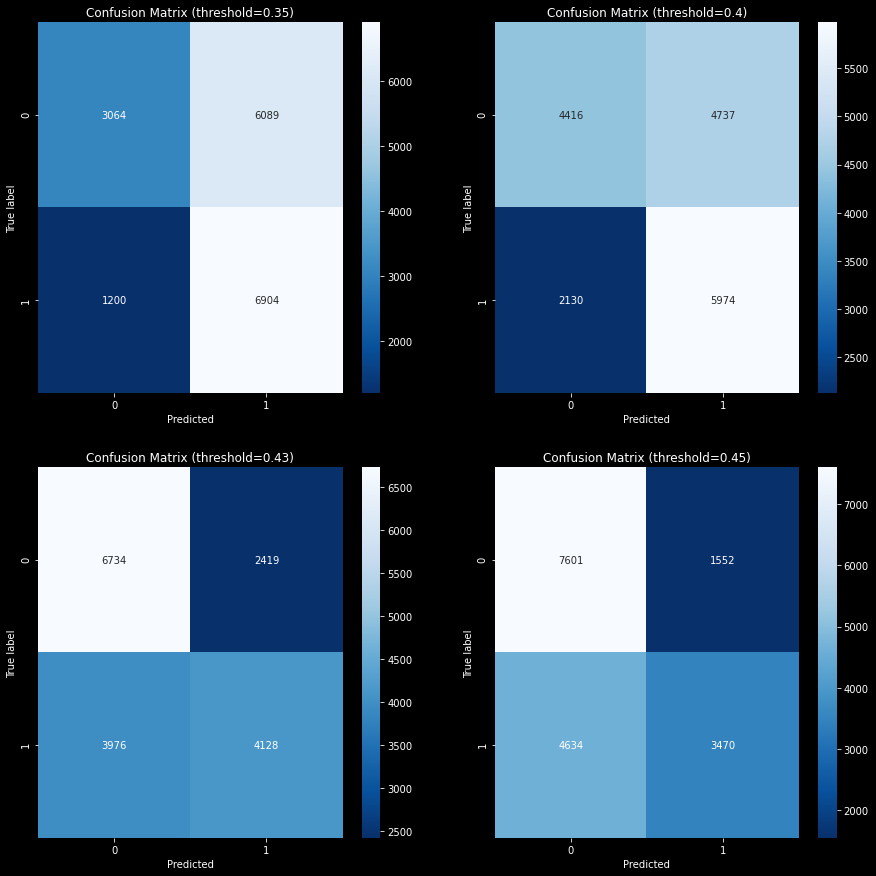

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
thresholds = [0.35, 0.4, 0.43, 0.45]
for i, threshold in enumerate(thresholds):
    preds_test_class = (preds_test_prob > threshold).int()
    cm = confusion_matrix(y_test.numpy(), preds_test_class.numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', ax=ax[i//2, i%2])
    ax[i//2, i%2].set_ylabel('True label')
    ax[i//2, i%2].set_xlabel('Predicted')
    ax[i//2, i%2].set_title(f'Confusion Matrix (threshold={threshold})')
plt.show()

ROC-кривая:

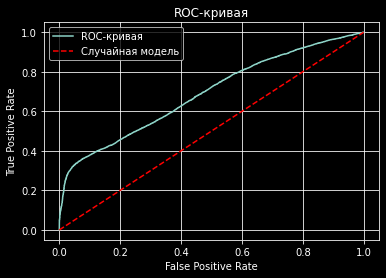

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.numpy(), preds_test_prob.numpy())

plt.plot(fpr, tpr, label='ROC-кривая')
plt.plot([0, 1], [0, 1], 'r--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.grid(True)
plt.legend()
plt.show()

График полноты и точности:

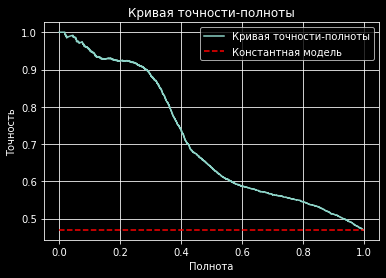

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test.numpy(), preds_test_prob.numpy())

plt.plot(recall, precision, label='Кривая точности-полноты')
plt.plot([0, 1], [y_test.numpy().mean(), y_test.numpy().mean()], 'r--', label='Константная модель')
plt.xlabel('Полнота')
plt.ylabel('Точность')
plt.title('Кривая точности-полноты')
plt.grid(True)
plt.legend()
plt.show()

### Анализ факторов влияющих на вероятность ДТП

In [ ]:
# X_test_sample = shap.sample(X_test, 100)
# # shap_values = explainer.shap_values(X_test_sample)
# explainer = shap.DeepExplainer(net, X_train)
# shap.plots.force(explainer.expected_value, shap_values, X_train)

{'use_best_model': True, 'random_state': 42, 'cat_features': ['party_sobriety', 'cellphone_in_use', 'county_location', 'weather_1', 'collision_damage', 'party_count', 'type_of_collision', 'motor_vehicle_involved_with', 'road_surface', 'road_condition_1', 'lighting', 'day_of_week', 'time_of_day'], 'learning_rate': 0.09624781689063823, 'n_estimators': 818, 'max_depth': 9}

In [ ]:
cat_model = CatBoostClassifier(random_state=42, learning_rate=0.09624, n_estimators=818,
                               max_depth=9, cat_features=cat_col, use_best_model=True)

cat_model.fit(X_train_raw, y_train.numpy(), verbose=False, eval_set=(X_valid_raw, y_valid.numpy()))

In [ ]:
y_pred = cat_model.predict(X_test_raw)
y_pred_proba = cat_model.predict_proba(X_test_raw)

roc_auc = roc_auc_score(y_test.numpy(), y_pred_proba[:, 1])
f1 = f1_score(y_test.numpy(), y_pred)

print(f"ROC-AUC на тесте: {roc_auc}")
print(f"F1 на тесте: {f1}")

ROC-AUC на тесте: 0.7458874317581696
F1 на тесте: 0.5645468998410175


График вклада каждого признака в предсказания модели:

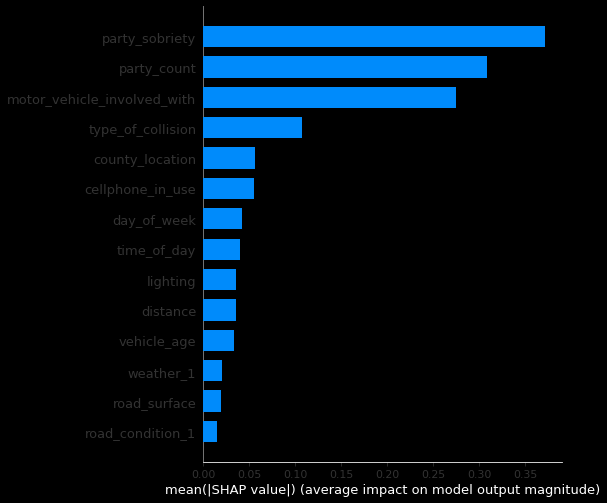

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test_raw)
shap.summary_plot(shap_values, X_test_raw, plot_type="bar")
plt.show()

Наблюдаем топ значимости признаков для нашей модели по Шепли, по убыванию значимость признаков: party_sobriety(трезвость участника ДТП), motor_vehicle_involved_with(дополнительные участники ДТП), party_count(число участников ДТП) и тд

- Из условия проектной задачи 'Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety: Предложить оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место', экспериментально подтвердили теорию и поддерживаю инициативу

- motor_vehicle_involved_with дополнительные участники ДТП. Меры по уменьшению ДТП на основании данного признака: улучшение инфраструктуры(установка защитных сооружений вдоль дорог для предотвращения столкновения с животными, создание велосипедных дорожек вдоль дороги), повышение осведомлённости водителей об участках дорог где выше вероятность столкновения с велосепедистами (самокатчиками, роллерами и тд), оборудовать машины системами ИИ для предотвращения столкновений

- party_count число участников ДТП. Статистически чем больше участников ДТП тем ниже вероятность виновности конкретного его участника

## Общий вывод

В проделанной работе есть промежуточные выводы, в общем выводе я бы хотел обобщить их и подвести итог по работе с данными:

<h4>Загрузка данных</h4>

**Данные представленны в 4 таблицах:**

1 таблица(vehicles) - 3 колонки типа object, 2 колонки типа int, 1 колонка типа float, 1021234 строк

2 таблица(parties) - 4 колонки типа object, 3 колонки типа int, 2 колонки типа float, 2752408 строк

3 таблица(collisions) - 16 колонок типа object, 1 колонка типа int, 2 колонки типа float, 1 колонка типа datetime, 1400000 строк

4 таблица(case_ids) - 2 колонки типа object, 1400000 строк

<h4>Предобработка данных</h4>

Есть некоторое кол-во пропусков, наибольшее кол-во: колонка party_drug_physical таблицы parties ~84% пропусков, колонка location_type таблицы collisions ~62% пропусков

Явных дубликатов нет

Таблица case_ids исключена из рассмотрения за отсутствием смысловой нагрузки

В таблицах vehicles, parties, collisions проверены уникальные значения категориальных переменных

<font color='red'><h5>Таблица vehicles</h5></font>

Есть несколько записей id транспортного средства под case_id номера зарегистрированного ДТП

<font color='red'><h5>Таблица collisions</h5></font>

Колонка 'control_device' - заменины значения 'none' пропусками np.nan

Приведены значения collision_date и collision_time к одной форме записи

Получены новые признаки из значений даты и времени: год, месяц и час происшествия ДТП

<h4>Исследовательский анализ данных</h4>

<font color='red'><h5>Таблица vehicles</h5></font>

**Категориальные признаки**

-Значения 'vehicle_type'(тип кузова автомобиля) в основном преобладают типы кузова sedan ~47.9% и coupe ~43.4%, осальные типы кузовов встречаются ~раз в 10 реже

-Значения 'vehicle_transmission'(тип КПП автомобиля) тип коробки +- равномерно распределен по данным

-Значения 'party_number'(номер участника ДТП) наблюдаем что в большинстве случаев ДТП учавствуют 2-е, ~90% случаев

-Значения 'vehicle_age'(возраст автомобиля в годах) значения имеют вид нормального распределения, смещенного к 0-ым значениям. Значения возраста в 161 год выглядят аномально и нереалистично, заменим их на пропуски

<font color='red'><h5>Таблица parties</h5></font>

**Категориальные признаки**

-Значения 'party_type'(тип участника ДТП) в основном ~90% случаев это другая машина, реже в ~6.3% road bumper (отбойник), остальные типы участников распределенны +- равномерно

-Значения 'at_fault'(виновность участника ДТП) целевой признак, чуть чаще признают участника невиновным в ~53% случаев

-Значения 'party_sobriety'(трезвость участника ДТП) в основном участник ДТП had not been drinking (не пил) в ~80% случаев, 8.7% случаев impairment unknown (состояние неизвестно), 6.3% not applicable (не применимо), 4.2% had been drinking, under influence (пил, находится в состоянии алкогольного опьянения), остальные состояния в менее 1% случаев встречаются

-Значения 'party_drug_physical'(состояние участника ДТП) в 53.9% случаев состояние G (состояние неизвестно), 39.2% случаев not applicable (не применимо), остальные состояния встречаются +- равномерно в 2-3% случаев

-Значения 'cellphone_in_use'(использовался ли телефон во время вождения) в основном телефон не использовался, 98% случаев

-Значения 'party_number'(номер участника ДТП) идентично как в таблице vehicles, наблюдаем что в большинстве случаев ДТП учавствуют 2-е, ~80% случаев. Примерно в 10% случаев один участник ДТП

**Кол-ые признаки**

-'insurance_premium'(страховая премия в тысячах долларов США) напоминает нормальное распределение смещенное к левому краю, разброс варьируется от 0 до 105, в среднем 38.7

Присутсвуют слегка выбивающиеся значения по правому краю распределения

<font color='red'><h5>Таблица collisions</h5></font>

**Категориальные признаки**

-Значения 'direction'(направление движения на перекрестке) чуть чаще в данных встречается направления north (север) и south (юг) ~27.4%, реже направления east (восток) и west (запад) в ~22.6% случаев

-Значения 'intersection'(является ли место ДТП перекрестком) в большинстве случаев место ДТП не являлось перекрестком ~77.5%

-Значения 'weather_1'(погода) чаще вего погода была (ясная) clear ~80.5% случаев, cloudy(облачно) встречается ~15% случаев, (дождь) raininng в 4.2% случаев. Остальные погодные условия встречаются в ~0.3% случаев

-Значения 'location_type'(тип дороги) в большинстве случаев дорога highway (шоссе) 80.3%, реже встречается ramp(подъем) 14.6% случаев, intersection(перекресток) в остальных ~5%

-Значения 'collision_damage'(серьезность ДТП) чаще ДТП сопровождают (отдельный элемент под замену) small damage 60.4% случаев, (царапина) scratch встречаются в 24.7%, в ~13% случаев ДТП приводит к middle damage (средний ремонт), в 2.2% severge damage (серьезный ремонт) и в 0.8% fatal (не подлежит восстановлению)

-Значения 'primary_collision_factor'(основная причина ДТП) в 94.6% случаев причиной является vehicle code violation (нарушение ПДД), остальные причины встречаются редко +- распределенны равномерно

-Значения 'type_of_collision'(тип столкновения) 33.6% случаев rear end (столкновение с задней частью автомобиля), 16-19% ДТП это broadside (боковой удар), hit object (столкновение с объектом), sideswipe (задевание стороной). Остальные столкновения встречаются в 3-6% случаев

-Значения 'road_surface'(состояние дороги) ~90% это дорога dry(сухая), в ~10% wet(влажная). Другие состояния дорог имеют незначительную долю в данных

-Значения 'road_condition_1'(состояние дорожного полотна) в 97% normal(нормальное), 1.4% construction (в состоянии строительства). Остальные состояния полотна встречаются в ~0.3% случаев

-Значения 'lighting'(освещенность) в 67.7% случаев daylight (дневной свет), ~20% dark with street lights (темно и есть уличное освещение), 7.6% dark with no street lights (темно и нет уличного совещения), 3.4% dusk or dawn (закат или рассвет), 0.3% dark with street lights not functioning (темно и есть неработающее уличное освещение)

-Значения 'control_device'(состояние устройств управления) в 99% устр-ва управления functioning (функционируют)

-Значения 'county_location'(название географического района, где произошло ДТП) ~31% ДТП произошло в районе los angeles, ~9% в районе orange. Остальные районы встречаются в 5% и менее наблюдений

-Значения 'party_count'(число участников ДТП) ~68% в ДТП учавствуют 2 человека, ~20% ДТП происходят с одним участником, ~10% три участника. В оставшихся ~2% ДТП учавствуют от 4-х вплоть до 27-и участников

-Значения 'pcf_violation_category'(категория нарушения, приведшего к ДТП) ~32% это speeding (превышение скорости), ~17% improper passing (неправильное движение), ~11% automobile right of way (автомобильное право проезда). Остальные категории встречаются в 7% и менее наблюдений

-Значения 'motor_vehicle_involved_with'(дополнительные участники ДТП) часто ~62% в ДТП доп. участником выступает other motor vehicle (другой автомобиль), в ~18% fixed object (неподвижный объект). Другие участники встречаются реже

-Значения 'collision_year'(год ДТП) 2009, 2010, 2011 года встречаются в 28-31% наблюдений, ~11% ДТП произошло в 2012 году. В 2013 и 2020 всего 307 наблюдений

-Значения 'collision_hour'(час ДТП) напоминает нормальное распределение, пик ДТП днем (14.00-17.00)

-Значения 'collision_month'(месяц ДТП) в зимние-весенние сезоны чуть чаще происходят ДТП

**Кол-ые признаки**

-'distance'(расстояние от главной дороги в метрах) разброс варьируется от 0 до 8363520, в среднем 660.7

Присутсвуют сильно аномальные значения по правому краю распределения




<h4>Корреляционный анализ</h4>

Данные собраны в единую таблицу, case_id ключ присоединения

Удалены 31590 явных дубликата после получения сводной таблицы

Построен "хитмап" по матрице корреляций Фик, для отслеживания связи признаков с целевой переменной и для отслеживания мультиколлинеарности.

Наблюдаем сильную корреляцию между: 'party_type' и 'motor_vehicle_involved_with', 'party_type' и 'vehicle_type', 'party_type' и 'party_drug_physical', 'at_fault' и 'party_number', 'at_fault' и 'party_drug_physical', 'party_number' и 'party_count', 'vehicle_type' и 'motor_vehicle_involved_with', 'vehicle_type' и 'collision_damage', 'type_of_collision' и 'motor_vehicle_involved_with', 'type_of_collision' и 'pcf_violation_category' (>0.7)

Присутствует мультиколлинеарность между признаками 'primary_collision_factor' и 'pcf_violation_category', 'county_city_location' и 'county_location'

<h4>Cтатистический анализ факторов ДТП</h4>

Аварии ~случаются одинаково часто, как в общем так и с учетом виновности или не виновности участника ДТП

Составленны 6 аналитических задач для коллег:

-Проанализировать категории collision_damage, в частности интересует fatal

-Проанализировать ДТП в категориях по сезонам года

-party_drug_physical(состояние участника дтп) по категориям

-Анализ от погоды

-Анализ наблюдений со страховой премией свыше 0.9 квантиля

-Анализ по кагортам виновных и не виновных участников ДТП

2 из которых были решены:

**Анализ категорий collision_damage**

-'road_surface'(состояние дороги) fatal ДТП больше произошедших на сухой дороги, пропорции fatal относительно кол-ва ДТП на разных по состоянию дорогах соблюдены

-'road_condition_1'(состояние дорожного полотна) fatal больше на нормальной дороге, пропорции fatal относительно кол-ва ДТП на разных по состоянию дорожного полотна соблюдены

-'location_type'(тип дороги) fatal ДТП больше произошедших на шоссе, пропорции fatal относительно кол-ва ДТП на разных типов дороги соблюдены за исключением слегка превышенной fatal ДТП на перекрестках относительно подъемов

-'weather_1'(погода) fatal ДТП больше произошедших при ясной погоде, пропорции fatal относительно кол-ва ДТП произошедших при разной погоде соблюдены

-'lighting'(освещенность) fatal ДТП больше произошедших при дневном свете, пропорции fatal относительно кол-ва ДТП произошедших при разном освещении искажены в сторону увеличения fatal при темном освещении

-'direction'(направление движения на перекрестке) fatal ДТП +- идентично одинаково при любом движении на перекрестке, пропорции соблюдены

-'control_device'(состояние устройств управления) fatal ДТП больше при функционирующих устройств управления, пропорции fatal относительно кол-ва ДТП произошедших при разном состояние устройств управления соблюдены

-'motor_vehicle_involved_with'(дополнительные участники ДТП) fatal ДТП больше при участии другово автомобиля, пропорции fatal относительно кол-ва ДТП произошедших при дополнительных участниках соблюдены за исключение повышенного fatal при значении motor_vehicle_involved_with == other object

-'type_of_collision'(тип столкновения) fatal ДТП больше при типе столкновения other, пропорции fatal относительно кол-ва ДТП произошедших при разных типах столкновения искажены, fatal больше при other, broadside и head-on

-'pcf_violation_category'(категория нарушения, приведшего к ДТП) fatal ДТП больше при категории нарушения-превышение скорости, пропорции fatal относительно кол-ва ДТП произошедших при разных категориях нарушения искажены, повышенный fatal ДТП при превышение скорости, нетрезвом пешеходе, небезопасном старте или движение назад, вождение в нетрезвом виде

-'primary_collision_factor'(основная причина ДТП) fatal ДТП больше при нарушении ПДД, пропорции fatal относительно кол-ва ДТП произошедших при разных причина ДТП соблюдены

-'party_drug_physical'(состояние участника ДТП) fatal ДТП больше под воздействием препаратов, пропорции fatal относительно кол-ва ДТП произошедших при состояние участника ДТП сильно искажены в сторону увеличения fatal под воздействием препаратов

**Анализ категорий сезонов года**

-'road_surface'(состояние дороги) на влажной дороге ДТП значительно чаще в зимнем сезоне и реже в летнем. На сухой дороге +- ДТП по сезонам происходят одинакого часто, чуть чаще весной (вероятно это потому что в данных баланс классов по сезонам чуть смещен к весеннему)

-'road_condition_1'(состояние дорожного полотна) чуть больше на нормальной дороге преобладают ДТП весной (баланс классов). Остальные состояния дороги +- равномерные пропорции по сезонам года

-'location_type'(тип дороги) +- равномерные пропорции по сезонам года

-'weather_1'(погода) облачная, туманная, дождливая погода в момент ДТП преобладает во все кроме летнего сезона, больше в зимний. Ясная погода в летний сезон

-'lighting'(освещенность) дневной свет при ДТП чуть преобладает летом и осенью, темная освещенность при ДТП чаще в зимний сезон

-'direction'(направление движения на перекрестке) +- равномерные пропорции по сезонам года

-'control_device'(состояние устройств управления) +- равномерные пропорции по сезонам года

-'motor_vehicle_involved_with'(дополнительные участники ДТП) не столкновение и участие велосепидиста в ДТП чаще в летний сезон

-'type_of_collision'(тип столкновения) опрокидывание чуть чаще в летний сезон

-'pcf_violation_category'(категория нарушения, приведшего к ДТП) нарушение пешехода и право прохода пешехода чаще в зимний сезон, осатльные категории нарушения соблюдают +- равномерные пропорции по сезонам года

-'primary_collision_factor'(основная причина ДТП) +- равномерные пропорции по сезонам года

-'party_drug_physical'(состояние участника ДТП) сонных или уставших участников ДТП чуть больше в летний сезон



<h4>Подготовка данных для моделирования</h4>

**Подготовлен набор данных на основе первичного предположения заказчика:**

-Выберите тип виновника — только машина (car).

-Возьмите случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).

-Для моделирования возьмите данные только за 2012 год

**Проведен первичный отбор факторов, необходимых для модели:**

**case_id** - случайный номинальный признак. Отбрасываем признак

**party_number** - нумерация участников дтп, вероятно учитывая высокую корреляцию с целевым признаком нумерация происходила после выяснения виновника в дтп. Отбрасываем признак

**party_type** - т.к. у нас тип выбран 'car', отот признак не имеет смысла. Отбрасываем признак

<font color='green'>**at_fault**</font> - целевой признак. Оставляем в выборке

**insurance_premium** - страховая премия выплачивается после выяснения виновника в дтп. Отбрасываем признак

<font color='green'>**party_sobriety**</font> - трезвость участника дтп должна влиять на целевой признак. Оставляем в выборке

**party_drug_physical** - состояние участника дтп должна влиять на целевой признак, имеет 88% пропусков. Отбрасываем признак

<font color='green'>**cellphone_in_use**</font> - использовался ли телефон во время вождения. Оставляем в выборке

**county_city_location** - номер географического района имеет схожую 'природу' с **county_location**. Оставим только <font color='green'>**county_location**</font>

<font color='green'>**distance**</font> - расстояние до главной дороги. Оставляем в выборке

**direction** - низкая корреляция и много пропусков. Отбрасываем признак

**intersection** - есть в значении признака **location_type**. Отбрасываем признак

<font color='green'>**weather_1**</font> - состояние погоды. Оставляем в выборке

**location_type** - тип дороги, много пропусков. Отбрасываем признак

**collision_damage** - серьезность дтп. Оставляем в выборке

<font color='green'>**party_count**</font> - число участников дтп, чем больше участников тем меньше вероятность признания виновным в дтп. Оставляем в выборке

**primary_collision_factor** - оснавная причина дтп, скорее всего его значение  повлечет утечку целевого признака. Отбрасываем признак

**pcf_violation_category** - категория нарушения, те же причины что и **primary_collision_factor**. Отбрасываем признак

<font color='green'>**type_of_collision**</font> - тип столкновения. Оставляем в выборке

<font color='green'>**motor_vehicle_involved_with**</font> - дополнительные участники дтп, вероятно что если это не другой автомобиль то вероятность признания виновным увеличивается. Оставляем в выборке

<font color='green'>**road_surface**</font> - состояние дороги. Оставляем в выборке

<font color='green'>**road_condition_1**</font> - состояние дорожного полотна. Оставляем в выборке

<font color='green'>**lighting**</font> - освещение, вероятно виновники дтп более склонны 'гонять' по плохо освещенной местности. Оставляем в выборке

**control_device** - много пропусков. Отбрасываем признак

**collision_datetime** - хоть какое-то влияние на целевой признак из выведенных из этого признака значений по матрице корреляций оказывает <font color='green'>**collision_hour**</font>. Его и оставим в выборке

**vehicle_type** - тип кузова автомобиля. Отбрасываем признак

**vehicle_transmission** - тип кпп автомобиля. Отбрасываем признак

<font color='green'>**vehicle_age**</font> - возраст автомобиля в годах. Оставляем в выборке



<h4>Исследовательский анализ тренировочных данных</h4>

-'party_sobriety'(трезвость участника ДТП) вероятность признания виновным значительно возрастает если участник ДТП находится под воздействием ПАВ

-'cellphone_in_use'(использовался ли телефон во время вождения) слегка выше вероятность признания веновным если участник ДТП использовал телефон

-'county_location'(название географического района, где произошло ДТП) ниже вероятность признания участника веновным если ДТП произошло в районе: 'los angeles', 'orange', 'santa clara'

-'weather_1'(погода) признания виновным участника ДТП чуть выше в: облачную, дождливую и снегопад

-'collision_damage'(серьезность ДТП) чуть выше признание виновным участника при повреждении отдельного элемента (под замену)

-'party_count'(число участников ДТП) пропорционально выше вероятность признания участника ДТП виновным при уменьшении кол-ва участников ДТП

-'type_of_collision'(тип столкновения) значительно выше вероятность признания виновным участника при столкновении с объектом и опрокидывании. Ниже вероятность признания виновным при боковом ударе и столкновением с задней частью автомобиля

-'motor_vehicle_involved_with'(дополнительные участники ДТП) ниже вероятнсть признания виновным: при участии дикого животного, велосипедиста, другого автомобиля. Значительно выше вероятность признания виновным при: столкновении с неподвижным объектом, не столкновением и столкновением с припаркованным автомобилем

-'road_surface'(состояние дороги) Выше вероятность признания виновным при ДТП на заснеженной дороге

-'road_condition_1'(состояние дорожного полотна) чуть выше вероятность признания виновным при нормальном состоянии дорожного полотна

-'lighting'(освещенность) выше вероятность признания виновным на ДТП при темном уличным ослвещении, ниже вероятность признания виновным при дневном свет


<h4>Кодирование и масштабирование</h4>

Данные разделены на тренировочные, валидационные и тестовые. Выделен таргет

Пропуски кол-ых переменных обработаны KNNImputer

**Для разных алгоритмов сохранены 2 набора данных:**

-Без масштабирования и кодирования

-Кодирование производилось OneHotEncoder, масштабирование StandardScaler

<h4>Моделирование</h4>

В качества метрики исходя из поставленной бизнесом задачи - 'как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска', нам необходимо как повысить долю правильно выявленных виновников ДТП (точность) так и снизить долю опасных водителей которые алгоритм посчитает безопасными (полнота). Как баланс между Precision и Recall была выбрана F1-мера

Для поббора гиперпараметров использовался OptunaSearch

**RandomForest**

Лучшая модель и её параметры:

  RandomForestClassifier(criterion='entropy', max_depth=199, max_features=86,
                       min_samples_leaf=15, min_samples_split=3,
                       n_estimators=10, random_state=42)

Метрика лучшей модели на кросс-валидации: 0.5239270270119284

**LGBM**

Для алгоритма градиентного бустинга LightGBM, в качестве тренировочных данных ввзят не обработанный датасет (LightGBM лучше воспримет сырые категориальные признаки, нежели их обработает OneHotEncoder)

Алгоритм требует отсутствие nan значений в категориальных признаках, они заполнены 'заглушкой'

Тип данных категориальных переменных изменен на 'category'

Лучшая модель и её параметры:

  LGBMClassifier(categorical_feature=['party_sobriety', 'cellphone_in_use',
                                    'county_location', 'weather_1',
                                    'collision_damage', 'party_count',
                                    'type_of_collision',
                                    'motor_vehicle_involved_with',
                                    'road_surface', 'road_condition_1',
                                    'lighting', 'day_of_week', 'time_of_day'],
               iterations=500, lambda_l1=0.0001477356932629831,
               lambda_l2=0.07362349740079702, learning_rate=0.08697340645971421,
               max_depth=4, min_data_in_leaf=115, n_estimators=826,
               num_leaves=64, random_seed=42, verbose=-1)

Метрика лучшей модели на кросс-валидации: 0.526360942342857

**CatBoost**

Лучшая модель и её параметры:

('use_best_model': True, 'random_state': 42, 'cat_features': cat_col, 'learning_rate': 0.09624781689063823, 'n_estimators': 818, 'max_depth': 9)

Метрика лучшей модели на кросс-валидации: 0.538744841322227

<h4> Обучены и подобраны гиперпараметры 3 архитектур нейронных сетей:</h4>

**лучшие параметры сети с 2-мя скр. слоями:**

['F1: 0.6369668245315552',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 800',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 49',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'размер батча: 30000',
 'регуляризация l1: 0',
 'регуляризация l2: 0.01',
 'roc-auc: 0.7009150385856628']

 **лучшие параметры сети с 3-мя скр. слоями:**

['F1: 0.6543166041374207',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 100',
 'Нейроны 3 слой: 400',
 'Функ. акт. 1 слоя: ReLU()',
 'Функ. акт. 2 слоя: Tanh()',
 'Функ. акт. 3 слоя: Tanh()',
 'learning rate: 0.01',
 'Номер эпохи: 40',
 'dropout 1 слоя: 0.5',
 'dropout 2 слоя: 0.5',
 'dropout 3 слоя: 0.2',
 'размер батча: 5000',
 'регуляризация l1: 0',
 'регуляризация l2: 0.001',
 'roc-auc: 0.705475926399231']

 **лучшие параметры сети с 5-ю скр. слоями:**

['F1: 0.6316091418266296',
 'Нейроны 1 слой: 300',
 'Нейроны 2 слой: 300',
 'Нейроны 3 слой: 150',
 'Нейроны 4 слой: 200',
 'Нейроны 5 слой: 200',
 'Функ. акт. 1 слоя: Tanh()',
 'Функ. акт. 2 слоя: ReLU()',
 'Функ. акт. 3 слоя: ReLU()',
 'Функ. акт. 4 слоя: ReLU()',
 'Функ. акт. 5 слоя: ReLU()',
 'learning rate: 0.01',
 'Номер эпохи: 49',
 'dropout 1 слоя: 0.2',
 'dropout 2 слоя: 0.2',
 'dropout 3 слоя: 0.2',
 'dropout 4 слоя: 0.5',
 'dropout 5 слоя: 0.5',
 'размер батча: 15000',
 'регуляризация l1: 0',
 'регуляризация l2: 0',
 'roc-auc: 0.7047802209854126']

<h4>Результаты моделирования</h4>

Результаты всех экспериментов сохранены в таблицу: лучшим себя показал алгоритм нейронной сети с 2 скрытыми слоями

**Получен результат метрик:**

 F1 на тесте: 0.5706889033317566
roc_auc на тесте: 0.7057656049728394

**Проведен графический анализ «Матрицы ошибок»**

Присутствует преобладание ошибки 1 рода что свидетельствует о том что модель склонна опасным водителям присваивать тег 'безопасный'. Даны рекомендации чуть сдвинуть порог классификации, с графической иллюстрацией

Построен график полноты и точности

**Проведен анализ факторов влияющих на вероятность ДТП:**

Наблюдаем топ значимости признаков для нашей модели по Шепли, по убыванию значимость признаков: party_sobriety(трезвость участника ДТП), motor_vehicle_involved_with(дополнительные участники ДТП), party_count(число участников ДТП) и тд

Из условия проектной задачи 'Выявили, что самый важный фактор ДТП — уровень трезвости виновника party_sobriety: Предложить оборудовать автомобиль анализатором алкогольного опьянения. Измерение состояния при посадке сделать обязательным условием допуска за руль. А чтобы убедиться, что в трубку дышит именно водитель, добавить камеру, направленную на водительское место', экспериментально подтвердили теорию и поддерживаю инициативу

motor_vehicle_involved_with дополнительные участники ДТП. Меры по уменьшению ДТП на основании данного признака: улучшение инфраструктуры(установка защитных сооружений вдоль дорог для предотвращения столкновения с животными, создание велосипедных дорожек вдоль дороги), повышение осведомлённости водителей об участках дорог где выше вероятность столкновения с велосепедистами (самокатчиками, роллерами и тд), оборудовать машины системами ИИ для предотвращения столкновений

party_count число участников ДТП. Статистически чем больше участников ДТП тем ниже вероятность виновности конкретного его участника















